In [ ]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# Load your current dataset
df = pd.read_excel("RMH-Bias-10K-Annotated.xlsx")

print("Current dataset shape:", df.shape)
print("\nCurrent columns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nSubreddit distribution:")
print(df['subreddit'].value_counts())

Current dataset shape: (10000, 5)

Current columns: ['post_id', 'subreddit', 'text_clean', 'label', 'rationale']

First few rows:
  post_id   subreddit                                         text_clean  \
0  cd0hjp  depression  Shout out to the particular hell that is funct...   
1  i3ajk8  depression  I hate that people don’t understand that i don...   
2  ccaxvm  depression  If 10 years ago someone told me that in 10 yea...   
3  g9ndgw  depression  It’s like I died at 15, but my body just kept ...   
4  dpl4bu  depression  High-functioning depression: I feel like I'm l...   

      label                                          rationale  
0  Positive  Post reflects coping, improvement, reassurance...  
1  Negative  Post is dominated by anxiety, fear, distress, ...  
2  Positive  Post reflects coping, improvement, reassurance...  
3  Negative  Post is dominated by anxiety, fear, distress, ...  
4  Negative  Post is dominated by anxiety, fear, distress, ...  

Dataset info:
<class '

In [ ]:
# ============================================
# SUBGROUP METADATA CREATION PIPELINE
# ============================================

import pandas as pd
import numpy as np
import re
from typing import Dict, List

class SubgroupAnnotator:
    """
    Automated subgroup inference for fairness evaluation
    """

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def infer_gender(self, text: str) -> str:
        """
        Infer gender from text using pronoun patterns
        Returns: 'male', 'female', 'neutral', or 'unknown'
        """
        text_lower = text.lower()

        # Pronoun patterns
        male_pronouns = ['he ', 'him ', 'his ', 'himself', "he's", "he'd"]
        female_pronouns = ['she ', 'her ', 'hers', 'herself', "she's", "she'd"]
        neutral_pronouns = ['they ', 'them ', 'their ', 'theirs', 'themselves']

        male_count = sum(text_lower.count(p) for p in male_pronouns)
        female_count = sum(text_lower.count(p) for p in female_pronouns)
        neutral_count = sum(text_lower.count(p) for p in neutral_pronouns)

        # Decision logic
        if male_count > female_count and male_count > neutral_count:
            return 'male'
        elif female_count > male_count and female_count > neutral_count:
            return 'female'
        elif neutral_count > max(male_count, female_count):
            return 'neutral'
        else:
            return 'unknown'

    def infer_crisis_severity(self, text: str, label: str) -> str:
        """
        Infer crisis severity based on keywords and label
        Returns: 'high', 'moderate', 'low'
        """
        text_lower = text.lower()

        # High severity indicators
        high_severity_keywords = [
            'suicid', 'kill myself', 'end my life', 'want to die',
            'overdose', 'self harm', 'cutting', 'hurt myself',
            'no reason to live', 'better off dead', 'plan to'
        ]

        # Moderate severity indicators
        moderate_severity_keywords = [
            'severe', 'crisis', 'emergency', 'urgent', 'desperate',
            'can\'t cope', 'breaking down', 'losing control',
            'panic attack', 'anxiety attack', 'manic'
        ]

        # Check for high severity
        if any(keyword in text_lower for keyword in high_severity_keywords):
            return 'high'

        # Check for moderate severity
        elif any(keyword in text_lower for keyword in moderate_severity_keywords):
            return 'moderate'

        # Positive sentiment = low severity
        elif label == 'positive':
            return 'low'

        # Default for negative without crisis indicators
        else:
            return 'moderate'

    def infer_dialect(self, text: str) -> str:
        """
        Infer dialect/formality level
        Returns: 'formal', 'informal', 'mixed'
        """
        text_lower = text.lower()

        # Informal indicators
        informal_patterns = [
            r'\blol\b', r'\bomg\b', r'\bbtw\b', r'\bidk\b',
            r'\bthx\b', r'\bpls\b', r'\bu\b', r'\bur\b',
            r'!!!', r'\bgonna\b', r'\bwanna\b', r'\bgotta\b',
            r'\bkinda\b', r'\bsorta\b', r'\byeah\b', r'\bnah\b'
        ]

        # Formal indicators
        formal_patterns = [
            r'\bhowever\b', r'\btherefore\b', r'\bmoreover\b',
            r'\bnevertheless\b', r'\bfurthermore\b', r'\bconsequently\b',
            r'\badditionally\b', r'\bregarding\b'
        ]

        informal_count = sum(len(re.findall(pattern, text_lower))
                           for pattern in informal_patterns)
        formal_count = sum(len(re.findall(pattern, text_lower))
                         for pattern in formal_patterns)

        # Decision logic
        if informal_count > formal_count * 2:
            return 'informal'
        elif formal_count > informal_count * 2:
            return 'formal'
        else:
            return 'mixed'

    def add_subgroup_columns(self) -> pd.DataFrame:
        """
        Add all subgroup columns to dataframe
        """
        print("Adding subgroup metadata...")

        # Initialize columns
        self.df['inferred_gender'] = ''
        self.df['crisis_severity'] = ''
        self.df['dialect'] = ''

        # Apply inference functions
        for idx, row in self.df.iterrows():
            text = str(row['text_clean'])
            label = str(row['label'])

            self.df.at[idx, 'inferred_gender'] = self.infer_gender(text)
            self.df.at[idx, 'crisis_severity'] = self.infer_crisis_severity(text, label)
            self.df.at[idx, 'dialect'] = self.infer_dialect(text)

            if (idx + 1) % 1000 == 0:
                print(f"Processed {idx + 1}/{len(self.df)} rows...")

        print("✓ Subgroup inference complete!")
        return self.df

    def generate_statistics(self) -> Dict:
        """
        Generate distribution statistics for manual review
        """
        stats = {
            'inferred_gender': self.df['inferred_gender'].value_counts().to_dict(),
            'crisis_severity': self.df['crisis_severity'].value_counts().to_dict(),
            'dialect': self.df['dialect'].value_counts().to_dict(),
            'subreddit': self.df['subreddit'].value_counts().to_dict()
        }

        return stats


# ============================================
# EXECUTION
# ============================================

# Load dataset
df = pd.read_excel("RMH-Bias-10K-Annotated.xlsx")

# Create annotator
annotator = SubgroupAnnotator(df)

# Add subgroup columns
df_enhanced = annotator.add_subgroup_columns()

# Generate statistics
stats = annotator.generate_statistics()

# Display statistics
print("\n" + "="*60)
print("SUBGROUP DISTRIBUTION STATISTICS")
print("="*60)

for subgroup, distribution in stats.items():
    print(f"\n{subgroup.upper()}:")
    for category, count in distribution.items():
        percentage = (count / len(df_enhanced)) * 100
        print(f"  {category}: {count} ({percentage:.2f}%)")

# Save enhanced dataset
output_file = 'RMH-Bias-Annotated-10K-Enhanced.xlsx'
df_enhanced.to_excel(output_file, index=False)
print(f"\n✓ Enhanced dataset saved to: {output_file}")

# Create a sample for manual verification (first 100 rows)
df_sample = df_enhanced.head(100)
df_sample.to_excel('RMH-Bias-Sample-Manual-Review.xlsx', index=False)
print(f"✓ Sample file for manual review saved: RMH-Bias-Sample-Manual-Review.xlsx")

# Display column order
print(f"\nFinal columns: {df_enhanced.columns.tolist()}")
print(f"Total rows: {len(df_enhanced)}")

Adding subgroup metadata...
Processed 1000/10000 rows...
Processed 2000/10000 rows...
Processed 3000/10000 rows...
Processed 4000/10000 rows...
Processed 5000/10000 rows...
Processed 6000/10000 rows...
Processed 7000/10000 rows...
Processed 8000/10000 rows...
Processed 9000/10000 rows...
Processed 10000/10000 rows...
✓ Subgroup inference complete!

SUBGROUP DISTRIBUTION STATISTICS

INFERRED_GENDER:
  male: 7749 (77.49%)
  unknown: 1453 (14.53%)
  neutral: 442 (4.42%)
  female: 356 (3.56%)

CRISIS_SEVERITY:
  moderate: 8895 (88.95%)
  high: 1105 (11.05%)

DIALECT:
  mixed: 7686 (76.86%)
  informal: 1913 (19.13%)
  formal: 401 (4.01%)

SUBREDDIT:
  ADHD: 1125 (11.25%)
  anxiety: 1067 (10.67%)
  depression: 1066 (10.66%)
  BPD: 1036 (10.36%)
  SuicideWatch: 1029 (10.29%)
  schizophrenia: 960 (9.60%)
  ptsd: 957 (9.57%)
  bipolar: 938 (9.38%)
  mentalhealth: 930 (9.30%)
  OCD: 830 (8.30%)
  Anxiety: 62 (0.62%)

✓ Enhanced dataset saved to: RMH-Bias-Annotated-10K-Enhanced.xlsx
✓ Sample file

In [ ]:
# ============================================
# COMPLETE DATA PREPARATION PIPELINE
# Stratified Split + Undersampling + CDA
# ============================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import re
from typing import Tuple, Dict, List
import json
import os

class DataPreparationPipeline:
    """
    Comprehensive data preparation for bias mitigation experiments
    """

    def __init__(self, df: pd.DataFrame, random_seed: int = 42):
        self.df = df.copy()
        self.random_seed = random_seed
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.class_weights = None

        # Normalize labels to lowercase for consistency
        if 'label' in self.df.columns:
            self.df['label'] = self.df['label'].str.lower()

        # Verify dataset
        print(f"\nDataset loaded: {len(self.df)} samples")
        print(f"Columns: {self.df.columns.tolist()}")

        # Check for label column
        if 'label' not in self.df.columns:
            raise ValueError("Dataset must have 'label' column")

        # Display label distribution
        print(f"\nLabel distribution:")
        print(self.df['label'].value_counts())

    def stratified_split(self, train_size=0.70, val_size=0.15, test_size=0.15):
        """
        Stratified split maintaining class distribution
        70% train, 15% validation, 15% test
        """
        print("\n" + "="*60)
        print("STRATIFIED DATA SPLITTING")
        print("="*60)

        # Verify split ratios
        assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split ratios must sum to 1.0"

        # First split: train vs (val+test)
        train_df, temp_df = train_test_split(
            self.df,
            test_size=(val_size + test_size),
            stratify=self.df['label'],
            random_state=self.random_seed
        )

        # Second split: val vs test
        val_ratio = val_size / (val_size + test_size)
        val_df, test_df = train_test_split(
            temp_df,
            test_size=(1 - val_ratio),
            stratify=temp_df['label'],
            random_state=self.random_seed
        )

        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)

        # Report statistics
        print(f"\nOriginal dataset: {len(self.df)} samples")
        print(f"  Positive: {sum(self.df['label'] == 'positive')} ({sum(self.df['label'] == 'positive')/len(self.df)*100:.2f}%)")
        print(f"  Negative: {sum(self.df['label'] == 'negative')} ({sum(self.df['label'] == 'negative')/len(self.df)*100:.2f}%)")

        print(f"\nTrain set: {len(self.train_df)} samples ({len(self.train_df)/len(self.df)*100:.2f}%)")
        print(f"  Positive: {sum(self.train_df['label'] == 'positive')} ({sum(self.train_df['label'] == 'positive')/len(self.train_df)*100:.2f}%)")
        print(f"  Negative: {sum(self.train_df['label'] == 'negative')} ({sum(self.train_df['label'] == 'negative')/len(self.train_df)*100:.2f}%)")

        print(f"\nValidation set: {len(self.val_df)} samples ({len(self.val_df)/len(self.df)*100:.2f}%)")
        print(f"  Positive: {sum(self.val_df['label'] == 'positive')} ({sum(self.val_df['label'] == 'positive')/len(self.val_df)*100:.2f}%)")
        print(f"  Negative: {sum(self.val_df['label'] == 'negative')} ({sum(self.val_df['label'] == 'negative')/len(self.val_df)*100:.2f}%)")

        print(f"\nTest set: {len(self.test_df)} samples ({len(self.test_df)/len(self.df)*100:.2f}%)")
        print(f"  Positive: {sum(self.test_df['label'] == 'positive')} ({sum(self.test_df['label'] == 'positive')/len(self.test_df)*100:.2f}%)")
        print(f"  Negative: {sum(self.test_df['label'] == 'negative')} ({sum(self.test_df['label'] == 'negative')/len(self.test_df)*100:.2f}%)")

        return self.train_df, self.val_df, self.test_df

    def random_undersampling(self, df: pd.DataFrame, target_ratio=1.0) -> pd.DataFrame:
        """
        Random undersampling of majority class (negative)

        Args:
            df: Input dataframe to undersample
            target_ratio: Ratio of negative to positive samples
                         1.0 = balanced (1:1)
                         3.0 = moderate imbalance (3:1)

        Returns:
            Undersampled dataframe
        """
        print("\n" + "="*60)
        print(f"RANDOM UNDERSAMPLING (Target Ratio {target_ratio}:1)")
        print("="*60)

        # Verify we have data
        if len(df) == 0:
            raise ValueError("Input dataframe is empty!")

        # Separate classes
        positive_samples = df[df['label'] == 'positive']
        negative_samples = df[df['label'] == 'negative']

        n_positive = len(positive_samples)
        n_negative = len(negative_samples)

        print(f"\nBefore undersampling:")
        print(f"  Positive: {n_positive}")
        print(f"  Negative: {n_negative}")

        if n_positive == 0 or n_negative == 0:
            raise ValueError(f"Cannot undersample - Positive: {n_positive}, Negative: {n_negative}")

        print(f"  Current imbalance ratio: 1:{n_negative/n_positive:.2f}")

        # Calculate target number of negative samples
        target_negative = int(n_positive * target_ratio)
        target_negative = min(target_negative, n_negative)  # Don't exceed available samples

        # Undersample negative class
        negative_undersampled = negative_samples.sample(
            n=target_negative,
            random_state=self.random_seed
        )

        # Combine positive and undersampled negative
        balanced_df = pd.concat([positive_samples, negative_undersampled])

        # Shuffle
        balanced_df = balanced_df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)

        print(f"\nAfter undersampling:")
        print(f"  Positive: {sum(balanced_df['label'] == 'positive')}")
        print(f"  Negative: {sum(balanced_df['label'] == 'negative')}")
        print(f"  Total samples: {len(balanced_df)}")
        print(f"  New ratio: 1:{sum(balanced_df['label'] == 'negative')/sum(balanced_df['label'] == 'positive'):.2f}")

        return balanced_df

    def counterfactual_data_augmentation(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Counterfactual Data Augmentation (CDA) for fairness
        Gender-based counterfactuals by swapping gendered terms

        Args:
            df: Input dataframe to augment

        Returns:
            Augmented dataframe (original + counterfactual samples)
        """
        print("\n" + "="*60)
        print("COUNTERFACTUAL DATA AUGMENTATION (CDA)")
        print("="*60)

        # Gender swap mappings (comprehensive)
        gender_swaps = {
            # Pronouns - lowercase
            r'\bhe\b': 'she',
            r'\bhim\b': 'her',
            r'\bhis\b': 'her',
            r'\bhimself\b': 'herself',

            # Pronouns - capitalized
            r'\bHe\b': 'She',
            r'\bHim\b': 'Her',
            r'\bHis\b': 'Her',
            r'\bHimself\b': 'Herself',

            # Reverse pronouns - lowercase
            r'\bshe\b': 'he',
            r'\bher\b': 'him',
            r'\bhers\b': 'his',
            r'\bherself\b': 'himself',

            # Reverse pronouns - capitalized
            r'\bShe\b': 'He',
            r'\bHer\b': 'Him',
            r'\bHers\b': 'His',
            r'\bHerself\b': 'Himself',

            # Gender-specific nouns
            r'\bman\b': 'woman',
            r'\bwoman\b': 'man',
            r'\bMan\b': 'Woman',
            r'\bWoman\b': 'Man',

            r'\bboy\b': 'girl',
            r'\bgirl\b': 'boy',
            r'\bBoy\b': 'Girl',
            r'\bGirl\b': 'Boy',

            r'\bmale\b': 'female',
            r'\bfemale\b': 'male',
            r'\bMale\b': 'Female',
            r'\bFemale\b': 'Male',

            # Titles
            r'\bMr\.': 'Ms.',
            r'\bMs\.': 'Mr.',
            r'\bMr\b': 'Ms',
            r'\bMs\b': 'Mr',

            # Relationships
            r'\bboyfriend\b': 'girlfriend',
            r'\bgirlfriend\b': 'boyfriend',
            r'\bBoyfriend\b': 'Girlfriend',
            r'\bGirlfriend\b': 'Boyfriend',

            r'\bhusband\b': 'wife',
            r'\bwife\b': 'husband',
            r'\bHusband\b': 'Wife',
            r'\bWife\b': 'Husband',

            # Family
            r'\bfather\b': 'mother',
            r'\bmother\b': 'father',
            r'\bFather\b': 'Mother',
            r'\bMother\b': 'Father',

            r'\bdad\b': 'mom',
            r'\bmom\b': 'dad',
            r'\bDad\b': 'Mom',
            r'\bMom\b': 'Dad',

            r'\bbrother\b': 'sister',
            r'\bsister\b': 'brother',
            r'\bBrother\b': 'Sister',
            r'\bSister\b': 'Brother',

            r'\bson\b': 'daughter',
            r'\bdaughter\b': 'son',
            r'\bSon\b': 'Daughter',
            r'\bDaughter\b': 'Son',

            r'\buncle\b': 'aunt',
            r'\baunt\b': 'uncle',
            r'\bUncle\b': 'Aunt',
            r'\bAunt\b': 'Uncle',

            r'\bgrandfather\b': 'grandmother',
            r'\bgrandmother\b': 'grandfather',
            r'\bGrandfather\b': 'Grandmother',
            r'\bGrandmother\b': 'Grandfather',
        }

        augmented_samples = []
        original_count = len(df)

        print(f"\nProcessing {original_count} samples for CDA...")

        for idx, row in df.iterrows():
            text = str(row['text_clean'])

            # Check if text contains any gendered terms
            has_gender_terms = any(re.search(pattern, text, re.IGNORECASE)
                                  for pattern in gender_swaps.keys())

            if has_gender_terms:
                # Create counterfactual by swapping gendered terms
                counterfactual_text = text

                for pattern, replacement in gender_swaps.items():
                    counterfactual_text = re.sub(pattern, replacement, counterfactual_text)

                # Only add if text actually changed
                if counterfactual_text != text:
                    augmented_row = row.copy()
                    augmented_row['text_clean'] = counterfactual_text

                    # Update ID to indicate CDA
                    augmented_row['post_id'] = f"{row['post_id']}_CDA"

                    # Update inferred gender if present
                    if 'inferred_gender' in augmented_row:
                        if augmented_row['inferred_gender'] == 'male':
                            augmented_row['inferred_gender'] = 'female'
                        elif augmented_row['inferred_gender'] == 'female':
                            augmented_row['inferred_gender'] = 'male'
                        # Keep 'neutral' and 'unknown' as is

                    augmented_samples.append(augmented_row)

            # Progress indicator
            if (idx + 1) % 1000 == 0:
                print(f"  Processed {idx + 1}/{original_count} samples...")

        # Combine original + augmented
        augmented_df = pd.DataFrame(augmented_samples)
        combined_df = pd.concat([df, augmented_df], ignore_index=True)

        print(f"\n✓ CDA Complete!")
        print(f"Original samples: {original_count}")
        print(f"Augmented samples created: {len(augmented_samples)}")
        print(f"Total samples after CDA: {len(combined_df)}")
        print(f"Augmentation rate: {len(augmented_samples)/original_count*100:.2f}%")

        # Gender distribution after CDA
        if 'inferred_gender' in combined_df.columns:
            print("\nGender distribution after CDA:")
            gender_dist = combined_df['inferred_gender'].value_counts()
            for gender, count in gender_dist.items():
                print(f"  {gender}: {count} ({count/len(combined_df)*100:.2f}%)")

        # Label distribution after CDA
        print("\nLabel distribution after CDA:")
        label_dist = combined_df['label'].value_counts()
        for label, count in label_dist.items():
            print(f"  {label}: {count} ({count/len(combined_df)*100:.2f}%)")

        return combined_df

    def compute_class_weights_sklearn(self) -> Tuple[Dict[str, float], np.ndarray]:
        """
        Compute class weights for handling imbalance in M1 and M2
        Uses sklearn's compute_class_weight

        Returns:
            Tuple of (class_weights_dict, class_weights_tensor)
        """
        print("\n" + "="*60)
        print("CLASS WEIGHT COMPUTATION")
        print("="*60)

        # Convert labels to numeric
        label_map = {'negative': 0, 'positive': 1}
        y_train = self.train_df['label'].map(label_map).values

        # Compute class weights using sklearn
        classes = np.array([0, 1])
        class_weights_array = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )

        # Create dictionary
        self.class_weights = {
            'negative': float(class_weights_array[0]),
            'positive': float(class_weights_array[1])
        }

        # For PyTorch tensor format
        class_weights_tensor = class_weights_array

        print(f"\nClass distribution in training set:")
        print(f"  Negative (0): {sum(y_train == 0)} samples")
        print(f"  Positive (1): {sum(y_train == 1)} samples")

        print(f"\nComputed class weights:")
        print(f"  Negative (0): {self.class_weights['negative']:.4f}")
        print(f"  Positive (1): {self.class_weights['positive']:.4f}")

        print(f"\nPyTorch tensor format: {class_weights_tensor}")

        return self.class_weights, class_weights_tensor

    def prepare_datasets_for_models(self):
        """
        Prepare datasets for all three models:
        - M1 (BiLSTM): Balanced undersampling (1:1) + Class Weights
        - M2 (Vanilla BERT): Balanced undersampling (1:1) + Class Weights
        - M3 (FairBERT): Moderate undersampling (1:3) + CDA + Focal Loss + Adversarial Debiasing
        """
        print("\n" + "="*70)
        print("DATASET PREPARATION FOR ALL MODELS")
        print("="*70)

        # M1 and M2: Balanced undersampling (1:1 ratio)
        print("\n### M1 (BiLSTM) & M2 (Vanilla BERT) ###")
        print("Strategy: Balanced Undersampling (1:1)")
        train_m1_m2 = self.random_undersampling(self.train_df, target_ratio=1.0)

        # M3: Moderate undersampling (1:3 ratio) + CDA
        print("\n### M3 (FairBERT with Adversarial Debiasing) ###")
        print("Strategy: Moderate Undersampling (1:3) + CDA")
        train_m3_undersampled = self.random_undersampling(self.train_df, target_ratio=3.0)

        # Apply CDA on undersampled data
        train_m3 = self.counterfactual_data_augmentation(train_m3_undersampled)

        # Validation and test remain same for all models
        val_all = self.val_df
        test_all = self.test_df

        # Compute class weights for M1 and M2 (using balanced data)
        # Temporarily set train_df to balanced data for weight calculation
        original_train = self.train_df
        self.train_df = train_m1_m2
        class_weights_m1_m2, class_weights_tensor = self.compute_class_weights_sklearn()
        self.train_df = original_train  # Restore original

        datasets = {
            'M1_M2': {
                'train': train_m1_m2,
                'val': val_all,
                'test': test_all,
                'class_weights': class_weights_m1_m2,
                'class_weights_tensor': class_weights_tensor,
                'loss_function': 'CrossEntropyLoss with class_weight',
                'data_strategy': 'Balanced Undersampling (1:1)'
            },
            'M3': {
                'train': train_m3,
                'val': val_all,
                'test': test_all,
                'augmentation': 'Moderate Undersampling (1:3) + CDA',
                'loss_function': 'Focal Loss + Adversarial Debiasing',
                'data_strategy': 'Moderate Undersampling (1:3) + CDA'
            }
        }

        return datasets

    def save_prepared_datasets(self, datasets: Dict, output_dir: str = './prepared_data'):
        """
        Save all prepared datasets to disk

        Args:
            datasets: Dictionary containing prepared datasets
            output_dir: Directory to save datasets
        """
        import os
        os.makedirs(output_dir, exist_ok=True)

        print("\n" + "="*60)
        print("SAVING PREPARED DATASETS")
        print("="*60)

        # Save M1 and M2 datasets
        datasets['M1_M2']['train'].to_csv(f'{output_dir}/train_M1_M2_undersampled.csv', index=False)
        datasets['M1_M2']['val'].to_csv(f'{output_dir}/val_all_models.csv', index=False)
        datasets['M1_M2']['test'].to_csv(f'{output_dir}/test_all_models.csv', index=False)

        # Save M3 datasets
        datasets['M3']['train'].to_csv(f'{output_dir}/train_M3_undersampled_CDA.csv', index=False)

        # Save class weights
        import json
        with open(f'{output_dir}/class_weights_M1_M2.json', 'w') as f:
            json.dump({
                'class_weights_dict': datasets['M1_M2']['class_weights'],
                'class_weights_tensor': datasets['M1_M2']['class_weights_tensor'].tolist()
            }, f, indent=2)

        print(f"\n✓ All datasets saved to: {output_dir}/")
        print(f"  - train_M1_M2_undersampled.csv ({len(datasets['M1_M2']['train'])} samples)")
        print(f"  - train_M3_undersampled_CDA.csv ({len(datasets['M3']['train'])} samples)")
        print(f"  - val_all_models.csv ({len(datasets['M1_M2']['val'])} samples)")
        print(f"  - test_all_models.csv ({len(datasets['M1_M2']['test'])} samples)")
        print(f"  - class_weights_M1_M2.json")

        # Generate summary report
        self._generate_summary_report(datasets, output_dir)

    def _generate_summary_report(self, datasets: Dict, output_dir: str):
        """
        Generate comprehensive summary report

        Args:
            datasets: Dictionary containing prepared datasets
            output_dir: Directory to save report
        """
        report = []
        report.append("="*70)
        report.append("DATA PREPARATION SUMMARY REPORT")
        report.append("="*70)

        report.append("\n### ORIGINAL DATASET ###")
        report.append(f"Total samples: {len(self.df)}")
        report.append(f"Positive: {sum(self.df['label'] == 'positive')} ({sum(self.df['label'] == 'positive')/len(self.df)*100:.2f}%)")
        report.append(f"Negative: {sum(self.df['label'] == 'negative')} ({sum(self.df['label'] == 'negative')/len(self.df)*100:.2f}%)")
        report.append(f"Imbalance ratio: 1:{sum(self.df['label'] == 'negative')/sum(self.df['label'] == 'positive'):.2f}")

        report.append("\n### DATA SPLITS ###")
        report.append(f"Train: {len(self.train_df)} samples (70%)")
        report.append(f"  Positive: {sum(self.train_df['label'] == 'positive')}")
        report.append(f"  Negative: {sum(self.train_df['label'] == 'negative')}")
        report.append(f"Validation: {len(self.val_df)} samples (15%)")
        report.append(f"  Positive: {sum(self.val_df['label'] == 'positive')}")
        report.append(f"  Negative: {sum(self.val_df['label'] == 'negative')}")
        report.append(f"Test: {len(self.test_df)} samples (15%)")
        report.append(f"  Positive: {sum(self.test_df['label'] == 'positive')}")
        report.append(f"  Negative: {sum(self.test_df['label'] == 'negative')}")

        report.append("\n### M1 (BiLSTM) & M2 (Vanilla BERT) ###")
        report.append(f"Data strategy: {datasets['M1_M2']['data_strategy']}")
        report.append(f"Training samples (after undersampling): {len(datasets['M1_M2']['train'])}")
        report.append(f"  Positive: {sum(datasets['M1_M2']['train']['label'] == 'positive')}")
        report.append(f"  Negative: {sum(datasets['M1_M2']['train']['label'] == 'negative')}")
        report.append(f"Loss function: {datasets['M1_M2']['loss_function']}")
        report.append(f"Class weights:")
        report.append(f"  Negative: {datasets['M1_M2']['class_weights']['negative']:.4f}")
        report.append(f"  Positive: {datasets['M1_M2']['class_weights']['positive']:.4f}")

        report.append("\n### M3 (FairBERT) ###")
        report.append(f"Data strategy: {datasets['M3']['data_strategy']}")
        report.append(f"Training samples (after undersampling + CDA): {len(datasets['M3']['train'])}")
        report.append(f"  Positive: {sum(datasets['M3']['train']['label'] == 'positive')}")
        report.append(f"  Negative: {sum(datasets['M3']['train']['label'] == 'negative')}")
        report.append(f"Loss function: {datasets['M3']['loss_function']}")

        report.append("\n### VALIDATION & TEST (Same for all models) ###")
        report.append(f"Validation: {len(datasets['M1_M2']['val'])} samples")
        report.append(f"Test: {len(datasets['M1_M2']['test'])} samples")

        report.append("\n" + "="*70)
        report.append("\nKEY DIFFERENCES:")
        report.append("- M1 & M2: Heavily undersampled (1:1) for balanced training")
        report.append("- M3: Moderately undersampled (1:3) + CDA for more data + fairness")
        report.append("- M1 & M2 use class weights to handle residual imbalance")
        report.append("- M3 uses Focal Loss + Adversarial Debiasing instead of class weights")
        report.append("\n" + "="*70)

        # Save report
        report_text = "\n".join(report)
        with open(f'{output_dir}/preparation_summary.txt', 'w') as f:
            f.write(report_text)

        print("\n" + report_text)
        print(f"\n✓ Summary report saved to: {output_dir}/preparation_summary.txt")


# ============================================
# EXECUTION PIPELINE
# ============================================

def main():
    """
    Complete execution pipeline for data preparation
    """
    print("="*70)
    print("MENTAL HEALTH BIAS MITIGATION - DATA PREPARATION")
    print("="*70)

    # Load enhanced dataset with subgroups
    print("\nLoading dataset...")

    # Try different possible filenames
    possible_files = [
        'RMH-Bias-Annotated-10K-Enhanced.xlsx',
        'RMH-Bias-Annotated-10K.xlsx',
        '/content/RMH-Bias-Annotated-10K-Enhanced.xlsx',
        '/content/RMH-Bias-Annotated-10K.xlsx'
    ]

    df = None
    for filepath in possible_files:
        try:
            df = pd.read_excel(filepath)
            print(f"✓ Loaded: {filepath}")
            break
        except FileNotFoundError:
            continue

    if df is None:
        print("\n❌ ERROR: Could not find dataset file!")
        print("Please upload one of these files:")
        for f in possible_files:
            print(f"  - {f}")
        print("\nOr specify the correct file path.")
        return None

    # Initialize pipeline
    pipeline = DataPreparationPipeline(df, random_seed=42)

    # Step 1: Stratified split
    print("\n" + "="*70)
    print("STEP 1: STRATIFIED SPLITTING")
    print("="*70)
    train_df, val_df, test_df = pipeline.stratified_split(
        train_size=0.70,
        val_size=0.15,
        test_size=0.15
    )

    # Step 2: Prepare datasets for all models
    print("\n" + "="*70)
    print("STEP 2: UNDERSAMPLING & CDA")
    print("="*70)
    datasets = pipeline.prepare_datasets_for_models()

    # Step 3: Save everything
    print("\n" + "="*70)
    print("STEP 3: SAVING DATASETS")
    print("="*70)
    pipeline.save_prepared_datasets(datasets, output_dir='./prepared_data')

    print("\n" + "="*70)
    print("✓ DATA PREPARATION COMPLETE!")
    print("="*70)
    print("\nNext steps:")
    print("1. Train M1 (BiLSTM + GloVe) with CrossEntropyLoss + class_weights")
    print("2. Train M2 (Vanilla BERT) with CrossEntropyLoss + class_weights")
    print("3. Train M3 (FairBERT) with Focal Loss + Adversarial Debiasing")
    print("4. Evaluate all models on same validation and test sets")
    print("5. Compute fairness metrics across subgroups")
    print("6. Statistical significance testing")

    # Print file locations
    print("\n" + "="*70)
    print("OUTPUT FILES:")
    print("="*70)
    print("📁 ./prepared_data/")
    print("  📄 train_M1_M2_undersampled.csv")
    print("  📄 train_M3_undersampled_CDA.csv")
    print("  📄 val_all_models.csv")
    print("  📄 test_all_models.csv")
    print("  📄 class_weights_M1_M2.json")
    print("  📄 preparation_summary.txt")

    return datasets

if __name__ == "__main__":
    datasets = main()

MENTAL HEALTH BIAS MITIGATION - DATA PREPARATION

Loading dataset...
✓ Loaded: RMH-Bias-Annotated-10K-Enhanced.xlsx

Dataset loaded: 10000 samples
Columns: ['post_id', 'subreddit', 'text_clean', 'label', 'rationale', 'inferred_gender', 'crisis_severity', 'dialect']

Label distribution:
label
negative    8811
positive    1189
Name: count, dtype: int64

STEP 1: STRATIFIED SPLITTING

STRATIFIED DATA SPLITTING

Original dataset: 10000 samples
  Positive: 1189 (11.89%)
  Negative: 8811 (88.11%)

Train set: 7000 samples (70.00%)
  Positive: 832 (11.89%)
  Negative: 6168 (88.11%)

Validation set: 1500 samples (15.00%)
  Positive: 179 (11.93%)
  Negative: 1321 (88.07%)

Test set: 1500 samples (15.00%)
  Positive: 178 (11.87%)
  Negative: 1322 (88.13%)

STEP 2: UNDERSAMPLING & CDA

DATASET PREPARATION FOR ALL MODELS

### M1 (BiLSTM) & M2 (Vanilla BERT) ###
Strategy: Balanced Undersampling (1:1)

RANDOM UNDERSAMPLING (Target Ratio 1.0:1)

Before undersampling:
  Positive: 832
  Negative: 6168
  

In [ ]:
# ============================================
# COMPLETE TRAINING PIPELINE - M1, M2, M3
# WITH MODERATE UNDERSAMPLING FOR M3
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple
import json
import os
from tqdm import tqdm
import warnings
import urllib.request
import zipfile
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================
# DATASET CLASS
# ============================================

class MentalHealthDataset(Dataset):
    """
    Dataset class for mental health text classification
    """
    def __init__(self, texts, labels, tokenizer=None, max_length=128, use_bert=False):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_bert = use_bert

        # Label mapping
        self.label_map = {'negative': 0, 'positive': 1}

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.label_map[self.labels[idx]]

        if self.use_bert:
            # BERT tokenization
            encoding = self.tokenizer(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            # For BiLSTM
            return {
                'text': text,
                'label': torch.tensor(label, dtype=torch.long)
            }


# ============================================
# GLOVE EMBEDDINGS
# ============================================

class GloVeEmbeddings:
    """
    Load and manage GloVe embeddings
    """
    def __init__(self, embedding_dim=300, glove_path='glove.6B.300d.txt'):
        self.embedding_dim = embedding_dim
        self.glove_path = glove_path
        self.embeddings_index = {}

    def download_glove(self):
        """
        Download GloVe embeddings if not present
        """
        if not os.path.exists(self.glove_path):
            print("Downloading GloVe embeddings (this may take a few minutes)...")
            url = 'https://nlp.stanford.edu/data/glove.6B.zip'
            zip_path = 'glove.6B.zip'

            try:
                urllib.request.urlretrieve(url, zip_path)
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall('.')
                os.remove(zip_path)
                print("✓ GloVe embeddings downloaded")
            except Exception as e:
                print(f"Error downloading GloVe: {e}")
                print("Please download manually from https://nlp.stanford.edu/projects/glove/")
        else:
            print(f"✓ GloVe embeddings found at {self.glove_path}")

    def load_glove_embeddings(self):
        """
        Load GloVe embeddings from file
        """
        print(f"\nLoading GloVe embeddings from {self.glove_path}...")

        with open(self.glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                try:
                    vector = np.asarray(values[1:], dtype='float32')
                    if len(vector) == self.embedding_dim:
                        self.embeddings_index[word] = vector
                except:
                    continue

        print(f"✓ Loaded {len(self.embeddings_index)} word vectors")
        return self.embeddings_index

    def create_embedding_matrix(self, word2idx, embedding_dim=300):
        """
        Create embedding matrix for vocabulary
        """
        vocab_size = len(word2idx)
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        found_words = 0
        for word, idx in word2idx.items():
            embedding_vector = self.embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[idx] = embedding_vector
                found_words += 1
            else:
                embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

        print(f"\n✓ Created embedding matrix: {embedding_matrix.shape}")
        print(f"  Found {found_words}/{vocab_size} words in GloVe ({found_words/vocab_size*100:.2f}%)")
        print(f"  Randomly initialized {vocab_size - found_words} words")

        return embedding_matrix


# ============================================
# VOCABULARY BUILDER
# ============================================

class VocabularyBuilder:
    """
    Build vocabulary from training texts
    """
    def __init__(self, max_vocab_size=10000):
        self.max_vocab_size = max_vocab_size
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}

    def build_vocab(self, texts):
        from collections import Counter

        word_counts = Counter()
        for text in texts:
            tokens = text.lower().split()
            word_counts.update(tokens)

        most_common = word_counts.most_common(self.max_vocab_size - 2)

        for idx, (word, _) in enumerate(most_common, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

        return self.word2idx, self.idx2word

    def encode_text(self, text, max_length=128):
        tokens = text.lower().split()[:max_length]
        indices = [self.word2idx.get(token, 1) for token in tokens]

        if len(indices) < max_length:
            indices += [0] * (max_length - len(indices))

        return indices


# ============================================
# MODEL ARCHITECTURES
# ============================================

# M1: BiLSTM with GloVe
class BiLSTMClassifier(nn.Module):
    """
    BiLSTM with GloVe embeddings for sentiment classification
    """
    def __init__(self, vocab_size, embedding_dim=300, hidden_dim=256,
                 num_layers=2, dropout=0.3, num_classes=2,
                 pretrained_embeddings=None, freeze_embeddings=False):
        super(BiLSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        if pretrained_embeddings is not None:
            print("Loading pretrained GloVe embeddings into model...")
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_embeddings))

            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
                print("✓ Embeddings frozen")
            else:
                print("✓ Embeddings loaded (will be fine-tuned)")

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        return output


# M2: Vanilla BERT
class VanillaBERT(nn.Module):
    """
    Vanilla BERT for sentiment classification
    """
    def __init__(self, num_classes=2, dropout=0.3):
        super(VanillaBERT, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


# M3: FairBERT with Adversarial Debiasing
class FairBERT(nn.Module):
    """
    BERT with Adversarial Debiasing for fairness-aware classification
    """
    def __init__(self, num_classes=2, num_protected_groups=4, dropout=0.3):
        super(FairBERT, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, num_classes)

        self.adversary = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_protected_groups)
        )

    def forward(self, input_ids, attention_mask, return_hidden=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)

        main_logits = self.classifier(pooled_output)
        adv_logits = self.adversary(pooled_output)

        if return_hidden:
            return main_logits, adv_logits, pooled_output

        return main_logits, adv_logits


# ============================================
# FOCAL LOSS
# ============================================

class FocalLoss(nn.Module):
    """
    Focal Loss for handling class imbalance
    """
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        p_t = torch.exp(-ce_loss)
        focal_loss = ((1 - p_t) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# ============================================
# EARLY STOPPING
# ============================================

class EarlyStopping:
    """
    Early stopping based on validation macro F1
    """
    def __init__(self, patience=3, mode='max', delta=0.0):
        self.patience = patience
        self.mode = mode
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        elif self.mode == 'max':
            if score < self.best_score + self.delta:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_score = score
                self.best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


# ============================================
# EVALUATION METRICS
# ============================================

def compute_metrics(predictions, labels):
    """
    Compute accuracy, precision, recall, F1
    """
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro', zero_division=0
    )
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )

    return {
        'accuracy': acc,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_macro': f1,
        'precision_weighted': precision_w,
        'recall_weighted': recall_w,
        'f1_weighted': f1_w
    }


# ============================================
# TRAINING FUNCTION - M1 (BiLSTM + GloVe)
# ============================================

def train_bilstm(train_df, val_df, test_df, class_weights_tensor,
                 seed, max_epochs=15, batch_size=32, patience=3,
                 use_glove=True, freeze_embeddings=False):
    """
    Train BiLSTM model (M1) with GloVe embeddings
    """
    print(f"\n{'='*70}")
    print(f"Training M1 (BiLSTM + GloVe) - Seed {seed}")
    print(f"{'='*70}")

    torch.manual_seed(seed)
    np.random.seed(seed)

    print("Building vocabulary...")
    vocab_builder = VocabularyBuilder(max_vocab_size=10000)
    word2idx, idx2word = vocab_builder.build_vocab(train_df['text_clean'].tolist())
    vocab_size = len(word2idx)
    print(f"Vocabulary size: {vocab_size}")

    embedding_matrix = None
    if use_glove:
        glove = GloVeEmbeddings(embedding_dim=300, glove_path='glove.6B.300d.txt')
        glove.download_glove()
        glove.load_glove_embeddings()
        embedding_matrix = glove.create_embedding_matrix(word2idx, embedding_dim=300)

    def collate_fn_bilstm(batch):
        texts = [item['text'] for item in batch]
        labels = torch.stack([item['label'] for item in batch])
        encoded = [vocab_builder.encode_text(text, max_length=128) for text in texts]
        encoded_tensor = torch.tensor(encoded, dtype=torch.long)
        return encoded_tensor, labels

    train_dataset = MentalHealthDataset(
        train_df['text_clean'].tolist(),
        train_df['label'].tolist(),
        use_bert=False
    )
    val_dataset = MentalHealthDataset(
        val_df['text_clean'].tolist(),
        val_df['label'].tolist(),
        use_bert=False
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_bilstm)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn_bilstm)

    model = BiLSTMClassifier(
        vocab_size=vocab_size,
        embedding_dim=300,
        hidden_dim=256,
        num_layers=2,
        dropout=0.3,
        pretrained_embeddings=embedding_matrix,
        freeze_embeddings=freeze_embeddings
    ).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=patience, mode='max')

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1_macro': [],
        'val_accuracy': []
    }

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
        for batch_texts, batch_labels in progress_bar:
            batch_texts = batch_texts.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_texts)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch_texts, batch_labels in val_loader:
                batch_texts = batch_texts.to(device)
                batch_labels = batch_labels.to(device)

                outputs = model(batch_texts)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        metrics = compute_metrics(all_preds, all_labels)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1_macro'].append(metrics['f1_macro'])
        history['val_accuracy'].append(metrics['accuracy'])

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
              f"Val F1={metrics['f1_macro']:.4f}, Val Acc={metrics['accuracy']:.4f}")

        early_stopping(metrics['f1_macro'], model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    early_stopping.load_best_model(model)

    return model, history, vocab_builder


# ============================================
# TRAINING FUNCTION - M2 (Vanilla BERT)
# ============================================

def train_vanilla_bert(train_df, val_df, test_df, class_weights_tensor,
                       seed, max_epochs=12, batch_size=32, patience=3):
    """
    Train Vanilla BERT model (M2)
    """
    print(f"\n{'='*70}")
    print(f"Training M2 (Vanilla BERT) - Seed {seed}")
    print(f"{'='*70}")

    torch.manual_seed(seed)
    np.random.seed(seed)

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    train_dataset = MentalHealthDataset(
        train_df['text_clean'].tolist(),
        train_df['label'].tolist(),
        tokenizer=tokenizer,
        max_length=128,
        use_bert=True
    )
    val_dataset = MentalHealthDataset(
        val_df['text_clean'].tolist(),
        val_df['label'].tolist(),
        tokenizer=tokenizer,
        max_length=128,
        use_bert=True
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = VanillaBERT(num_classes=2, dropout=0.3).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
    optimizer = AdamW(model.parameters(), lr=2e-5)

    total_steps = len(train_loader) * max_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    early_stopping = EarlyStopping(patience=patience, mode='max')

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1_macro': [],
        'val_accuracy': []
    }

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        metrics = compute_metrics(all_preds, all_labels)

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1_macro'].append(metrics['f1_macro'])
        history['val_accuracy'].append(metrics['accuracy'])

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
              f"Val F1={metrics['f1_macro']:.4f}, Val Acc={metrics['accuracy']:.4f}")

        early_stopping(metrics['f1_macro'], model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    early_stopping.load_best_model(model)

    return model, history, tokenizer


# ============================================
# TRAINING FUNCTION - M3 (FairBERT)
# ============================================

def train_fairbert(train_df, val_df, test_df, seed,
                   max_epochs=12, batch_size=32, patience=3,
                   lambda_adv=0.1, focal_alpha=None, focal_gamma=2.0):
    """
    Train FairBERT model (M3) with Adversarial Debiasing and Focal Loss
    """
    print(f"\n{'='*70}")
    print(f"Training M3 (FairBERT) - Seed {seed}")
    print(f"{'='*70}")

    torch.manual_seed(seed)
    np.random.seed(seed)

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    gender_map = {'male': 0, 'female': 1, 'neutral': 2, 'unknown': 3}

    def prepare_dataset_with_protected(df):
        dataset = MentalHealthDataset(
            df['text_clean'].tolist(),
            df['label'].tolist(),
            tokenizer=tokenizer,
            max_length=128,
            use_bert=True
        )
        protected_attrs = [gender_map.get(g, 3) for g in df['inferred_gender'].tolist()]
        return dataset, protected_attrs

    train_dataset, train_protected = prepare_dataset_with_protected(train_df)
    val_dataset, val_protected = prepare_dataset_with_protected(val_df)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = FairBERT(num_classes=2, num_protected_groups=4, dropout=0.3).to(device)

    if focal_alpha is None:
        pos_count = sum(train_df['label'] == 'positive')
        neg_count = sum(train_df['label'] == 'negative')
        focal_alpha = torch.tensor([1.0, neg_count/pos_count]).to(device)

    main_criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
    adv_criterion = nn.CrossEntropyLoss()

    main_params = list(model.bert.parameters()) + list(model.classifier.parameters())
    adv_params = list(model.adversary.parameters())

    main_optimizer = AdamW(main_params, lr=2e-5)
    adv_optimizer = AdamW(adv_params, lr=1e-4)

    total_steps = len(train_loader) * max_epochs
    main_scheduler = get_linear_schedule_with_warmup(
        main_optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )
    adv_scheduler = get_linear_schedule_with_warmup(
        adv_optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps
    )

    early_stopping = EarlyStopping(patience=patience, mode='max')

    history = {
        'train_main_loss': [],
        'train_adv_loss': [],
        'val_loss': [],
        'val_f1_macro': [],
        'val_accuracy': []
    }

    for epoch in range(max_epochs):
        model.train()
        train_main_loss = 0.0
        train_adv_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}")
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            batch_start = batch_idx * batch_size
            batch_end = min(batch_start + batch_size, len(train_protected))
            protected_batch = torch.tensor(
                train_protected[batch_start:batch_end],
                dtype=torch.long
            ).to(device)

            # STEP 1: Train adversary
            adv_optimizer.zero_grad()

            with torch.no_grad():
                outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask)
                pooled = model.dropout(outputs.pooler_output)

            adv_logits = model.adversary(pooled)
            adv_loss = adv_criterion(adv_logits, protected_batch)

            adv_loss.backward()
            torch.nn.utils.clip_grad_norm_(adv_params, max_norm=1.0)
            adv_optimizer.step()
            adv_scheduler.step()

            # STEP 2: Train main model
            main_optimizer.zero_grad()

            main_logits, adv_logits = model(input_ids, attention_mask)

            main_loss = main_criterion(main_logits, labels)
            adv_confusion = adv_criterion(adv_logits, protected_batch)

            total_loss = main_loss - lambda_adv * adv_confusion

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(main_params, max_norm=1.0)
            main_optimizer.step()
            main_scheduler.step()

            train_main_loss += main_loss.item()
            train_adv_loss += adv_loss.item()

            progress_bar.set_postfix({
                'main_loss': f'{main_loss.item():.3f}',
                'adv_loss': f'{adv_loss.item():.3f}'
            })

        avg_train_main_loss = train_main_loss / len(train_loader)
        avg_train_adv_loss = train_adv_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                main_logits, _ = model(input_ids, attention_mask)
                loss = main_criterion(main_logits, labels)
                val_loss += loss.item()

                preds = torch.argmax(main_logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        metrics = compute_metrics(all_preds, all_labels)

        history['train_main_loss'].append(avg_train_main_loss)
        history['train_adv_loss'].append(avg_train_adv_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_f1_macro'].append(metrics['f1_macro'])
        history['val_accuracy'].append(metrics['accuracy'])

        print(f"Epoch {epoch+1}: Main Loss={avg_train_main_loss:.4f}, Adv Loss={avg_train_adv_loss:.4f}, "
              f"Val Loss={avg_val_loss:.4f}, Val F1={metrics['f1_macro']:.4f}, Val Acc={metrics['accuracy']:.4f}")

        early_stopping(metrics['f1_macro'], model)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    early_stopping.load_best_model(model)

    return model, history, tokenizer


# ============================================
# DATA PREPARATION WITH MODERATE UNDERSAMPLING
# ============================================

import re
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

class DataPreparationPipeline:
    """
    Comprehensive data preparation for bias mitigation experiments
    """

    def __init__(self, df: pd.DataFrame, random_seed: int = 42):
        self.df = df.copy()
        self.random_seed = random_seed
        self.train_df = None
        self.val_df = None
        self.test_df = None
        self.class_weights = None

        # Normalize labels to lowercase
        if 'label' in self.df.columns:
            self.df['label'] = self.df['label'].str.lower()

        print(f"\nDataset loaded: {len(self.df)} samples")
        print(f"Columns: {self.df.columns.tolist()}")

        if 'label' not in self.df.columns:
            raise ValueError("Dataset must have 'label' column")

        print(f"\nLabel distribution:")
        print(self.df['label'].value_counts())

    def stratified_split(self, train_size=0.70, val_size=0.15, test_size=0.15):
        """
        Stratified split maintaining class distribution
        """
        print("\n" + "="*60)
        print("STRATIFIED DATA SPLITTING")
        print("="*60)

        assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split ratios must sum to 1.0"

        train_df, temp_df = train_test_split(
            self.df,
            test_size=(val_size + test_size),
            stratify=self.df['label'],
            random_state=self.random_seed
        )

        val_ratio = val_size / (val_size + test_size)
        val_df, test_df = train_test_split(
            temp_df,
            test_size=(1 - val_ratio),
            stratify=temp_df['label'],
            random_state=self.random_seed
        )

        self.train_df = train_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)

        print(f"\nOriginal dataset: {len(self.df)} samples")
        print(f"  Positive: {sum(self.df['label'] == 'positive')} ({sum(self.df['label'] == 'positive')/len(self.df)*100:.2f}%)")
        print(f"  Negative: {sum(self.df['label'] == 'negative')} ({sum(self.df['label'] == 'negative')/len(self.df)*100:.2f}%)")

        print(f"\nTrain set: {len(self.train_df)} samples ({len(self.train_df)/len(self.df)*100:.2f}%)")
        print(f"  Positive: {sum(self.train_df['label'] == 'positive')} ({sum(self.train_df['label'] == 'positive')/len(self.train_df)*100:.2f}%)")
        print(f"  Negative: {sum(self.train_df['label'] == 'negative')} ({sum(self.train_df['label'] == 'negative')/len(self.train_df)*100:.2f}%)")

        print(f"\nValidation set: {len(self.val_df)} samples")
        print(f"  Positive: {sum(self.val_df['label'] == 'positive')}")
        print(f"  Negative: {sum(self.val_df['label'] == 'negative')}")

        print(f"\nTest set: {len(self.test_df)} samples")
        print(f"  Positive: {sum(self.test_df['label'] == 'positive')}")
        print(f"  Negative: {sum(self.test_df['label'] == 'negative')}")

        return self.train_df, self.val_df, self.test_df

    def random_undersampling(self, df: pd.DataFrame, target_ratio=1.0) -> pd.DataFrame:
        """
        Random undersampling of majority class

        Args:
            target_ratio: Ratio of negative to positive (1.0 = balanced, 3.0 = 3:1)
        """
        print("\n" + "="*60)
        print(f"RANDOM UNDERSAMPLING (Target Ratio {target_ratio}:1)")
        print("="*60)

        if len(df) == 0:
            raise ValueError("Input dataframe is empty!")

        positive_samples = df[df['label'] == 'positive']
        negative_samples = df[df['label'] == 'negative']

        n_positive = len(positive_samples)
        n_negative = len(negative_samples)

        print(f"\nBefore undersampling:")
        print(f"  Positive: {n_positive}")
        print(f"  Negative: {n_negative}")

        if n_positive == 0 or n_negative == 0:
            raise ValueError(f"Cannot undersample - Positive: {n_positive}, Negative: {n_negative}")

        print(f"  Current imbalance ratio: 1:{n_negative/n_positive:.2f}")

        target_negative = int(n_positive * target_ratio)
        target_negative = min(target_negative, n_negative)

        negative_undersampled = negative_samples.sample(
            n=target_negative,
            random_state=self.random_seed
        )

        balanced_df = pd.concat([positive_samples, negative_undersampled])
        balanced_df = balanced_df.sample(frac=1, random_state=self.random_seed).reset_index(drop=True)

        print(f"\nAfter undersampling:")
        print(f"  Positive: {sum(balanced_df['label'] == 'positive')}")
        print(f"  Negative: {sum(balanced_df['label'] == 'negative')}")
        print(f"  Total samples: {len(balanced_df)}")
        print(f"  New ratio: 1:{sum(balanced_df['label'] == 'negative')/sum(balanced_df['label'] == 'positive'):.2f}")

        return balanced_df

    def counterfactual_data_augmentation(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Counterfactual Data Augmentation (CDA) for fairness
        """
        print("\n" + "="*60)
        print("COUNTERFACTUAL DATA AUGMENTATION (CDA)")
        print("="*60)

        gender_swaps = {
            r'\bhe\b': 'she', r'\bhim\b': 'her', r'\bhis\b': 'her', r'\bhimself\b': 'herself',
            r'\bHe\b': 'She', r'\bHim\b': 'Her', r'\bHis\b': 'Her', r'\bHimself\b': 'Herself',
            r'\bshe\b': 'he', r'\bher\b': 'him', r'\bhers\b': 'his', r'\bherself\b': 'himself',
            r'\bShe\b': 'He', r'\bHer\b': 'Him', r'\bHers\b': 'His', r'\bHerself\b': 'Himself',
            r'\bman\b': 'woman', r'\bwoman\b': 'man', r'\bboy\b': 'girl', r'\bgirl\b': 'boy',
            r'\bmale\b': 'female', r'\bfemale\b': 'male', r'\bMr\.': 'Ms.', r'\bMs\.': 'Mr.',
            r'\bboyfriend\b': 'girlfriend', r'\bgirlfriend\b': 'boyfriend',
            r'\bhusband\b': 'wife', r'\bwife\b': 'husband',
            r'\bfather\b': 'mother', r'\bmother\b': 'father',
            r'\bbrother\b': 'sister', r'\bsister\b': 'brother',
            r'\bson\b': 'daughter', r'\bdaughter\b': 'son',
        }

        augmented_samples = []
        original_count = len(df)

        for idx, row in df.iterrows():
            text = str(row['text_clean'])

            has_gender_terms = any(re.search(pattern, text, re.IGNORECASE)
                                  for pattern in gender_swaps.keys())

            if has_gender_terms:
                counterfactual_text = text
                for pattern, replacement in gender_swaps.items():
                    counterfactual_text = re.sub(pattern, replacement, counterfactual_text)

                if counterfactual_text != text:
                    augmented_row = row.copy()
                    augmented_row['text_clean'] = counterfactual_text
                    augmented_row['post_id'] = f"{row['post_id']}_CDA"

                    if 'inferred_gender' in augmented_row:
                        if augmented_row['inferred_gender'] == 'male':
                            augmented_row['inferred_gender'] = 'female'
                        elif augmented_row['inferred_gender'] == 'female':
                            augmented_row['inferred_gender'] = 'male'

                    augmented_samples.append(augmented_row)

        augmented_df = pd.DataFrame(augmented_samples)
        combined_df = pd.concat([df, augmented_df], ignore_index=True)

        print(f"\nOriginal samples: {original_count}")
        print(f"Augmented samples created: {len(augmented_samples)}")
        print(f"Total samples after CDA: {len(combined_df)}")
        print(f"Augmentation rate: {len(augmented_samples)/original_count*100:.2f}%")

        if 'inferred_gender' in combined_df.columns:
            print("\nGender distribution after CDA:")
            gender_dist = combined_df['inferred_gender'].value_counts()
            for gender, count in gender_dist.items():
                print(f"  {gender}: {count} ({count/len(combined_df)*100:.2f}%)")

        return combined_df

    def compute_class_weights_sklearn(self) -> Dict[str, float]:
        """
        Compute class weights for handling imbalance
        """
        print("\n" + "="*60)
        print("CLASS WEIGHT COMPUTATION")
        print("="*60)

        label_map = {'negative': 0, 'positive': 1}
        y_train = self.train_df['label'].map(label_map).values

        classes = np.array([0, 1])
        class_weights_array = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=y_train
        )

        self.class_weights = {
            'negative': float(class_weights_array[0]),
            'positive': float(class_weights_array[1])
        }

        class_weights_tensor = class_weights_array

        print(f"\nClass distribution in training set:")
        print(f"  Negative (0): {sum(y_train == 0)} samples")
        print(f"  Positive (1): {sum(y_train == 1)} samples")

        print(f"\nComputed class weights:")
        print(f"  Negative (0): {self.class_weights['negative']:.4f}")
        print(f"  Positive (1): {self.class_weights['positive']:.4f}")

        return self.class_weights, class_weights_tensor

    def prepare_datasets_for_models(self):
        """
        Prepare datasets for all three models
        """
        print("\n" + "="*70)
        print("DATASET PREPARATION FOR ALL MODELS")
        print("="*70)

        # M1 and M2: Balanced undersampling (1:1)
        print("\n### M1 (BiLSTM) & M2 (Vanilla BERT) ###")
        train_m1_m2 = self.random_undersampling(self.train_df, target_ratio=1.0)

        # M3: Moderate undersampling (1:3) + CDA
        print("\n### M3 (FairBERT with Adversarial Debiasing) ###")
        train_m3_undersampled = self.random_undersampling(self.train_df, target_ratio=3.0)
        train_m3 = self.counterfactual_data_augmentation(train_m3_undersampled)

        val_all = self.val_df
        test_all = self.test_df

        # Compute class weights for M1 and M2
        original_train = self.train_df
        self.train_df = train_m1_m2
        class_weights_m1_m2, class_weights_tensor = self.compute_class_weights_sklearn()
        self.train_df = original_train

        datasets = {
            'M1_M2': {
                'train': train_m1_m2,
                'val': val_all,
                'test': test_all,
                'class_weights': class_weights_m1_m2,
                'class_weights_tensor': class_weights_tensor,
                'loss_function': 'CrossEntropyLoss with class_weight',
                'data_strategy': 'Balanced Undersampling (1:1)'
            },
            'M3': {
                'train': train_m3,
                'val': val_all,
                'test': test_all,
                'augmentation': 'Moderate Undersampling (1:3) + CDA',
                'loss_function': 'Focal Loss + Adversarial Debiasing',
                'data_strategy': 'Moderate Undersampling (1:3) + CDA'
            }
        }

        return datasets

    def save_prepared_datasets(self, datasets: Dict, output_dir: str = './prepared_data'):
        """
        Save all prepared datasets
        """
        import os
        os.makedirs(output_dir, exist_ok=True)

        print("\n" + "="*60)
        print("SAVING PREPARED DATASETS")
        print("="*60)

        datasets['M1_M2']['train'].to_csv(f'{output_dir}/train_M1_M2_undersampled.csv', index=False)
        datasets['M1_M2']['val'].to_csv(f'{output_dir}/val_all_models.csv', index=False)
        datasets['M1_M2']['test'].to_csv(f'{output_dir}/test_all_models.csv', index=False)

        datasets['M3']['train'].to_csv(f'{output_dir}/train_M3_undersampled_CDA.csv', index=False)

        import json
        with open(f'{output_dir}/class_weights_M1_M2.json', 'w') as f:
            json.dump({
                'class_weights_dict': datasets['M1_M2']['class_weights'],
                'class_weights_tensor': datasets['M1_M2']['class_weights_tensor'].tolist()
            }, f, indent=2)

        print(f"\n✓ All datasets saved to: {output_dir}/")
        print(f"  - train_M1_M2_undersampled.csv ({len(datasets['M1_M2']['train'])} samples)")
        print(f"  - train_M3_undersampled_CDA.csv ({len(datasets['M3']['train'])} samples)")
        print(f"  - val_all_models.csv ({len(datasets['M1_M2']['val'])} samples)")
        print(f"  - test_all_models.csv ({len(datasets['M1_M2']['test'])} samples)")

        self._generate_summary_report(datasets, output_dir)

    def _generate_summary_report(self, datasets: Dict, output_dir: str):
        """
        Generate comprehensive summary report
        """
        report = []
        report.append("="*70)
        report.append("DATA PREPARATION SUMMARY REPORT")
        report.append("="*70)

        report.append("\n### ORIGINAL DATASET ###")
        report.append(f"Total samples: {len(self.df)}")
        report.append(f"Positive: {sum(self.df['label'] == 'positive')} ({sum(self.df['label'] == 'positive')/len(self.df)*100:.2f}%)")
        report.append(f"Negative: {sum(self.df['label'] == 'negative')} ({sum(self.df['label'] == 'negative')/len(self.df)*100:.2f}%)")

        report.append("\n### DATA SPLITS ###")
        report.append(f"Train: {len(self.train_df)} (70%)")
        report.append(f"Validation: {len(self.val_df)} (15%)")
        report.append(f"Test: {len(self.test_df)} (15%)")

        report.append("\n### M1 (BiLSTM) & M2 (Vanilla BERT) ###")
        report.append(f"Data strategy: {datasets['M1_M2']['data_strategy']}")
        report.append(f"Training samples: {len(datasets['M1_M2']['train'])}")
        report.append(f"  Positive: {sum(datasets['M1_M2']['train']['label'] == 'positive')}")
        report.append(f"  Negative: {sum(datasets['M1_M2']['train']['label'] == 'negative')}")
        report.append(f"Loss function: {datasets['M1_M2']['loss_function']}")

        report.append("\n### M3 (FairBERT) ###")
        report.append(f"Data strategy: {datasets['M3']['data_strategy']}")
        report.append(f"Training samples (after undersampling + CDA): {len(datasets['M3']['train'])}")
        report.append(f"  Positive: {sum(datasets['M3']['train']['label'] == 'positive')}")
        report.append(f"  Negative: {sum(datasets['M3']['train']['label'] == 'negative')}")
        report.append(f"Loss function: {datasets['M3']['loss_function']}")

        report.append("\n### VALIDATION & TEST ###")
        report.append(f"Validation: {len(datasets['M1_M2']['val'])} samples")
        report.append(f"Test: {len(datasets['M1_M2']['test'])} samples")

        report.append("\n" + "="*70)

        report_text = "\n".join(report)
        with open(f'{output_dir}/preparation_summary.txt', 'w') as f:
            f.write(report_text)

        print("\n" + report_text)


def prepare_data_main():
    """
    Main function for data preparation
    """
    print("Loading dataset...")
    df = pd.read_excel('RMH-Bias-Annotated-10K-Enhanced.xlsx')

    pipeline = DataPreparationPipeline(df, random_seed=42)

    train_df, val_df, test_df = pipeline.stratified_split(
        train_size=0.70,
        val_size=0.15,
        test_size=0.15
    )

    datasets = pipeline.prepare_datasets_for_models()

    pipeline.save_prepared_datasets(datasets, output_dir='./prepared_data')

    print("\n✓ DATA PREPARATION COMPLETE!")

    return datasets


# ============================================
# MULTI-SEED TRAINING PIPELINE
# ============================================

def run_multi_seed_training(seeds=[42, 123, 456, 789, 1024]):
    """
    Run training for all models across multiple seeds
    """
    print(f"\n{'='*70}")
    print("MULTI-SEED TRAINING PIPELINE")
    print(f"Seeds: {seeds}")
    print(f"{'='*70}")

    train_m1_m2 = pd.read_csv('./prepared_data/train_M1_M2_undersampled.csv')
    train_m3 = pd.read_csv('./prepared_data/train_M3_undersampled_CDA.csv')
    val_df = pd.read_csv('./prepared_data/val_all_models.csv')
    test_df = pd.read_csv('./prepared_data/test_all_models.csv')

    with open('./prepared_data/class_weights_M1_M2.json', 'r') as f:
        class_weights_data = json.load(f)
        class_weights_tensor = torch.tensor(class_weights_data['class_weights_tensor'])

    results = {
        'M1': [],
        'M2': [],
        'M3': []
    }

    os.makedirs('./models', exist_ok=True)
    os.makedirs('./training_history', exist_ok=True)

    for seed in seeds:
        print(f"\n\n{'#'*70}")
        print(f"# TRAINING WITH SEED: {seed}")
        print(f"{'#'*70}\n")

        # M1: BiLSTM with GloVe
        m1_model, m1_history, m1_vocab = train_bilstm(
            train_m1_m2, val_df, test_df,
            class_weights_tensor,
            seed=seed,
            max_epochs=15,
            batch_size=32,
            patience=3,
            use_glove=True,
            freeze_embeddings=False
        )

        torch.save({
            'model_state_dict': m1_model.state_dict(),
            'vocab': m1_vocab,
            'seed': seed
        }, f'./models/M1_BiLSTM_GloVe_seed_{seed}.pth')

        with open(f'./training_history/M1_history_seed_{seed}.json', 'w') as f:
            json.dump(m1_history, f, indent=2)

        results['M1'].append({
            'seed': seed,
            'best_val_f1': max(m1_history['val_f1_macro']),
            'best_val_acc': max(m1_history['val_accuracy'])
        })

        # M2: Vanilla BERT
        m2_model, m2_history, m2_tokenizer = train_vanilla_bert(
            train_m1_m2, val_df, test_df,
            class_weights_tensor,
            seed=seed,
            max_epochs=12,
            batch_size=32,
            patience=3
        )

        torch.save({
            'model_state_dict': m2_model.state_dict(),
            'seed': seed
        }, f'./models/M2_VanillaBERT_seed_{seed}.pth')

        with open(f'./training_history/M2_history_seed_{seed}.json', 'w') as f:
            json.dump(m2_history, f, indent=2)

        results['M2'].append({
            'seed': seed,
            'best_val_f1': max(m2_history['val_f1_macro']),
            'best_val_acc': max(m2_history['val_accuracy'])
        })

        # M3: FairBERT
        m3_model, m3_history, m3_tokenizer = train_fairbert(
            train_m3, val_df, test_df,
            seed=seed,
            max_epochs=12,
            batch_size=32,
            patience=3,
            lambda_adv=0.1,
            focal_gamma=2.0
        )

        torch.save({
            'model_state_dict': m3_model.state_dict(),
            'seed': seed
        }, f'./models/M3_FairBERT_seed_{seed}.pth')

        with open(f'./training_history/M3_history_seed_{seed}.json', 'w') as f:
            json.dump(m3_history, f, indent=2)

        results['M3'].append({
            'seed': seed,
            'best_val_f1': max(m3_history['val_f1_macro']),
            'best_val_acc': max(m3_history['val_accuracy'])
        })

    generate_training_summary(results, seeds)

    return results


def generate_training_summary(results, seeds):
    """
    Generate comprehensive training summary
    """
    print(f"\n\n{'='*70}")
    print("TRAINING SUMMARY ACROSS ALL SEEDS")
    print(f"{'='*70}\n")

    for model_name in ['M1', 'M2', 'M3']:
        display_name = model_name
        if model_name == 'M1':
            display_name = 'M1 (BiLSTM + GloVe)'

        print(f"\n### {display_name} ###")
        f1_scores = [r['best_val_f1'] for r in results[model_name]]
        acc_scores = [r['best_val_acc'] for r in results[model_name]]

        print(f"Validation F1 (Macro):")
        print(f"  Mean: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
        print(f"  Min: {np.min(f1_scores):.4f}, Max: {np.max(f1_scores):.4f}")

        print(f"Validation Accuracy:")
        print(f"  Mean: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
        print(f"  Min: {np.min(acc_scores):.4f}, Max: {np.max(acc_scores):.4f}")

    summary = {
        'seeds': seeds,
        'results': results,
        'models': {
            'M1': 'BiLSTM + GloVe (fine-tuned) + CrossEntropyLoss + Class Weights + Balanced Undersampling (1:1)',
            'M2': 'Vanilla BERT (fine-tuned) + CrossEntropyLoss + Class Weights + Balanced Undersampling (1:1)',
            'M3': 'FairBERT (fine-tuned) + Adversarial Debiasing (λ=0.1) + Focal Loss (γ=2.0) + Moderate Undersampling (1:3) + CDA'
        }
    }

    with open('./training_history/training_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Training complete! Summary saved")


# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Step 1: Prepare data (run once)
    print("="*70)
    print("STEP 1: DATA PREPARATION")
    print("="*70)
    datasets = prepare_data_main()

    # Step 2: Train models
    print("\n\n" + "="*70)
    print("STEP 2: MODEL TRAINING")
    print("="*70)
    SEEDS = [42, 123, 456, 789, 1024]
    results = run_multi_seed_training(seeds=SEEDS)

Using device: cuda
STEP 1: DATA PREPARATION
Loading dataset...

Dataset loaded: 10000 samples
Columns: ['post_id', 'subreddit', 'text_clean', 'label', 'rationale', 'inferred_gender', 'crisis_severity', 'dialect']

Label distribution:
label
negative    8811
positive    1189
Name: count, dtype: int64

STRATIFIED DATA SPLITTING

Original dataset: 10000 samples
  Positive: 1189 (11.89%)
  Negative: 8811 (88.11%)

Train set: 7000 samples (70.00%)
  Positive: 832 (11.89%)
  Negative: 6168 (88.11%)

Validation set: 1500 samples
  Positive: 179
  Negative: 1321

Test set: 1500 samples
  Positive: 178
  Negative: 1322

DATASET PREPARATION FOR ALL MODELS

### M1 (BiLSTM) & M2 (Vanilla BERT) ###

RANDOM UNDERSAMPLING (Target Ratio 1.0:1)

Before undersampling:
  Positive: 832
  Negative: 6168
  Current imbalance ratio: 1:7.41

After undersampling:
  Positive: 832
  Negative: 832
  Total samples: 1664
  New ratio: 1:1.00

### M3 (FairBERT with Adversarial Debiasing) ###

RANDOM UNDERSAMPLING (Targ

Epoch 1/15: 100%|██████████| 52/52 [00:01<00:00, 30.38it/s, loss=0.601]


Epoch 1: Train Loss=0.6613, Val Loss=0.6384, Val F1=0.4930, Val Acc=0.5813


Epoch 2/15: 100%|██████████| 52/52 [00:01<00:00, 31.92it/s, loss=0.569]


Epoch 2: Train Loss=0.6000, Val Loss=0.6714, Val F1=0.4959, Val Acc=0.5760


Epoch 3/15: 100%|██████████| 52/52 [00:01<00:00, 31.01it/s, loss=0.343]


Epoch 3: Train Loss=0.4676, Val Loss=0.6737, Val F1=0.5642, Val Acc=0.6740


Epoch 4/15: 100%|██████████| 52/52 [00:01<00:00, 31.73it/s, loss=0.221]


Epoch 4: Train Loss=0.2627, Val Loss=0.7134, Val F1=0.5639, Val Acc=0.6927


Epoch 5/15: 100%|██████████| 52/52 [00:01<00:00, 31.14it/s, loss=0.104]


Epoch 5: Train Loss=0.1096, Val Loss=1.3502, Val F1=0.5145, Val Acc=0.5993


Epoch 6/15: 100%|██████████| 52/52 [00:01<00:00, 31.38it/s, loss=0.0842]


Epoch 6: Train Loss=0.0457, Val Loss=1.3103, Val F1=0.5747, Val Acc=0.6900


Epoch 7/15: 100%|██████████| 52/52 [00:01<00:00, 31.13it/s, loss=0.0117]


Epoch 7: Train Loss=0.0205, Val Loss=2.1325, Val F1=0.5307, Val Acc=0.6227


Epoch 8/15: 100%|██████████| 52/52 [00:01<00:00, 30.61it/s, loss=0.00338]


Epoch 8: Train Loss=0.0041, Val Loss=2.3824, Val F1=0.5109, Val Acc=0.5873


Epoch 9/15: 100%|██████████| 52/52 [00:01<00:00, 30.75it/s, loss=0.00119]


Epoch 9: Train Loss=0.0028, Val Loss=2.2829, Val F1=0.5480, Val Acc=0.6553
Early stopping triggered at epoch 9

Training M2 (Vanilla BERT) - Seed 42


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 52/52 [00:37<00:00,  1.39it/s, loss=0.555]


Epoch 1: Train Loss=0.7124, Val Loss=0.7343, Val F1=0.4032, Val Acc=0.4340


Epoch 2/12: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, loss=0.508]


Epoch 2: Train Loss=0.5946, Val Loss=0.5164, Val F1=0.6315, Val Acc=0.7427


Epoch 3/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.372]


Epoch 3: Train Loss=0.4154, Val Loss=0.4716, Val F1=0.6484, Val Acc=0.7640


Epoch 4/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.313]


Epoch 4: Train Loss=0.2559, Val Loss=0.7114, Val F1=0.5799, Val Acc=0.6660


Epoch 5/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.173]


Epoch 5: Train Loss=0.1728, Val Loss=0.6753, Val F1=0.6422, Val Acc=0.7507


Epoch 6/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.0684]


Epoch 6: Train Loss=0.1060, Val Loss=0.5292, Val F1=0.6831, Val Acc=0.8153


Epoch 7/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.0157]


Epoch 7: Train Loss=0.0576, Val Loss=0.8186, Val F1=0.6390, Val Acc=0.7453


Epoch 8/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.0254]


Epoch 8: Train Loss=0.0531, Val Loss=0.5944, Val F1=0.6743, Val Acc=0.8113


Epoch 9/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.0103]


Epoch 9: Train Loss=0.0319, Val Loss=0.8866, Val F1=0.6374, Val Acc=0.7487
Early stopping triggered at epoch 9

Training M3 (FairBERT) - Seed 42


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.460, adv_loss=2.519]


Epoch 1: Main Loss=0.4448, Adv Loss=1.4382, Val Loss=0.2725, Val F1=0.5696, Val Acc=0.6887


Epoch 2/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.811, adv_loss=1.237]


Epoch 2: Main Loss=0.3265, Adv Loss=1.0700, Val Loss=0.2172, Val F1=0.7038, Val Acc=0.8487


Epoch 3/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.030, adv_loss=1.471]


Epoch 3: Main Loss=0.1960, Adv Loss=1.1371, Val Loss=0.2322, Val F1=0.6745, Val Acc=0.7967


Epoch 4/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.010, adv_loss=1.436]


Epoch 4: Main Loss=0.1116, Adv Loss=1.1218, Val Loss=0.4257, Val F1=0.6653, Val Acc=0.7907


Epoch 5/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.004, adv_loss=1.626]


Epoch 5: Main Loss=0.0646, Adv Loss=1.1254, Val Loss=0.3805, Val F1=0.6907, Val Acc=0.8340
Early stopping triggered at epoch 5


######################################################################
# TRAINING WITH SEED: 123
######################################################################


Training M1 (BiLSTM + GloVe) - Seed 123
Building vocabulary...
Vocabulary size: 10000
✓ GloVe embeddings found at glove.6B.300d.txt

Loading GloVe embeddings from glove.6B.300d.txt...
✓ Loaded 400000 word vectors

✓ Created embedding matrix: (10000, 300)
  Found 6023/10000 words in GloVe (60.23%)
  Randomly initialized 3977 words
Loading pretrained GloVe embeddings into model...
✓ Embeddings loaded (will be fine-tuned)


Epoch 1/15: 100%|██████████| 52/52 [00:01<00:00, 29.75it/s, loss=0.508]


Epoch 1: Train Loss=0.6577, Val Loss=0.6161, Val F1=0.5251, Val Acc=0.6413


Epoch 2/15: 100%|██████████| 52/52 [00:01<00:00, 31.32it/s, loss=0.514]


Epoch 2: Train Loss=0.6019, Val Loss=0.4553, Val F1=0.6033, Val Acc=0.7807


Epoch 3/15: 100%|██████████| 52/52 [00:01<00:00, 30.67it/s, loss=0.53]


Epoch 3: Train Loss=0.4472, Val Loss=0.7185, Val F1=0.5449, Val Acc=0.6420


Epoch 4/15: 100%|██████████| 52/52 [00:01<00:00, 30.40it/s, loss=0.138]


Epoch 4: Train Loss=0.2525, Val Loss=0.6256, Val F1=0.5955, Val Acc=0.7460


Epoch 5/15: 100%|██████████| 52/52 [00:01<00:00, 30.49it/s, loss=0.141]


Epoch 5: Train Loss=0.1290, Val Loss=1.1094, Val F1=0.5633, Val Acc=0.6860
Early stopping triggered at epoch 5

Training M2 (Vanilla BERT) - Seed 123


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 52/52 [00:37<00:00,  1.38it/s, loss=0.683]


Epoch 1: Train Loss=0.7024, Val Loss=0.6292, Val F1=0.5774, Val Acc=0.7633


Epoch 2/12: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, loss=0.492]


Epoch 2: Train Loss=0.5970, Val Loss=0.4939, Val F1=0.6294, Val Acc=0.7567


Epoch 3/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.28]


Epoch 3: Train Loss=0.4315, Val Loss=0.5367, Val F1=0.6349, Val Acc=0.7380


Epoch 4/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.118]


Epoch 4: Train Loss=0.2889, Val Loss=0.4877, Val F1=0.6717, Val Acc=0.7973


Epoch 5/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.107]


Epoch 5: Train Loss=0.1376, Val Loss=0.5989, Val F1=0.6613, Val Acc=0.7800


Epoch 6/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.171]


Epoch 6: Train Loss=0.0689, Val Loss=0.8587, Val F1=0.6460, Val Acc=0.7533


Epoch 7/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.119]


Epoch 7: Train Loss=0.0432, Val Loss=0.7936, Val F1=0.6721, Val Acc=0.7907


Epoch 8/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.0066]


Epoch 8: Train Loss=0.0295, Val Loss=0.7804, Val F1=0.6787, Val Acc=0.7993


Epoch 9/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.0174]


Epoch 9: Train Loss=0.0180, Val Loss=0.6920, Val F1=0.6968, Val Acc=0.8233


Epoch 10/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.00447]


Epoch 10: Train Loss=0.0127, Val Loss=0.9783, Val F1=0.6585, Val Acc=0.7700


Epoch 11/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.0105]


Epoch 11: Train Loss=0.0106, Val Loss=0.8990, Val F1=0.6819, Val Acc=0.8000


Epoch 12/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.00399]


Epoch 12: Train Loss=0.0098, Val Loss=0.9044, Val F1=0.6812, Val Acc=0.7993
Early stopping triggered at epoch 12

Training M3 (FairBERT) - Seed 123


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.356, adv_loss=2.548]


Epoch 1: Main Loss=0.4573, Adv Loss=1.2873, Val Loss=0.3402, Val F1=0.2811, Val Acc=0.2827


Epoch 2/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.968, adv_loss=1.300]


Epoch 2: Main Loss=0.3169, Adv Loss=1.0958, Val Loss=0.2155, Val F1=0.6773, Val Acc=0.7987


Epoch 3/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.030, adv_loss=1.470]


Epoch 3: Main Loss=0.1603, Adv Loss=1.1223, Val Loss=0.2699, Val F1=0.6931, Val Acc=0.8333


Epoch 4/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.006, adv_loss=1.735]


Epoch 4: Main Loss=0.0820, Adv Loss=1.1463, Val Loss=0.3583, Val F1=0.6870, Val Acc=0.8267


Epoch 5/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.001, adv_loss=1.778]


Epoch 5: Main Loss=0.0324, Adv Loss=1.1020, Val Loss=0.3693, Val F1=0.7111, Val Acc=0.8513


Epoch 6/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.002, adv_loss=2.175]


Epoch 6: Main Loss=0.0209, Adv Loss=1.1651, Val Loss=0.3598, Val F1=0.7223, Val Acc=0.8687


Epoch 7/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.001, adv_loss=2.002]


Epoch 7: Main Loss=0.0108, Adv Loss=1.1287, Val Loss=0.4906, Val F1=0.6999, Val Acc=0.8387


Epoch 8/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.001, adv_loss=2.145]


Epoch 8: Main Loss=0.0055, Adv Loss=1.1341, Val Loss=0.4831, Val F1=0.7129, Val Acc=0.8547


Epoch 9/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.000, adv_loss=2.244]


Epoch 9: Main Loss=0.0045, Adv Loss=1.1354, Val Loss=0.4519, Val F1=0.7195, Val Acc=0.8673
Early stopping triggered at epoch 9


######################################################################
# TRAINING WITH SEED: 456
######################################################################


Training M1 (BiLSTM + GloVe) - Seed 456
Building vocabulary...
Vocabulary size: 10000
✓ GloVe embeddings found at glove.6B.300d.txt

Loading GloVe embeddings from glove.6B.300d.txt...
✓ Loaded 400000 word vectors

✓ Created embedding matrix: (10000, 300)
  Found 6023/10000 words in GloVe (60.23%)
  Randomly initialized 3977 words
Loading pretrained GloVe embeddings into model...
✓ Embeddings loaded (will be fine-tuned)


Epoch 1/15: 100%|██████████| 52/52 [00:01<00:00, 29.26it/s, loss=0.638]


Epoch 1: Train Loss=0.6537, Val Loss=0.6304, Val F1=0.5265, Val Acc=0.6387


Epoch 2/15: 100%|██████████| 52/52 [00:01<00:00, 30.91it/s, loss=0.864]


Epoch 2: Train Loss=0.5988, Val Loss=0.5175, Val F1=0.5794, Val Acc=0.7393


Epoch 3/15: 100%|██████████| 52/52 [00:01<00:00, 30.66it/s, loss=0.41]


Epoch 3: Train Loss=0.4371, Val Loss=0.5904, Val F1=0.5675, Val Acc=0.6927


Epoch 4/15: 100%|██████████| 52/52 [00:01<00:00, 30.81it/s, loss=0.0862]


Epoch 4: Train Loss=0.2831, Val Loss=0.4253, Val F1=0.6325, Val Acc=0.8280


Epoch 5/15: 100%|██████████| 52/52 [00:01<00:00, 30.41it/s, loss=0.0596]


Epoch 5: Train Loss=0.1323, Val Loss=1.0073, Val F1=0.5455, Val Acc=0.6520


Epoch 6/15: 100%|██████████| 52/52 [00:01<00:00, 30.52it/s, loss=0.0138]


Epoch 6: Train Loss=0.0456, Val Loss=1.1581, Val F1=0.5646, Val Acc=0.6900


Epoch 7/15: 100%|██████████| 52/52 [00:01<00:00, 30.49it/s, loss=0.0268]


Epoch 7: Train Loss=0.0168, Val Loss=1.9998, Val F1=0.5110, Val Acc=0.5927
Early stopping triggered at epoch 7

Training M2 (Vanilla BERT) - Seed 456


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 52/52 [00:37<00:00,  1.39it/s, loss=0.649]


Epoch 1: Train Loss=0.6891, Val Loss=0.7081, Val F1=0.4243, Val Acc=0.4607


Epoch 2/12: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, loss=0.511]


Epoch 2: Train Loss=0.5594, Val Loss=0.6524, Val F1=0.5335, Val Acc=0.6007


Epoch 3/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.355]


Epoch 3: Train Loss=0.4317, Val Loss=0.3420, Val F1=0.6815, Val Acc=0.8367


Epoch 4/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.363]


Epoch 4: Train Loss=0.3205, Val Loss=0.4237, Val F1=0.6838, Val Acc=0.8053


Epoch 5/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.215]


Epoch 5: Train Loss=0.1818, Val Loss=0.5442, Val F1=0.6542, Val Acc=0.7740


Epoch 6/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.0721]


Epoch 6: Train Loss=0.1274, Val Loss=0.8232, Val F1=0.5994, Val Acc=0.6907


Epoch 7/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.116]


Epoch 7: Train Loss=0.0940, Val Loss=0.5844, Val F1=0.6637, Val Acc=0.7927
Early stopping triggered at epoch 7

Training M3 (FairBERT) - Seed 456


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.289, adv_loss=1.422]


Epoch 1: Main Loss=0.4294, Adv Loss=1.3101, Val Loss=0.3395, Val F1=0.3785, Val Acc=0.3953


Epoch 2/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.295, adv_loss=2.122]


Epoch 2: Main Loss=0.3120, Adv Loss=1.1957, Val Loss=0.2661, Val F1=0.5691, Val Acc=0.6473


Epoch 3/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.064, adv_loss=1.579]


Epoch 3: Main Loss=0.1941, Adv Loss=1.0916, Val Loss=0.2605, Val F1=0.6638, Val Acc=0.7827


Epoch 4/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.948, adv_loss=1.555]


Epoch 4: Main Loss=0.1178, Adv Loss=1.1412, Val Loss=0.3040, Val F1=0.7118, Val Acc=0.8573


Epoch 5/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.009, adv_loss=1.999]


Epoch 5: Main Loss=0.0541, Adv Loss=1.1106, Val Loss=0.3926, Val F1=0.7197, Val Acc=0.8560


Epoch 6/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.150, adv_loss=1.834]


Epoch 6: Main Loss=0.0334, Adv Loss=1.1358, Val Loss=0.4057, Val F1=0.6917, Val Acc=0.8340


Epoch 7/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.000, adv_loss=2.063]


Epoch 7: Main Loss=0.0191, Adv Loss=1.1392, Val Loss=0.4258, Val F1=0.6930, Val Acc=0.8420


Epoch 8/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.000, adv_loss=2.067]


Epoch 8: Main Loss=0.0167, Adv Loss=1.1329, Val Loss=0.4444, Val F1=0.7052, Val Acc=0.8547
Early stopping triggered at epoch 8


######################################################################
# TRAINING WITH SEED: 789
######################################################################


Training M1 (BiLSTM + GloVe) - Seed 789
Building vocabulary...
Vocabulary size: 10000
✓ GloVe embeddings found at glove.6B.300d.txt

Loading GloVe embeddings from glove.6B.300d.txt...
✓ Loaded 400000 word vectors

✓ Created embedding matrix: (10000, 300)
  Found 6023/10000 words in GloVe (60.23%)
  Randomly initialized 3977 words
Loading pretrained GloVe embeddings into model...
✓ Embeddings loaded (will be fine-tuned)


Epoch 1/15: 100%|██████████| 52/52 [00:01<00:00, 29.29it/s, loss=0.666]


Epoch 1: Train Loss=0.6575, Val Loss=0.6451, Val F1=0.5136, Val Acc=0.6180


Epoch 2/15: 100%|██████████| 52/52 [00:01<00:00, 30.91it/s, loss=0.594]


Epoch 2: Train Loss=0.5849, Val Loss=0.5515, Val F1=0.5734, Val Acc=0.7113


Epoch 3/15: 100%|██████████| 52/52 [00:01<00:00, 30.63it/s, loss=0.314]


Epoch 3: Train Loss=0.4157, Val Loss=0.5465, Val F1=0.5659, Val Acc=0.7260


Epoch 4/15: 100%|██████████| 52/52 [00:01<00:00, 30.61it/s, loss=0.212]


Epoch 4: Train Loss=0.2018, Val Loss=1.4767, Val F1=0.4425, Val Acc=0.4867


Epoch 5/15: 100%|██████████| 52/52 [00:01<00:00, 30.32it/s, loss=0.102]


Epoch 5: Train Loss=0.1386, Val Loss=0.9195, Val F1=0.5660, Val Acc=0.7067
Early stopping triggered at epoch 5

Training M2 (Vanilla BERT) - Seed 789


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 52/52 [00:37<00:00,  1.38it/s, loss=0.672]


Epoch 1: Train Loss=0.6830, Val Loss=0.6326, Val F1=0.5451, Val Acc=0.6493


Epoch 2/12: 100%|██████████| 52/52 [00:36<00:00,  1.44it/s, loss=0.573]


Epoch 2: Train Loss=0.5894, Val Loss=0.6438, Val F1=0.5733, Val Acc=0.6713


Epoch 3/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.557]


Epoch 3: Train Loss=0.4134, Val Loss=0.6958, Val F1=0.5950, Val Acc=0.6893


Epoch 4/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.234]


Epoch 4: Train Loss=0.2987, Val Loss=0.4340, Val F1=0.6883, Val Acc=0.8133


Epoch 5/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.26]


Epoch 5: Train Loss=0.1821, Val Loss=0.4635, Val F1=0.7012, Val Acc=0.8267


Epoch 6/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.0838]


Epoch 6: Train Loss=0.1092, Val Loss=0.5634, Val F1=0.6696, Val Acc=0.7907


Epoch 7/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.12]


Epoch 7: Train Loss=0.0640, Val Loss=0.6555, Val F1=0.6611, Val Acc=0.7807


Epoch 8/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.022]


Epoch 8: Train Loss=0.0488, Val Loss=0.6697, Val F1=0.6627, Val Acc=0.7860
Early stopping triggered at epoch 8

Training M3 (FairBERT) - Seed 789


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.219, adv_loss=1.797]


Epoch 1: Main Loss=0.4397, Adv Loss=1.3116, Val Loss=0.3015, Val F1=0.4464, Val Acc=0.4900


Epoch 2/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.169, adv_loss=1.819]


Epoch 2: Main Loss=0.3361, Adv Loss=1.1885, Val Loss=0.2426, Val F1=0.6138, Val Acc=0.7093


Epoch 3/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.295, adv_loss=1.462]


Epoch 3: Main Loss=0.2147, Adv Loss=1.0760, Val Loss=0.2280, Val F1=0.6816, Val Acc=0.8040


Epoch 4/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.099, adv_loss=1.426]


Epoch 4: Main Loss=0.1130, Adv Loss=1.1125, Val Loss=0.3218, Val F1=0.6758, Val Acc=0.7980


Epoch 5/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.046, adv_loss=1.497]


Epoch 5: Main Loss=0.0514, Adv Loss=1.1072, Val Loss=0.3891, Val F1=0.7365, Val Acc=0.8813


Epoch 6/12: 100%|██████████| 134/134 [02:00<00:00,  1.11it/s, main_loss=0.000, adv_loss=1.561]


Epoch 6: Main Loss=0.0199, Adv Loss=1.1223, Val Loss=0.4618, Val F1=0.7066, Val Acc=0.8447


Epoch 7/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.002, adv_loss=1.801]


Epoch 7: Main Loss=0.0095, Adv Loss=1.1161, Val Loss=0.4570, Val F1=0.7237, Val Acc=0.8593


Epoch 8/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.000, adv_loss=2.112]


Epoch 8: Main Loss=0.0035, Adv Loss=1.1239, Val Loss=0.4828, Val F1=0.7012, Val Acc=0.8327
Early stopping triggered at epoch 8


######################################################################
# TRAINING WITH SEED: 1024
######################################################################


Training M1 (BiLSTM + GloVe) - Seed 1024
Building vocabulary...
Vocabulary size: 10000
✓ GloVe embeddings found at glove.6B.300d.txt

Loading GloVe embeddings from glove.6B.300d.txt...
✓ Loaded 400000 word vectors

✓ Created embedding matrix: (10000, 300)
  Found 6023/10000 words in GloVe (60.23%)
  Randomly initialized 3977 words
Loading pretrained GloVe embeddings into model...
✓ Embeddings loaded (will be fine-tuned)


Epoch 1/15: 100%|██████████| 52/52 [00:01<00:00, 28.84it/s, loss=0.726]


Epoch 1: Train Loss=0.6586, Val Loss=0.6037, Val F1=0.5156, Val Acc=0.6220


Epoch 2/15: 100%|██████████| 52/52 [00:01<00:00, 30.95it/s, loss=0.507]


Epoch 2: Train Loss=0.5843, Val Loss=0.6440, Val F1=0.5227, Val Acc=0.6267


Epoch 3/15: 100%|██████████| 52/52 [00:01<00:00, 30.64it/s, loss=0.424]


Epoch 3: Train Loss=0.4757, Val Loss=0.7553, Val F1=0.5165, Val Acc=0.5993


Epoch 4/15: 100%|██████████| 52/52 [00:01<00:00, 30.55it/s, loss=0.19]


Epoch 4: Train Loss=0.2744, Val Loss=0.5532, Val F1=0.5970, Val Acc=0.7687


Epoch 5/15: 100%|██████████| 52/52 [00:01<00:00, 30.50it/s, loss=0.188]


Epoch 5: Train Loss=0.1273, Val Loss=1.1840, Val F1=0.5582, Val Acc=0.6600


Epoch 6/15: 100%|██████████| 52/52 [00:01<00:00, 30.50it/s, loss=0.215]


Epoch 6: Train Loss=0.0636, Val Loss=0.8210, Val F1=0.6076, Val Acc=0.7633


Epoch 7/15: 100%|██████████| 52/52 [00:01<00:00, 30.23it/s, loss=0.00132]


Epoch 7: Train Loss=0.0230, Val Loss=1.3374, Val F1=0.5815, Val Acc=0.6947


Epoch 8/15: 100%|██████████| 52/52 [00:01<00:00, 30.42it/s, loss=0.00286]


Epoch 8: Train Loss=0.0026, Val Loss=1.8460, Val F1=0.5690, Val Acc=0.6733


Epoch 9/15: 100%|██████████| 52/52 [00:01<00:00, 30.06it/s, loss=0.000273]


Epoch 9: Train Loss=0.0005, Val Loss=1.8135, Val F1=0.5835, Val Acc=0.6993
Early stopping triggered at epoch 9

Training M2 (Vanilla BERT) - Seed 1024


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 52/52 [00:37<00:00,  1.39it/s, loss=0.569]


Epoch 1: Train Loss=0.6933, Val Loss=0.6775, Val F1=0.4479, Val Acc=0.4927


Epoch 2/12: 100%|██████████| 52/52 [00:36<00:00,  1.43it/s, loss=0.579]


Epoch 2: Train Loss=0.5733, Val Loss=0.6333, Val F1=0.5331, Val Acc=0.6053


Epoch 3/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.623]


Epoch 3: Train Loss=0.4442, Val Loss=0.5354, Val F1=0.6132, Val Acc=0.7120


Epoch 4/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.366]


Epoch 4: Train Loss=0.3004, Val Loss=0.4725, Val F1=0.6574, Val Acc=0.7740


Epoch 5/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.237]


Epoch 5: Train Loss=0.1869, Val Loss=0.4684, Val F1=0.6915, Val Acc=0.8227


Epoch 6/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.195]


Epoch 6: Train Loss=0.1065, Val Loss=0.9322, Val F1=0.6358, Val Acc=0.7373


Epoch 7/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.0406]


Epoch 7: Train Loss=0.0689, Val Loss=0.5951, Val F1=0.6913, Val Acc=0.8233


Epoch 8/12: 100%|██████████| 52/52 [00:36<00:00,  1.42it/s, loss=0.25]


Epoch 8: Train Loss=0.0564, Val Loss=0.6841, Val F1=0.6812, Val Acc=0.8080
Early stopping triggered at epoch 8

Training M3 (FairBERT) - Seed 1024


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Epoch 1/12: 100%|██████████| 134/134 [02:01<00:00,  1.10it/s, main_loss=0.465, adv_loss=1.872]


Epoch 1: Main Loss=0.4473, Adv Loss=1.3323, Val Loss=0.2673, Val F1=0.4850, Val Acc=0.5420


Epoch 2/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.261, adv_loss=1.592]


Epoch 2: Main Loss=0.3195, Adv Loss=1.1044, Val Loss=0.2570, Val F1=0.5955, Val Acc=0.6833


Epoch 3/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.149, adv_loss=1.655]


Epoch 3: Main Loss=0.2065, Adv Loss=1.1179, Val Loss=0.2411, Val F1=0.7164, Val Acc=0.8407


Epoch 4/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.156, adv_loss=1.920]


Epoch 4: Main Loss=0.1155, Adv Loss=1.1235, Val Loss=0.3381, Val F1=0.6809, Val Acc=0.8007


Epoch 5/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.001, adv_loss=1.882]


Epoch 5: Main Loss=0.0591, Adv Loss=1.1539, Val Loss=0.3702, Val F1=0.6715, Val Acc=0.7927


Epoch 6/12: 100%|██████████| 134/134 [02:01<00:00,  1.11it/s, main_loss=0.000, adv_loss=1.927]


Epoch 6: Main Loss=0.0355, Adv Loss=1.1530, Val Loss=0.3596, Val F1=0.7096, Val Acc=0.8447
Early stopping triggered at epoch 6


TRAINING SUMMARY ACROSS ALL SEEDS


### M1 (BiLSTM + GloVe) ###
Validation F1 (Macro):
  Mean: 0.5983 ± 0.0222
  Min: 0.5734, Max: 0.6325
Validation Accuracy:
  Mean: 0.7592 ± 0.0465
  Min: 0.6927, Max: 0.8280

### M2 ###
Validation F1 (Macro):
  Mean: 0.6913 ± 0.0071
  Min: 0.6831, Max: 0.7012
Validation Accuracy:
  Mean: 0.8251 ± 0.0069
  Min: 0.8153, Max: 0.8367

### M3 ###
Validation F1 (Macro):
  Mean: 0.7197 ± 0.0105
  Min: 0.7038, Max: 0.7365
Validation Accuracy:
  Mean: 0.8601 ± 0.0134
  Min: 0.8447, Max: 0.8813

✓ Training complete! Summary saved


In [ ]:
# ============================================
# MODEL EVALUATION & FAIRNESS TESTING PIPELINE
# ============================================

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_auc_score
)
from scipy import stats
import json
import os
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ============================================
# PERFORMANCE EVALUATION
# ============================================

class ModelEvaluator:
    """
    Comprehensive model evaluation on test set
    """

    def __init__(self, model, test_loader, model_name, seed):
        self.model = model
        self.test_loader = test_loader
        self.model_name = model_name
        self.seed = seed
        self.predictions = None
        self.true_labels = None
        self.probabilities = None

    def evaluate(self) -> Dict:
        """
        Evaluate model on test set
        """
        print(f"\n{'='*70}")
        print(f"Evaluating {self.model_name} (Seed {self.seed})")
        print(f"{'='*70}")

        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in self.test_loader:
                if self.model_name == 'M1':
                    # BiLSTM
                    batch_texts, batch_labels = batch
                    batch_texts = batch_texts.to(device)
                    outputs = self.model(batch_texts)
                else:
                    # BERT models
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    batch_labels = batch['label']

                    if self.model_name == 'M3':
                        # FairBERT returns main_logits, adv_logits
                        outputs, _ = self.model(input_ids, attention_mask)
                    else:
                        # Vanilla BERT
                        outputs = self.model(input_ids, attention_mask)

                # Get probabilities
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        self.predictions = np.array(all_preds)
        self.true_labels = np.array(all_labels)
        self.probabilities = np.array(all_probs)

        # Compute metrics
        metrics = self._compute_metrics()

        # Print results
        self._print_results(metrics)

        return metrics

    def _compute_metrics(self) -> Dict:
        """
        Compute comprehensive performance metrics
        """
        # Accuracy
        accuracy = accuracy_score(self.true_labels, self.predictions)

        # Precision, Recall, F1 (macro and weighted)
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            self.true_labels, self.predictions, average='macro', zero_division=0
        )
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            self.true_labels, self.predictions, average='weighted', zero_division=0
        )

        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
            self.true_labels, self.predictions, average=None, zero_division=0
        )

        # Confusion matrix
        cm = confusion_matrix(self.true_labels, self.predictions)

        # AUC-ROC
        try:
            auc_roc = roc_auc_score(self.true_labels, self.probabilities[:, 1])
        except:
            auc_roc = None

        metrics = {
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted,
            'auc_roc': auc_roc,
            'confusion_matrix': cm.tolist(),
            'per_class': {
                'negative': {
                    'precision': precision_per_class[0],
                    'recall': recall_per_class[0],
                    'f1': f1_per_class[0],
                    'support': int(support_per_class[0])
                },
                'positive': {
                    'precision': precision_per_class[1],
                    'recall': recall_per_class[1],
                    'f1': f1_per_class[1],
                    'support': int(support_per_class[1])
                }
            }
        }

        return metrics

    def _print_results(self, metrics: Dict):
        """
        Print evaluation results
        """
        print(f"\nOverall Performance:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Precision (Macro): {metrics['precision_macro']:.4f}")
        print(f"  Recall (Macro): {metrics['recall_macro']:.4f}")
        print(f"  F1 (Macro): {metrics['f1_macro']:.4f}")
        print(f"  F1 (Weighted): {metrics['f1_weighted']:.4f}")
        if metrics['auc_roc']:
            print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")

        print(f"\nPer-Class Performance:")
        print(f"  Negative Class:")
        print(f"    Precision: {metrics['per_class']['negative']['precision']:.4f}")
        print(f"    Recall: {metrics['per_class']['negative']['recall']:.4f}")
        print(f"    F1: {metrics['per_class']['negative']['f1']:.4f}")
        print(f"    Support: {metrics['per_class']['negative']['support']}")

        print(f"  Positive Class:")
        print(f"    Precision: {metrics['per_class']['positive']['precision']:.4f}")
        print(f"    Recall: {metrics['per_class']['positive']['recall']:.4f}")
        print(f"    F1: {metrics['per_class']['positive']['f1']:.4f}")
        print(f"    Support: {metrics['per_class']['positive']['support']}")

        print(f"\nConfusion Matrix:")
        cm = np.array(metrics['confusion_matrix'])
        print(f"  TN: {cm[0,0]}, FP: {cm[0,1]}")
        print(f"  FN: {cm[1,0]}, TP: {cm[1,1]}")


# ============================================
# FAIRNESS METRICS
# ============================================

class FairnessEvaluator:
    """
    Comprehensive fairness evaluation across protected groups
    """

    def __init__(self, predictions, true_labels, probabilities,
                 test_df, model_name, seed):
        self.predictions = predictions
        self.true_labels = true_labels
        self.probabilities = probabilities
        self.test_df = test_df
        self.model_name = model_name
        self.seed = seed

    def evaluate_fairness(self) -> Dict:
        """
        Evaluate fairness across all subgroups
        """
        print(f"\n{'='*70}")
        print(f"Fairness Evaluation - {self.model_name} (Seed {self.seed})")
        print(f"{'='*70}")

        fairness_results = {
            'inferred_gender': self._evaluate_subgroup('inferred_gender'),
            'crisis_severity': self._evaluate_subgroup('crisis_severity'),
            'dialect': self._evaluate_subgroup('dialect'),
            'subreddit': self._evaluate_subgroup('subreddit')
        }

        # Compute aggregate fairness metrics
        aggregate_metrics = self._compute_aggregate_fairness(fairness_results)

        return {
            'subgroup_metrics': fairness_results,
            'aggregate_metrics': aggregate_metrics
        }

    def _evaluate_subgroup(self, subgroup_column: str) -> Dict:
        """
        Evaluate fairness for a specific subgroup
        """
        print(f"\n### {subgroup_column.upper()} ###")

        subgroups = self.test_df[subgroup_column].unique()
        subgroup_results = {}

        for subgroup in subgroups:
            # Get indices for this subgroup
            subgroup_mask = self.test_df[subgroup_column] == subgroup
            subgroup_indices = np.where(subgroup_mask)[0]

            if len(subgroup_indices) == 0:
                continue

            # Extract predictions and labels for this subgroup
            subgroup_preds = self.predictions[subgroup_indices]
            subgroup_labels = self.true_labels[subgroup_indices]
            subgroup_probs = self.probabilities[subgroup_indices]

            # Compute metrics
            metrics = self._compute_subgroup_metrics(
                subgroup_preds, subgroup_labels, subgroup_probs
            )

            subgroup_results[str(subgroup)] = metrics

            print(f"\n  {subgroup}:")
            print(f"    Size: {len(subgroup_indices)}")
            print(f"    Accuracy: {metrics['accuracy']:.4f}")
            print(f"    F1 (Macro): {metrics['f1_macro']:.4f}")
            print(f"    Positive Rate: {metrics['positive_rate']:.4f}")
            print(f"    TPR: {metrics['tpr']:.4f}, FPR: {metrics['fpr']:.4f}")

        # Compute fairness metrics for this subgroup dimension
        fairness_metrics = self._compute_fairness_metrics(
            subgroup_results, subgroup_column
        )

        return {
            'subgroup_performance': subgroup_results,
            'fairness_metrics': fairness_metrics
        }

    def _compute_subgroup_metrics(self, preds, labels, probs) -> Dict:
        """
        Compute metrics for a specific subgroup
        """
        # Basic metrics
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='macro', zero_division=0
        )

        # Positive prediction rate
        positive_rate = np.mean(preds == 1)

        # Confusion matrix metrics
        cm = confusion_matrix(labels, preds, labels=[0, 1])

        # True Positive Rate (TPR) = Recall for positive class
        tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0

        # False Positive Rate (FPR)
        fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0]) if (cm[0, 1] + cm[0, 0]) > 0 else 0

        # True Negative Rate (TNR) = Specificity
        tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

        # False Negative Rate (FNR)
        fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1]) if (cm[1, 0] + cm[1, 1]) > 0 else 0

        return {
            'accuracy': accuracy,
            'precision_macro': precision,
            'recall_macro': recall,
            'f1_macro': f1,
            'positive_rate': positive_rate,
            'tpr': tpr,
            'fpr': fpr,
            'tnr': tnr,
            'fnr': fnr,
            'size': len(preds)
        }

    def _compute_fairness_metrics(self, subgroup_results: Dict,
                                  subgroup_name: str) -> Dict:
        """
        Compute fairness metrics across subgroups

        Metrics:
        1. Demographic Parity Difference (DPD)
        2. Equalized Odds Gap (EOG)
        3. Bias Amplification
        """
        print(f"\n  Fairness Metrics for {subgroup_name}:")

        subgroups = list(subgroup_results.keys())

        # 1. DEMOGRAPHIC PARITY DIFFERENCE (DPD)
        # DPD = max(P(Ŷ=1|A=a)) - min(P(Ŷ=1|A=a))
        positive_rates = [subgroup_results[sg]['positive_rate'] for sg in subgroups]
        dpd = max(positive_rates) - min(positive_rates)

        print(f"    Demographic Parity Difference (DPD): {dpd:.4f}")
        print(f"      Max positive rate: {max(positive_rates):.4f}")
        print(f"      Min positive rate: {min(positive_rates):.4f}")

        # 2. EQUALIZED ODDS GAP (EOG)
        # EOG considers both TPR and FPR differences
        tpr_values = [subgroup_results[sg]['tpr'] for sg in subgroups]
        fpr_values = [subgroup_results[sg]['fpr'] for sg in subgroups]

        tpr_gap = max(tpr_values) - min(tpr_values)
        fpr_gap = max(fpr_values) - min(fpr_values)
        eog = max(tpr_gap, fpr_gap)

        print(f"    Equalized Odds Gap (EOG): {eog:.4f}")
        print(f"      TPR Gap: {tpr_gap:.4f} (Max: {max(tpr_values):.4f}, Min: {min(tpr_values):.4f})")
        print(f"      FPR Gap: {fpr_gap:.4f} (Max: {max(fpr_values):.4f}, Min: {min(fpr_values):.4f})")

        # 3. BIAS AMPLIFICATION
        # BA = (P(Ŷ=1|A=a) - P(Y=1|A=a)) for each group
        # Measures if model amplifies existing bias in training data
        bias_amplification_scores = {}

        for sg in subgroups:
            subgroup_mask = self.test_df[subgroup_name] == sg
            subgroup_indices = np.where(subgroup_mask)[0]

            if len(subgroup_indices) == 0:
                continue

            # Ground truth positive rate
            true_positive_rate = np.mean(self.true_labels[subgroup_indices] == 1)

            # Predicted positive rate
            pred_positive_rate = subgroup_results[sg]['positive_rate']

            # Bias amplification
            ba = pred_positive_rate - true_positive_rate
            bias_amplification_scores[sg] = ba

        max_ba = max(bias_amplification_scores.values()) if bias_amplification_scores else 0
        min_ba = min(bias_amplification_scores.values()) if bias_amplification_scores else 0

        print(f"    Bias Amplification (BA):")
        for sg, ba in bias_amplification_scores.items():
            print(f"      {sg}: {ba:+.4f}")
        print(f"      Range: {max_ba - min_ba:.4f}")

        # 4. ACCURACY PARITY
        # Difference in accuracy across groups
        accuracies = [subgroup_results[sg]['accuracy'] for sg in subgroups]
        accuracy_gap = max(accuracies) - min(accuracies)

        print(f"    Accuracy Parity Gap: {accuracy_gap:.4f}")
        print(f"      Max accuracy: {max(accuracies):.4f}")
        print(f"      Min accuracy: {min(accuracies):.4f}")

        return {
            'demographic_parity_difference': dpd,
            'equalized_odds_gap': eog,
            'tpr_gap': tpr_gap,
            'fpr_gap': fpr_gap,
            'bias_amplification': bias_amplification_scores,
            'bias_amplification_range': max_ba - min_ba,
            'accuracy_gap': accuracy_gap,
            'positive_rates': dict(zip(subgroups, positive_rates)),
            'tpr_values': dict(zip(subgroups, tpr_values)),
            'fpr_values': dict(zip(subgroups, fpr_values)),
            'accuracies': dict(zip(subgroups, accuracies))
        }

    def _compute_aggregate_fairness(self, fairness_results: Dict) -> Dict:
        """
        Compute aggregate fairness scores across all subgroups
        """
        print(f"\n{'='*70}")
        print("AGGREGATE FAIRNESS METRICS")
        print(f"{'='*70}")

        aggregate = {
            'dpd': {},
            'eog': {},
            'bias_amplification_range': {},
            'accuracy_gap': {}
        }

        for subgroup, results in fairness_results.items():
            fm = results['fairness_metrics']
            aggregate['dpd'][subgroup] = fm['demographic_parity_difference']
            aggregate['eog'][subgroup] = fm['equalized_odds_gap']
            aggregate['bias_amplification_range'][subgroup] = fm['bias_amplification_range']
            aggregate['accuracy_gap'][subgroup] = fm['accuracy_gap']

        # Average across all subgroups
        avg_dpd = np.mean(list(aggregate['dpd'].values()))
        avg_eog = np.mean(list(aggregate['eog'].values()))
        avg_ba_range = np.mean(list(aggregate['bias_amplification_range'].values()))
        avg_acc_gap = np.mean(list(aggregate['accuracy_gap'].values()))

        print(f"\nAverage Fairness Metrics Across All Subgroups:")
        print(f"  Avg DPD: {avg_dpd:.4f}")
        print(f"  Avg EOG: {avg_eog:.4f}")
        print(f"  Avg Bias Amplification Range: {avg_ba_range:.4f}")
        print(f"  Avg Accuracy Gap: {avg_acc_gap:.4f}")

        aggregate['averages'] = {
            'avg_dpd': avg_dpd,
            'avg_eog': avg_eog,
            'avg_bias_amplification_range': avg_ba_range,
            'avg_accuracy_gap': avg_acc_gap
        }

        return aggregate


# ============================================
# VISUALIZATION
# ============================================

class FairnessVisualizer:
    """
    Visualize fairness metrics
    """

    def __init__(self, fairness_results: Dict, model_name: str, seed: int):
        self.fairness_results = fairness_results
        self.model_name = model_name
        self.seed = seed

    def plot_fairness_comparison(self, save_dir='./visualizations'):
        """
        Create comprehensive fairness visualizations
        """
        os.makedirs(save_dir, exist_ok=True)

        # 1. DPD across subgroups
        self._plot_dpd_comparison(save_dir)

        # 2. Equalized Odds
        self._plot_equalized_odds(save_dir)

        # 3. Bias Amplification
        self._plot_bias_amplification(save_dir)

        # 4. Accuracy across subgroups
        self._plot_accuracy_comparison(save_dir)

    def _plot_dpd_comparison(self, save_dir):
        """
        Plot Demographic Parity Difference
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{self.model_name} - Demographic Parity Difference (Seed {self.seed})',
                     fontsize=16, fontweight='bold')

        subgroup_names = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']

        for idx, (ax, subgroup_name) in enumerate(zip(axes.flat, subgroup_names)):
            positive_rates = self.fairness_results['subgroup_metrics'][subgroup_name]['fairness_metrics']['positive_rates']

            groups = list(positive_rates.keys())
            rates = list(positive_rates.values())

            ax.bar(groups, rates, color='steelblue', alpha=0.7)
            ax.axhline(y=np.mean(rates), color='red', linestyle='--',
                      label=f'Mean: {np.mean(rates):.3f}')
            ax.set_ylabel('Positive Prediction Rate')
            ax.set_title(subgroup_name.replace('_', ' ').title())
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            # Rotate x-labels if needed
            if len(max(groups, key=len)) > 10:
                ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(f'{save_dir}/{self.model_name}_seed_{self.seed}_DPD.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_equalized_odds(self, save_dir):
        """
        Plot Equalized Odds (TPR and FPR)
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{self.model_name} - Equalized Odds: TPR and FPR (Seed {self.seed})',
                     fontsize=16, fontweight='bold')

        subgroup_names = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']

        for idx, (ax, subgroup_name) in enumerate(zip(axes.flat, subgroup_names)):
            tpr_values = self.fairness_results['subgroup_metrics'][subgroup_name]['fairness_metrics']['tpr_values']
            fpr_values = self.fairness_results['subgroup_metrics'][subgroup_name]['fairness_metrics']['fpr_values']

            groups = list(tpr_values.keys())
            tpr = list(tpr_values.values())
            fpr = list(fpr_values.values())

            x = np.arange(len(groups))
            width = 0.35

            ax.bar(x - width/2, tpr, width, label='TPR', color='green', alpha=0.7)
            ax.bar(x + width/2, fpr, width, label='FPR', color='red', alpha=0.7)

            ax.set_ylabel('Rate')
            ax.set_title(subgroup_name.replace('_', ' ').title())
            ax.set_xticks(x)
            ax.set_xticklabels(groups)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            if len(max(groups, key=len)) > 10:
                ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(f'{save_dir}/{self.model_name}_seed_{self.seed}_EqualizedOdds.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_bias_amplification(self, save_dir):
        """
        Plot Bias Amplification
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{self.model_name} - Bias Amplification (Seed {self.seed})',
                     fontsize=16, fontweight='bold')

        subgroup_names = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']

        for idx, (ax, subgroup_name) in enumerate(zip(axes.flat, subgroup_names)):
            ba_scores = self.fairness_results['subgroup_metrics'][subgroup_name]['fairness_metrics']['bias_amplification']

            groups = list(ba_scores.keys())
            scores = list(ba_scores.values())

            colors = ['red' if s > 0 else 'green' for s in scores]

            ax.bar(groups, scores, color=colors, alpha=0.7)
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
            ax.set_ylabel('Bias Amplification')
            ax.set_title(subgroup_name.replace('_', ' ').title())
            ax.grid(axis='y', alpha=0.3)

            if len(max(groups, key=len)) > 10:
                ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(f'{save_dir}/{self.model_name}_seed_{self.seed}_BiasAmplification.png', dpi=300, bbox_inches='tight')
        plt.close()

    def _plot_accuracy_comparison(self, save_dir):
        """
        Plot accuracy across subgroups
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'{self.model_name} - Accuracy Across Subgroups (Seed {self.seed})',
                     fontsize=16, fontweight='bold')

        subgroup_names = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']

        for idx, (ax, subgroup_name) in enumerate(zip(axes.flat, subgroup_names)):
            accuracies = self.fairness_results['subgroup_metrics'][subgroup_name]['fairness_metrics']['accuracies']

            groups = list(accuracies.keys())
            acc = list(accuracies.values())

            ax.bar(groups, acc, color='purple', alpha=0.7)
            ax.axhline(y=np.mean(acc), color='red', linestyle='--',
                      label=f'Mean: {np.mean(acc):.3f}')
            ax.set_ylabel('Accuracy')
            ax.set_title(subgroup_name.replace('_', ' ').title())
            ax.set_ylim([0, 1])
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            if len(max(groups, key=len)) > 10:
                ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig(f'{save_dir}/{self.model_name}_seed_{self.seed}_Accuracy.png', dpi=300, bbox_inches='tight')
        plt.close()


# ============================================
# MULTI-SEED EVALUATION PIPELINE
# ============================================

# ============================================
# FIXED EVALUATION - Add weights_only=False
# ============================================

def evaluate_all_models(seeds=[42, 123, 456, 789, 1024]):
    """
    Evaluate all models across all seeds
    """
    print(f"\n{'#'*70}")
    print("# COMPREHENSIVE MODEL EVALUATION & FAIRNESS TESTING")
    print(f"{'#'*70}\n")

    # Load test data
    test_df = pd.read_csv('./prepared_data/test_all_models.csv')

    # Load tokenizers
    from transformers import BertTokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Results storage
    all_results = {
        'M1': {'performance': [], 'fairness': []},
        'M2': {'performance': [], 'fairness': []},
        'M3': {'performance': [], 'fairness': []}
    }

    # Create output directories
    os.makedirs('./evaluation_results', exist_ok=True)
    os.makedirs('./visualizations', exist_ok=True)

    for seed in seeds:
        print(f"\n\n{'*'*70}")
        print(f"* EVALUATING MODELS - SEED {seed}")
        print(f"{'*'*70}\n")

        # ========================================
        # M1: BiLSTM Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M1: BiLSTM + GloVe")
        print(f"{'='*70}")

        # Load M1 model (FIXED: Added weights_only=False)
        checkpoint = torch.load(
            f'./models/M1_BiLSTM_GloVe_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )
        vocab_builder = checkpoint['vocab']

        # Recreate model
        m1_model = BiLSTMClassifier(
            vocab_size=len(vocab_builder.word2idx),
            embedding_dim=300,
            hidden_dim=256,
            num_layers=2,
            dropout=0.3
        ).to(device)
        m1_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M1
        def collate_fn_bilstm(batch):
            texts = [item['text'] for item in batch]
            labels = torch.stack([item['label'] for item in batch])
            encoded = [vocab_builder.encode_text(text, max_length=128) for text in texts]
            encoded_tensor = torch.tensor(encoded, dtype=torch.long)
            return encoded_tensor, labels

        m1_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            use_bert=False
        )
        m1_test_loader = DataLoader(m1_test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_bilstm)

        # Evaluate performance
        m1_evaluator = ModelEvaluator(m1_model, m1_test_loader, 'M1', seed)
        m1_performance = m1_evaluator.evaluate()

        # Evaluate fairness
        m1_fairness_evaluator = FairnessEvaluator(
            m1_evaluator.predictions,
            m1_evaluator.true_labels,
            m1_evaluator.probabilities,
            test_df,
            'M1',
            seed
        )
        m1_fairness = m1_fairness_evaluator.evaluate_fairness()

        # Visualize
        m1_visualizer = FairnessVisualizer(m1_fairness, 'M1', seed)
        m1_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M1']['performance'].append(m1_performance)
        all_results['M1']['fairness'].append(m1_fairness)

        # Save individual results
        with open(f'./evaluation_results/M1_seed_{seed}_performance.json', 'w') as f:
            json.dump(m1_performance, f, indent=2)
        with open(f'./evaluation_results/M1_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m1_fairness, f, indent=2, default=str)

        # ========================================
        # M2: Vanilla BERT Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M2: Vanilla BERT")
        print(f"{'='*70}")

        # Load M2 model (FIXED: Added weights_only=False)
        checkpoint = torch.load(
            f'./models/M2_VanillaBERT_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )

        m2_model = VanillaBERT(num_classes=2, dropout=0.3).to(device)
        m2_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M2
        m2_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            tokenizer=bert_tokenizer,
            max_length=128,
            use_bert=True
        )
        m2_test_loader = DataLoader(m2_test_dataset, batch_size=32, shuffle=False)

        # Evaluate performance
        m2_evaluator = ModelEvaluator(m2_model, m2_test_loader, 'M2', seed)
        m2_performance = m2_evaluator.evaluate()

        # Evaluate fairness
        m2_fairness_evaluator = FairnessEvaluator(
            m2_evaluator.predictions,
            m2_evaluator.true_labels,
            m2_evaluator.probabilities,
            test_df,
            'M2',
            seed
        )
        m2_fairness = m2_fairness_evaluator.evaluate_fairness()

        # Visualize
        m2_visualizer = FairnessVisualizer(m2_fairness, 'M2', seed)
        m2_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M2']['performance'].append(m2_performance)
        all_results['M2']['fairness'].append(m2_fairness)

        # Save individual results
        with open(f'./evaluation_results/M2_seed_{seed}_performance.json', 'w') as f:
            json.dump(m2_performance, f, indent=2)
        with open(f'./evaluation_results/M2_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m2_fairness, f, indent=2, default=str)

        # ========================================
        # M3: FairBERT Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M3: FairBERT")
        print(f"{'='*70}")

        # Load M3 model (FIXED: Added weights_only=False)
        checkpoint = torch.load(
            f'./models/M3_FairBERT_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )

        m3_model = FairBERT(num_classes=2, num_protected_groups=4, dropout=0.3).to(device)
        m3_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M3 (same as M2)
        m3_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            tokenizer=bert_tokenizer,
            max_length=128,
            use_bert=True
        )
        m3_test_loader = DataLoader(m3_test_dataset, batch_size=32, shuffle=False)

        # Evaluate performance
        m3_evaluator = ModelEvaluator(m3_model, m3_test_loader, 'M3', seed)
        m3_performance = m3_evaluator.evaluate()

        # Evaluate fairness
        m3_fairness_evaluator = FairnessEvaluator(
            m3_evaluator.predictions,
            m3_evaluator.true_labels,
            m3_evaluator.probabilities,
            test_df,
            'M3',
            seed
        )
        m3_fairness = m3_fairness_evaluator.evaluate_fairness()

        # Visualize
        m3_visualizer = FairnessVisualizer(m3_fairness, 'M3', seed)
        m3_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M3']['performance'].append(m3_performance)
        all_results['M3']['fairness'].append(m3_fairness)

        # Save individual results
        with open(f'./evaluation_results/M3_seed_{seed}_performance.json', 'w') as f:
            json.dump(m3_performance, f, indent=2)
        with open(f'./evaluation_results/M3_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m3_fairness, f, indent=2, default=str)

    # Generate aggregate summary
    generate_aggregate_summary(all_results, seeds)

    return all_results

def generate_aggregate_summary(all_results, seeds):
    """
    Generate comprehensive summary across all seeds
    """
    print(f"\n\n{'='*70}")
    print("AGGREGATE EVALUATION SUMMARY (Across All Seeds)")
    print(f"{'='*70}\n")

    summary = {}

    for model_name in ['M1', 'M2', 'M3']:
        print(f"\n### {model_name} ###")

        # Performance metrics
        accuracies = [r['accuracy'] for r in all_results[model_name]['performance']]
        f1_macros = [r['f1_macro'] for r in all_results[model_name]['performance']]
        f1_weighteds = [r['f1_weighted'] for r in all_results[model_name]['performance']]

        print(f"\nPerformance Metrics:")
        print(f"  Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
        print(f"  F1 (Macro): {np.mean(f1_macros):.4f} ± {np.std(f1_macros):.4f}")
        print(f"  F1 (Weighted): {np.mean(f1_weighteds):.4f} ± {np.std(f1_weighteds):.4f}")

        # Fairness metrics
        dpds = [r['aggregate_metrics']['averages']['avg_dpd'] for r in all_results[model_name]['fairness']]
        eogs = [r['aggregate_metrics']['averages']['avg_eog'] for r in all_results[model_name]['fairness']]
        ba_ranges = [r['aggregate_metrics']['averages']['avg_bias_amplification_range'] for r in all_results[model_name]['fairness']]

        print(f"\nFairness Metrics (Averaged Across Subgroups):")
        print(f"  DPD: {np.mean(dpds):.4f} ± {np.std(dpds):.4f}")
        print(f"  EOG: {np.mean(eogs):.4f} ± {np.std(eogs):.4f}")
        print(f"  BA Range: {np.mean(ba_ranges):.4f} ± {np.std(ba_ranges):.4f}")

        summary[model_name] = {
            'performance': {
                'accuracy_mean': float(np.mean(accuracies)),
                'accuracy_std': float(np.std(accuracies)),
                'f1_macro_mean': float(np.mean(f1_macros)),
                'f1_macro_std': float(np.std(f1_macros)),
                'f1_weighted_mean': float(np.mean(f1_weighteds)),
                'f1_weighted_std': float(np.std(f1_weighteds))
            },
            'fairness': {
                'dpd_mean': float(np.mean(dpds)),
                'dpd_std': float(np.std(dpds)),
                'eog_mean': float(np.mean(eogs)),
                'eog_std': float(np.std(eogs)),
                'ba_range_mean': float(np.mean(ba_ranges)),
                'ba_range_std': float(np.std(ba_ranges))
            }
        }

    # Save summary
    with open('./evaluation_results/aggregate_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Aggregate summary saved to: ./evaluation_results/aggregate_summary.json")

    # Create comparison visualization
    create_model_comparison_plots(summary)


def create_model_comparison_plots(summary):
    """
    Create comparison plots across all models
    """
    print("\nGenerating model comparison visualizations...")

    models = ['M1', 'M2', 'M3']

    # Performance comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy & F1
    accuracies = [summary[m]['performance']['accuracy_mean'] for m in models]
    acc_stds = [summary[m]['performance']['accuracy_std'] for m in models]
    f1_macros = [summary[m]['performance']['f1_macro_mean'] for m in models]
    f1_stds = [summary[m]['performance']['f1_macro_std'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    axes[0].bar(x - width/2, accuracies, width, yerr=acc_stds,
               label='Accuracy', color='steelblue', alpha=0.7, capsize=5)
    axes[0].bar(x + width/2, f1_macros, width, yerr=f1_stds,
               label='F1 (Macro)', color='orange', alpha=0.7, capsize=5)
    axes[0].set_ylabel('Score')
    axes[0].set_title('Performance Comparison')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Fairness comparison
    dpds = [summary[m]['fairness']['dpd_mean'] for m in models]
    dpd_stds = [summary[m]['fairness']['dpd_std'] for m in models]
    eogs = [summary[m]['fairness']['eog_mean'] for m in models]
    eog_stds = [summary[m]['fairness']['eog_std'] for m in models]

    axes[1].bar(x - width/2, dpds, width, yerr=dpd_stds,
               label='DPD', color='red', alpha=0.7, capsize=5)
    axes[1].bar(x + width/2, eogs, width, yerr=eog_stds,
               label='EOG', color='purple', alpha=0.7, capsize=5)
    axes[1].set_ylabel('Fairness Gap (Lower is Better)')
    axes[1].set_title('Fairness Comparison')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('./visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("✓ Model comparison plot saved to: ./visualizations/model_comparison.png")


# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    SEEDS = [42, 123, 456, 789, 1024]

    # Run comprehensive evaluation
    results = evaluate_all_models(seeds=SEEDS)

    print(f"\n\n{'='*70}")
    print("✓ EVALUATION & FAIRNESS TESTING COMPLETE!")
    print(f"{'='*70}")
    print("\nOutputs:")
    print("  - Individual results: ./evaluation_results/")
    print("  - Visualizations: ./visualizations/")
    print("  - Aggregate summary: ./evaluation_results/aggregate_summary.json")


######################################################################
# COMPREHENSIVE MODEL EVALUATION & FAIRNESS TESTING
######################################################################



**********************************************************************
* EVALUATING MODELS - SEED 42
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 42)

Overall Performance:
  Accuracy: 0.6580
  Precision (Macro): 0.5671
  Recall (Macro): 0.6504
  F1 (Macro): 0.5403
  F1 (Weighted): 0.7177
  AUC-ROC: 0.6921

Per-Class Performance:
  Negative Class:
    Precision: 0.9317
    Recall: 0.6604
    F1: 0.7729
    Support: 1322
  Positive Class:
    Precision: 0.2025
    Recall: 0.6404
    F1: 0.3077
    Support: 178

Confusion Matrix:
  TN: 873, FP: 449
  FN: 64, TP: 114

Fairness Evaluation - M1 (Seed 42)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.6501
    F1 (Macro): 0.5398
    Positive Rate: 0.3857
    TPR: 

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 42)

Overall Performance:
  Accuracy: 0.8020
  Precision (Macro): 0.6434
  Recall (Macro): 0.7515
  F1 (Macro): 0.6651
  F1 (Weighted): 0.8284
  AUC-ROC: 0.8397

Per-Class Performance:
  Negative Class:
    Precision: 0.9507
    Recall: 0.8177
    F1: 0.8792
    Support: 1322
  Positive Class:
    Precision: 0.3361
    Recall: 0.6854
    F1: 0.4510
    Support: 178

Confusion Matrix:
  TN: 1081, FP: 241
  FN: 56, TP: 122

Fairness Evaluation - M2 (Seed 42)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7941
    F1 (Macro): 0.6622
    Positive Rate: 0.2504
    TPR: 0.6783, FPR: 0.1894

  unknown:
    Size: 230
    Accuracy: 0.8739
    F1 (Macro): 0.6428
    Positive Rate: 0.1304
    TPR: 0.5333, FPR: 0.1023

  female:
    Size: 56
    Accuracy: 0.6964
    F1 (Macro): 0.6468
    Positive Rate: 0.4464
    TPR: 0.9000, FPR: 0.3478

  neutral:
    Size: 68
    Accuracy: 0.7794
    F1 (Macro): 0.6866
    Positive Rate: 0.3088
    TPR: 0.8000, FPR: 0.224

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 42)

Overall Performance:
  Accuracy: 0.8380
  Precision (Macro): 0.6695
  Recall (Macro): 0.7574
  F1 (Macro): 0.6961
  F1 (Weighted): 0.8545
  AUC-ROC: 0.8456

Per-Class Performance:
  Negative Class:
    Precision: 0.9485
    Recall: 0.8631
    F1: 0.9038
    Support: 1322
  Positive Class:
    Precision: 0.3906
    Recall: 0.6517
    F1: 0.4884
    Support: 178

Confusion Matrix:
  TN: 1141, FP: 181
  FN: 62, TP: 116

Fairness Evaluation - M3 (Seed 42)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8298
    F1 (Macro): 0.6944
    Positive Rate: 0.2094
    TPR: 0.6573, FPR: 0.1456

  unknown:
    Size: 230
    Accuracy: 0.9000
    F1 (Macro): 0.6620
    Positive Rate: 0.0957
    TPR: 0.4667, FPR: 0.0698

  female:
    Size: 56
    Accuracy: 0.7321
    F1 (Macro): 0.6510
    Positive Rate: 0.3393
    TPR: 0.7000, FPR: 0.2609

  neutral:
    Size: 68
    Accuracy: 0.8529
    F1 (Macro): 0.7622
    Positive Rate: 0.2353
    TPR: 0.8000, FPR: 0.137

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 123)

Overall Performance:
  Accuracy: 0.8120
  Precision (Macro): 0.6493
  Recall (Macro): 0.7524
  F1 (Macro): 0.6730
  F1 (Weighted): 0.8356
  AUC-ROC: 0.8511

Per-Class Performance:
  Negative Class:
    Precision: 0.9498
    Recall: 0.8306
    F1: 0.8862
    Support: 1322
  Positive Class:
    Precision: 0.3488
    Recall: 0.6742
    F1: 0.4598
    Support: 178

Confusion Matrix:
  TN: 1098, FP: 224
  FN: 58, TP: 120

Fairness Evaluation - M2 (Seed 123)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8089
    F1 (Macro): 0.6766
    Positive Rate: 0.2356
    TPR: 0.6783, FPR: 0.1725

  unknown:
    Size: 230
    Accuracy: 0.8783
    F1 (Macro): 0.6482
    Positive Rate: 0.1261
    TPR: 0.5333, FPR: 0.0977

  female:
    Size: 56
    Accuracy: 0.6786
    F1 (Macro): 0.6199
    Positive Rate: 0.4286
    TPR: 0.8000, FPR: 0.3478

  neutral:
    Size: 68
    Accuracy: 0.7500
    F1 (Macro): 0.6449
    Positive Rate: 0.3088
    TPR: 0.7000, FPR: 0.2

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 123)

Overall Performance:
  Accuracy: 0.8600
  Precision (Macro): 0.6767
  Recall (Macro): 0.7018
  F1 (Macro): 0.6878
  F1 (Weighted): 0.8646
  AUC-ROC: 0.8340

Per-Class Performance:
  Negative Class:
    Precision: 0.9303
    Recall: 0.9092
    F1: 0.9197
    Support: 1322
  Positive Class:
    Precision: 0.4231
    Recall: 0.4944
    F1: 0.4560
    Support: 178

Confusion Matrix:
  TN: 1202, FP: 120
  FN: 90, TP: 88

Fairness Evaluation - M3 (Seed 123)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8534
    F1 (Macro): 0.6849
    Positive Rate: 0.1440
    TPR: 0.4895, FPR: 0.0947

  unknown:
    Size: 230
    Accuracy: 0.9130
    F1 (Macro): 0.6986
    Positive Rate: 0.0913
    TPR: 0.5333, FPR: 0.0605

  female:
    Size: 56
    Accuracy: 0.7500
    F1 (Macro): 0.6040
    Positive Rate: 0.2143
    TPR: 0.4000, FPR: 0.1739

  neutral:
    Size: 68
    Accuracy: 0.8824
    F1 (Macro): 0.7655
    Positive Rate: 0.1471
    TPR: 0.6000, FPR: 0.06

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 456)

Overall Performance:
  Accuracy: 0.7780
  Precision (Macro): 0.6362
  Recall (Macro): 0.7622
  F1 (Macro): 0.6518
  F1 (Weighted): 0.8117
  AUC-ROC: 0.8339

Per-Class Performance:
  Negative Class:
    Precision: 0.9574
    Recall: 0.7829
    F1: 0.8614
    Support: 1322
  Positive Class:
    Precision: 0.3150
    Recall: 0.7416
    F1: 0.4422
    Support: 178

Confusion Matrix:
  TN: 1035, FP: 287
  FN: 46, TP: 132

Fairness Evaluation - M2 (Seed 456)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7723
    F1 (Macro): 0.6502
    Positive Rate: 0.2845
    TPR: 0.7273, FPR: 0.2213

  unknown:
    Size: 230
    Accuracy: 0.8522
    F1 (Macro): 0.6185
    Positive Rate: 0.1522
    TPR: 0.5333, FPR: 0.1256

  female:
    Size: 56
    Accuracy: 0.6429
    F1 (Macro): 0.6111
    Positive Rate: 0.5357
    TPR: 1.0000, FPR: 0.4348

  neutral:
    Size: 68
    Accuracy: 0.7353
    F1 (Macro): 0.6713
    Positive Rate: 0.4118
    TPR: 1.0000, FPR: 0.3

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 456)

Overall Performance:
  Accuracy: 0.8307
  Precision (Macro): 0.6615
  Recall (Macro): 0.7508
  F1 (Macro): 0.6871
  F1 (Weighted): 0.8488
  AUC-ROC: 0.8494

Per-Class Performance:
  Negative Class:
    Precision: 0.9472
    Recall: 0.8555
    F1: 0.8990
    Support: 1322
  Positive Class:
    Precision: 0.3758
    Recall: 0.6461
    F1: 0.4752
    Support: 178

Confusion Matrix:
  TN: 1131, FP: 191
  FN: 63, TP: 115

Fairness Evaluation - M3 (Seed 456)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8185
    F1 (Macro): 0.6812
    Positive Rate: 0.2190
    TPR: 0.6503, FPR: 0.1575

  unknown:
    Size: 230
    Accuracy: 0.9043
    F1 (Macro): 0.6988
    Positive Rate: 0.1087
    TPR: 0.6000, FPR: 0.0744

  female:
    Size: 56
    Accuracy: 0.7857
    F1 (Macro): 0.6995
    Positive Rate: 0.2857
    TPR: 0.7000, FPR: 0.1957

  neutral:
    Size: 68
    Accuracy: 0.8235
    F1 (Macro): 0.6964
    Positive Rate: 0.2059
    TPR: 0.6000, FPR: 0.1

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 789)

Overall Performance:
  Accuracy: 0.7873
  Precision (Macro): 0.6342
  Recall (Macro): 0.7457
  F1 (Macro): 0.6522
  F1 (Weighted): 0.8175
  AUC-ROC: 0.8339

Per-Class Performance:
  Negative Class:
    Precision: 0.9506
    Recall: 0.8003
    F1: 0.8690
    Support: 1322
  Positive Class:
    Precision: 0.3178
    Recall: 0.6910
    F1: 0.4354
    Support: 178

Confusion Matrix:
  TN: 1058, FP: 264
  FN: 55, TP: 123

Fairness Evaluation - M2 (Seed 789)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7818
    F1 (Macro): 0.6544
    Positive Rate: 0.2679
    TPR: 0.6993, FPR: 0.2064

  unknown:
    Size: 230
    Accuracy: 0.8522
    F1 (Macro): 0.6046
    Positive Rate: 0.1435
    TPR: 0.4667, FPR: 0.1209

  female:
    Size: 56
    Accuracy: 0.7143
    F1 (Macro): 0.6500
    Positive Rate: 0.3929
    TPR: 0.8000, FPR: 0.3043

  neutral:
    Size: 68
    Accuracy: 0.7206
    F1 (Macro): 0.6345
    Positive Rate: 0.3676
    TPR: 0.8000, FPR: 0.2

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 789)

Overall Performance:
  Accuracy: 0.8693
  Precision (Macro): 0.6962
  Recall (Macro): 0.7241
  F1 (Macro): 0.7086
  F1 (Weighted): 0.8737
  AUC-ROC: 0.8455

Per-Class Performance:
  Negative Class:
    Precision: 0.9358
    Recall: 0.9145
    F1: 0.9250
    Support: 1322
  Positive Class:
    Precision: 0.4567
    Recall: 0.5337
    F1: 0.4922
    Support: 178

Confusion Matrix:
  TN: 1209, FP: 113
  FN: 83, TP: 95

Fairness Evaluation - M3 (Seed 789)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8674
    F1 (Macro): 0.7134
    Positive Rate: 0.1422
    TPR: 0.5385, FPR: 0.0857

  unknown:
    Size: 230
    Accuracy: 0.8957
    F1 (Macro): 0.6384
    Positive Rate: 0.0913
    TPR: 0.4000, FPR: 0.0698

  female:
    Size: 56
    Accuracy: 0.8036
    F1 (Macro): 0.6991
    Positive Rate: 0.2321
    TPR: 0.6000, FPR: 0.1522

  neutral:
    Size: 68
    Accuracy: 0.8676
    F1 (Macro): 0.7466
    Positive Rate: 0.1618
    TPR: 0.6000, FPR: 0.08

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 1024)

Overall Performance:
  Accuracy: 0.7973
  Precision (Macro): 0.6357
  Recall (Macro): 0.7367
  F1 (Macro): 0.6557
  F1 (Weighted): 0.8241
  AUC-ROC: 0.8377

Per-Class Performance:
  Negative Class:
    Precision: 0.9465
    Recall: 0.8162
    F1: 0.8765
    Support: 1322
  Positive Class:
    Precision: 0.3250
    Recall: 0.6573
    F1: 0.4349
    Support: 178

Confusion Matrix:
  TN: 1079, FP: 243
  FN: 61, TP: 117

Fairness Evaluation - M2 (Seed 1024)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7853
    F1 (Macro): 0.6516
    Positive Rate: 0.2557
    TPR: 0.6643, FPR: 0.1974

  unknown:
    Size: 230
    Accuracy: 0.8870
    F1 (Macro): 0.6594
    Positive Rate: 0.1174
    TPR: 0.5333, FPR: 0.0884

  female:
    Size: 56
    Accuracy: 0.6786
    F1 (Macro): 0.6062
    Positive Rate: 0.3929
    TPR: 0.7000, FPR: 0.3261

  neutral:
    Size: 68
    Accuracy: 0.7941
    F1 (Macro): 0.6852
    Positive Rate: 0.2647
    TPR: 0.7000, FPR: 0

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 1024)

Overall Performance:
  Accuracy: 0.8020
  Precision (Macro): 0.6409
  Recall (Macro): 0.7443
  F1 (Macro): 0.6622
  F1 (Weighted): 0.8279
  AUC-ROC: 0.8419

Per-Class Performance:
  Negative Class:
    Precision: 0.9484
    Recall: 0.8200
    F1: 0.8795
    Support: 1322
  Positive Class:
    Precision: 0.3333
    Recall: 0.6685
    F1: 0.4449
    Support: 178

Confusion Matrix:
  TN: 1084, FP: 238
  FN: 59, TP: 119

Fairness Evaluation - M3 (Seed 1024)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7888
    F1 (Macro): 0.6561
    Positive Rate: 0.2539
    TPR: 0.6713, FPR: 0.1944

  unknown:
    Size: 230
    Accuracy: 0.9000
    F1 (Macro): 0.6778
    Positive Rate: 0.1043
    TPR: 0.5333, FPR: 0.0744

  female:
    Size: 56
    Accuracy: 0.7321
    F1 (Macro): 0.6778
    Positive Rate: 0.4107
    TPR: 0.9000, FPR: 0.3043

  neutral:
    Size: 68
    Accuracy: 0.7500
    F1 (Macro): 0.6275
    Positive Rate: 0.2794
    TPR: 0.6000, FPR: 0


######################################################################
# COMPLETE EVALUATION PIPELINE
######################################################################


Step 1: Model Evaluation

######################################################################
# COMPREHENSIVE MODEL EVALUATION & FAIRNESS TESTING
######################################################################



**********************************************************************
* EVALUATING MODELS - SEED 42
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 42)

Overall Performance:
  Accuracy: 0.6580
  Precision (Macro): 0.5671
  Recall (Macro): 0.6504
  F1 (Macro): 0.5403
  F1 (Weighted): 0.7177
  AUC-ROC: 0.6921

Per-Class Performance:
  Negative Class:
    Precision: 0.9317
    Recall: 0.6604
    F1: 0.7729
    Support: 1322
  Positive Class:
    Precision: 0.2025
    Recall: 0.6404
    F1: 0.3077
    Support: 178

Confusion Matrix:


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 42)

Overall Performance:
  Accuracy: 0.8020
  Precision (Macro): 0.6434
  Recall (Macro): 0.7515
  F1 (Macro): 0.6651
  F1 (Weighted): 0.8284
  AUC-ROC: 0.8397

Per-Class Performance:
  Negative Class:
    Precision: 0.9507
    Recall: 0.8177
    F1: 0.8792
    Support: 1322
  Positive Class:
    Precision: 0.3361
    Recall: 0.6854
    F1: 0.4510
    Support: 178

Confusion Matrix:
  TN: 1081, FP: 241
  FN: 56, TP: 122

Fairness Evaluation - M2 (Seed 42)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7941
    F1 (Macro): 0.6622
    Positive Rate: 0.2504
    TPR: 0.6783, FPR: 0.1894

  unknown:
    Size: 230
    Accuracy: 0.8739
    F1 (Macro): 0.6428
    Positive Rate: 0.1304
    TPR: 0.5333, FPR: 0.1023

  female:
    Size: 56
    Accuracy: 0.6964
    F1 (Macro): 0.6468
    Positive Rate: 0.4464
    TPR: 0.9000, FPR: 0.3478

  neutral:
    Size: 68
    Accuracy: 0.7794
    F1 (Macro): 0.6866
    Positive Rate: 0.3088
    TPR: 0.8000, FPR: 0.224

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 42)

Overall Performance:
  Accuracy: 0.8380
  Precision (Macro): 0.6695
  Recall (Macro): 0.7574
  F1 (Macro): 0.6961
  F1 (Weighted): 0.8545
  AUC-ROC: 0.8456

Per-Class Performance:
  Negative Class:
    Precision: 0.9485
    Recall: 0.8631
    F1: 0.9038
    Support: 1322
  Positive Class:
    Precision: 0.3906
    Recall: 0.6517
    F1: 0.4884
    Support: 178

Confusion Matrix:
  TN: 1141, FP: 181
  FN: 62, TP: 116

Fairness Evaluation - M3 (Seed 42)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8298
    F1 (Macro): 0.6944
    Positive Rate: 0.2094
    TPR: 0.6573, FPR: 0.1456

  unknown:
    Size: 230
    Accuracy: 0.9000
    F1 (Macro): 0.6620
    Positive Rate: 0.0957
    TPR: 0.4667, FPR: 0.0698

  female:
    Size: 56
    Accuracy: 0.7321
    F1 (Macro): 0.6510
    Positive Rate: 0.3393
    TPR: 0.7000, FPR: 0.2609

  neutral:
    Size: 68
    Accuracy: 0.8529
    F1 (Macro): 0.7622
    Positive Rate: 0.2353
    TPR: 0.8000, FPR: 0.137

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 123)

Overall Performance:
  Accuracy: 0.8120
  Precision (Macro): 0.6493
  Recall (Macro): 0.7524
  F1 (Macro): 0.6730
  F1 (Weighted): 0.8356
  AUC-ROC: 0.8511

Per-Class Performance:
  Negative Class:
    Precision: 0.9498
    Recall: 0.8306
    F1: 0.8862
    Support: 1322
  Positive Class:
    Precision: 0.3488
    Recall: 0.6742
    F1: 0.4598
    Support: 178

Confusion Matrix:
  TN: 1098, FP: 224
  FN: 58, TP: 120

Fairness Evaluation - M2 (Seed 123)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8089
    F1 (Macro): 0.6766
    Positive Rate: 0.2356
    TPR: 0.6783, FPR: 0.1725

  unknown:
    Size: 230
    Accuracy: 0.8783
    F1 (Macro): 0.6482
    Positive Rate: 0.1261
    TPR: 0.5333, FPR: 0.0977

  female:
    Size: 56
    Accuracy: 0.6786
    F1 (Macro): 0.6199
    Positive Rate: 0.4286
    TPR: 0.8000, FPR: 0.3478

  neutral:
    Size: 68
    Accuracy: 0.7500
    F1 (Macro): 0.6449
    Positive Rate: 0.3088
    TPR: 0.7000, FPR: 0.2

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 123)

Overall Performance:
  Accuracy: 0.8600
  Precision (Macro): 0.6767
  Recall (Macro): 0.7018
  F1 (Macro): 0.6878
  F1 (Weighted): 0.8646
  AUC-ROC: 0.8340

Per-Class Performance:
  Negative Class:
    Precision: 0.9303
    Recall: 0.9092
    F1: 0.9197
    Support: 1322
  Positive Class:
    Precision: 0.4231
    Recall: 0.4944
    F1: 0.4560
    Support: 178

Confusion Matrix:
  TN: 1202, FP: 120
  FN: 90, TP: 88

Fairness Evaluation - M3 (Seed 123)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8534
    F1 (Macro): 0.6849
    Positive Rate: 0.1440
    TPR: 0.4895, FPR: 0.0947

  unknown:
    Size: 230
    Accuracy: 0.9130
    F1 (Macro): 0.6986
    Positive Rate: 0.0913
    TPR: 0.5333, FPR: 0.0605

  female:
    Size: 56
    Accuracy: 0.7500
    F1 (Macro): 0.6040
    Positive Rate: 0.2143
    TPR: 0.4000, FPR: 0.1739

  neutral:
    Size: 68
    Accuracy: 0.8824
    F1 (Macro): 0.7655
    Positive Rate: 0.1471
    TPR: 0.6000, FPR: 0.06

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 456)

Overall Performance:
  Accuracy: 0.7780
  Precision (Macro): 0.6362
  Recall (Macro): 0.7622
  F1 (Macro): 0.6518
  F1 (Weighted): 0.8117
  AUC-ROC: 0.8339

Per-Class Performance:
  Negative Class:
    Precision: 0.9574
    Recall: 0.7829
    F1: 0.8614
    Support: 1322
  Positive Class:
    Precision: 0.3150
    Recall: 0.7416
    F1: 0.4422
    Support: 178

Confusion Matrix:
  TN: 1035, FP: 287
  FN: 46, TP: 132

Fairness Evaluation - M2 (Seed 456)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7723
    F1 (Macro): 0.6502
    Positive Rate: 0.2845
    TPR: 0.7273, FPR: 0.2213

  unknown:
    Size: 230
    Accuracy: 0.8522
    F1 (Macro): 0.6185
    Positive Rate: 0.1522
    TPR: 0.5333, FPR: 0.1256

  female:
    Size: 56
    Accuracy: 0.6429
    F1 (Macro): 0.6111
    Positive Rate: 0.5357
    TPR: 1.0000, FPR: 0.4348

  neutral:
    Size: 68
    Accuracy: 0.7353
    F1 (Macro): 0.6713
    Positive Rate: 0.4118
    TPR: 1.0000, FPR: 0.3

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 456)

Overall Performance:
  Accuracy: 0.8307
  Precision (Macro): 0.6615
  Recall (Macro): 0.7508
  F1 (Macro): 0.6871
  F1 (Weighted): 0.8488
  AUC-ROC: 0.8494

Per-Class Performance:
  Negative Class:
    Precision: 0.9472
    Recall: 0.8555
    F1: 0.8990
    Support: 1322
  Positive Class:
    Precision: 0.3758
    Recall: 0.6461
    F1: 0.4752
    Support: 178

Confusion Matrix:
  TN: 1131, FP: 191
  FN: 63, TP: 115

Fairness Evaluation - M3 (Seed 456)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8185
    F1 (Macro): 0.6812
    Positive Rate: 0.2190
    TPR: 0.6503, FPR: 0.1575

  unknown:
    Size: 230
    Accuracy: 0.9043
    F1 (Macro): 0.6988
    Positive Rate: 0.1087
    TPR: 0.6000, FPR: 0.0744

  female:
    Size: 56
    Accuracy: 0.7857
    F1 (Macro): 0.6995
    Positive Rate: 0.2857
    TPR: 0.7000, FPR: 0.1957

  neutral:
    Size: 68
    Accuracy: 0.8235
    F1 (Macro): 0.6964
    Positive Rate: 0.2059
    TPR: 0.6000, FPR: 0.1

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 789)

Overall Performance:
  Accuracy: 0.7873
  Precision (Macro): 0.6342
  Recall (Macro): 0.7457
  F1 (Macro): 0.6522
  F1 (Weighted): 0.8175
  AUC-ROC: 0.8339

Per-Class Performance:
  Negative Class:
    Precision: 0.9506
    Recall: 0.8003
    F1: 0.8690
    Support: 1322
  Positive Class:
    Precision: 0.3178
    Recall: 0.6910
    F1: 0.4354
    Support: 178

Confusion Matrix:
  TN: 1058, FP: 264
  FN: 55, TP: 123

Fairness Evaluation - M2 (Seed 789)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7818
    F1 (Macro): 0.6544
    Positive Rate: 0.2679
    TPR: 0.6993, FPR: 0.2064

  unknown:
    Size: 230
    Accuracy: 0.8522
    F1 (Macro): 0.6046
    Positive Rate: 0.1435
    TPR: 0.4667, FPR: 0.1209

  female:
    Size: 56
    Accuracy: 0.7143
    F1 (Macro): 0.6500
    Positive Rate: 0.3929
    TPR: 0.8000, FPR: 0.3043

  neutral:
    Size: 68
    Accuracy: 0.7206
    F1 (Macro): 0.6345
    Positive Rate: 0.3676
    TPR: 0.8000, FPR: 0.2

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 789)

Overall Performance:
  Accuracy: 0.8693
  Precision (Macro): 0.6962
  Recall (Macro): 0.7241
  F1 (Macro): 0.7086
  F1 (Weighted): 0.8737
  AUC-ROC: 0.8455

Per-Class Performance:
  Negative Class:
    Precision: 0.9358
    Recall: 0.9145
    F1: 0.9250
    Support: 1322
  Positive Class:
    Precision: 0.4567
    Recall: 0.5337
    F1: 0.4922
    Support: 178

Confusion Matrix:
  TN: 1209, FP: 113
  FN: 83, TP: 95

Fairness Evaluation - M3 (Seed 789)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.8674
    F1 (Macro): 0.7134
    Positive Rate: 0.1422
    TPR: 0.5385, FPR: 0.0857

  unknown:
    Size: 230
    Accuracy: 0.8957
    F1 (Macro): 0.6384
    Positive Rate: 0.0913
    TPR: 0.4000, FPR: 0.0698

  female:
    Size: 56
    Accuracy: 0.8036
    F1 (Macro): 0.6991
    Positive Rate: 0.2321
    TPR: 0.6000, FPR: 0.1522

  neutral:
    Size: 68
    Accuracy: 0.8676
    F1 (Macro): 0.7466
    Positive Rate: 0.1618
    TPR: 0.6000, FPR: 0.08

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 1024)

Overall Performance:
  Accuracy: 0.7973
  Precision (Macro): 0.6357
  Recall (Macro): 0.7367
  F1 (Macro): 0.6557
  F1 (Weighted): 0.8241
  AUC-ROC: 0.8377

Per-Class Performance:
  Negative Class:
    Precision: 0.9465
    Recall: 0.8162
    F1: 0.8765
    Support: 1322
  Positive Class:
    Precision: 0.3250
    Recall: 0.6573
    F1: 0.4349
    Support: 178

Confusion Matrix:
  TN: 1079, FP: 243
  FN: 61, TP: 117

Fairness Evaluation - M2 (Seed 1024)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7853
    F1 (Macro): 0.6516
    Positive Rate: 0.2557
    TPR: 0.6643, FPR: 0.1974

  unknown:
    Size: 230
    Accuracy: 0.8870
    F1 (Macro): 0.6594
    Positive Rate: 0.1174
    TPR: 0.5333, FPR: 0.0884

  female:
    Size: 56
    Accuracy: 0.6786
    F1 (Macro): 0.6062
    Positive Rate: 0.3929
    TPR: 0.7000, FPR: 0.3261

  neutral:
    Size: 68
    Accuracy: 0.7941
    F1 (Macro): 0.6852
    Positive Rate: 0.2647
    TPR: 0.7000, FPR: 0

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 1024)

Overall Performance:
  Accuracy: 0.8020
  Precision (Macro): 0.6409
  Recall (Macro): 0.7443
  F1 (Macro): 0.6622
  F1 (Weighted): 0.8279
  AUC-ROC: 0.8419

Per-Class Performance:
  Negative Class:
    Precision: 0.9484
    Recall: 0.8200
    F1: 0.8795
    Support: 1322
  Positive Class:
    Precision: 0.3333
    Recall: 0.6685
    F1: 0.4449
    Support: 178

Confusion Matrix:
  TN: 1084, FP: 238
  FN: 59, TP: 119

Fairness Evaluation - M3 (Seed 1024)

### INFERRED_GENDER ###

  male:
    Size: 1146
    Accuracy: 0.7888
    F1 (Macro): 0.6561
    Positive Rate: 0.2539
    TPR: 0.6713, FPR: 0.1944

  unknown:
    Size: 230
    Accuracy: 0.9000
    F1 (Macro): 0.6778
    Positive Rate: 0.1043
    TPR: 0.5333, FPR: 0.0744

  female:
    Size: 56
    Accuracy: 0.7321
    F1 (Macro): 0.6778
    Positive Rate: 0.4107
    TPR: 0.9000, FPR: 0.3043

  neutral:
    Size: 68
    Accuracy: 0.7500
    F1 (Macro): 0.6275
    Positive Rate: 0.2794
    TPR: 0.6000, FPR: 0

KeyError: 'train_loss'

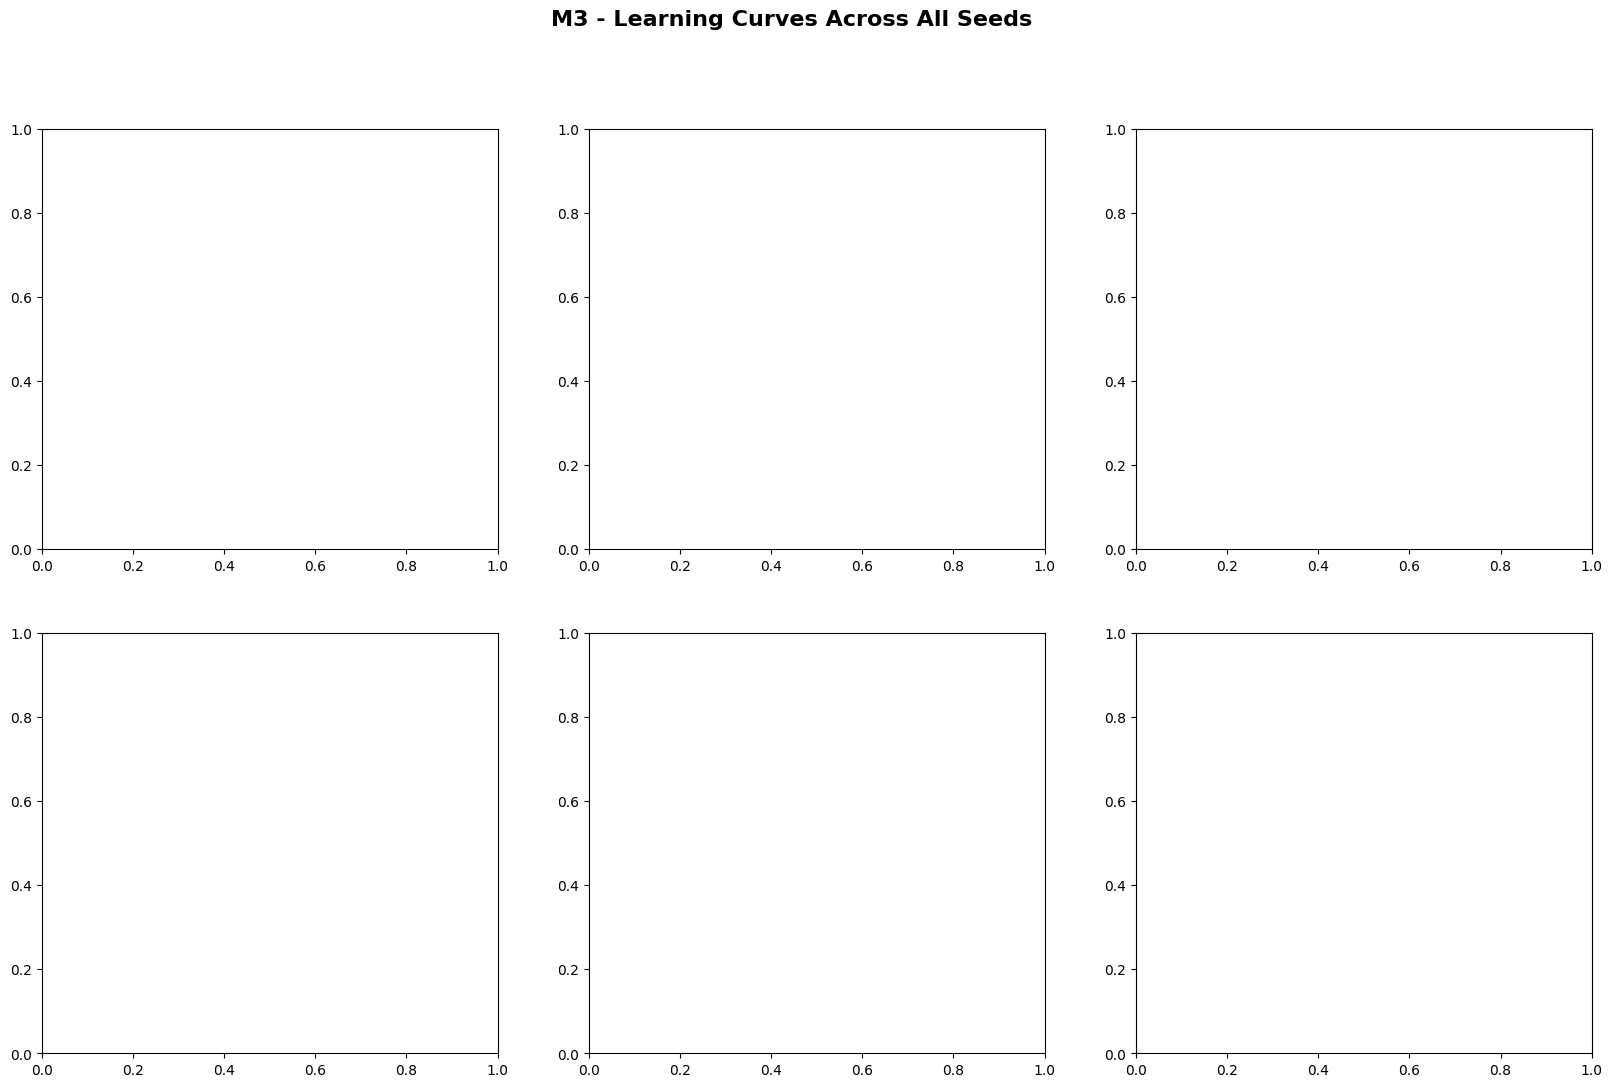

In [ ]:
# ============================================
# ADDITIONAL VISUALIZATIONS
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json
import os
from itertools import product

class AdditionalVisualizations:
    """
    Additional visualizations for thesis
    """

    def __init__(self, seeds=[42, 123, 456, 789, 1024]):
        self.seeds = seeds
        self.models = ['M1', 'M2', 'M3']

    def plot_confusion_matrices(self, all_results):
        """
        Plot confusion matrices for all models (averaged across seeds)
        """
        print("\nGenerating confusion matrices...")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Confusion Matrices (Averaged Across 5 Seeds)',
                     fontsize=16, fontweight='bold')

        for idx, model_name in enumerate(self.models):
            # Average confusion matrix across seeds
            cms = [np.array(r['confusion_matrix']) for r in all_results[model_name]['performance']]
            avg_cm = np.mean(cms, axis=0)

            # Normalize for better visualization
            avg_cm_normalized = avg_cm / avg_cm.sum(axis=1, keepdims=True)

            # Plot
            sns.heatmap(avg_cm_normalized, annot=True, fmt='.3f',
                       cmap='Blues', ax=axes[idx],
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'],
                       cbar_kws={'label': 'Proportion'})

            axes[idx].set_title(f'{model_name}')
            axes[idx].set_ylabel('True Label')
            axes[idx].set_xlabel('Predicted Label')

            # Add counts
            for i, j in product(range(2), range(2)):
                text = axes[idx].text(j + 0.5, i + 0.7,
                                     f'n={int(avg_cm[i, j])}',
                                     ha="center", va="center",
                                     color="red", fontsize=9)

        plt.tight_layout()
        plt.savefig('./visualizations/confusion_matrices_all_models.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ Confusion matrices saved")

        # Also create individual confusion matrices for each seed
        self._plot_individual_confusion_matrices(all_results)

    def _plot_individual_confusion_matrices(self, all_results):
        """
        Plot confusion matrices for each seed separately
        """
        for seed_idx, seed in enumerate(self.seeds):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f'Confusion Matrices - Seed {seed}',
                        fontsize=16, fontweight='bold')

            for idx, model_name in enumerate(self.models):
                cm = np.array(all_results[model_name]['performance'][seed_idx]['confusion_matrix'])
                cm_normalized = cm / cm.sum(axis=1, keepdims=True)

                sns.heatmap(cm_normalized, annot=True, fmt='.3f',
                           cmap='Blues', ax=axes[idx],
                           xticklabels=['Negative', 'Positive'],
                           yticklabels=['Negative', 'Positive'],
                           cbar_kws={'label': 'Proportion'})

                axes[idx].set_title(f'{model_name}')
                axes[idx].set_ylabel('True Label')
                axes[idx].set_xlabel('Predicted Label')

                for i, j in product(range(2), range(2)):
                    text = axes[idx].text(j + 0.5, i + 0.7,
                                         f'n={int(cm[i, j])}',
                                         ha="center", va="center",
                                         color="red", fontsize=9)

            plt.tight_layout()
            plt.savefig(f'./visualizations/confusion_matrices_seed_{seed}.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

        print(f"✓ Individual confusion matrices saved for all {len(self.seeds)} seeds")

    def plot_learning_curves(self):
        """
        Plot learning curves (training loss, validation loss, validation F1)
        """
        print("\nGenerating learning curves...")

        # For each model, plot learning curves across all seeds
        for model_name in self.models:
            self._plot_model_learning_curves(model_name)

        # Also create combined learning curves
        self._plot_combined_learning_curves()

    def _plot_model_learning_curves(self, model_name):
        """
        Plot learning curves for a specific model
        """
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'{model_name} - Learning Curves Across All Seeds',
                     fontsize=16, fontweight='bold')

        # Plot for each seed
        for seed_idx, seed in enumerate(self.seeds):
            # Load training history
            history_file = f'./training_history/{model_name}_history_seed_{seed}.json'
            with open(history_file, 'r') as f:
                history = json.load(f)

            row = seed_idx // 3
            col = seed_idx % 3
            ax = axes[row, col]

            epochs = range(1, len(history['train_loss']) + 1)

            # Plot losses
            ax_loss = ax
            ax_loss.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
            ax_loss.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
            ax_loss.set_xlabel('Epoch')
            ax_loss.set_ylabel('Loss', color='b')
            ax_loss.tick_params(axis='y', labelcolor='b')
            ax_loss.legend(loc='upper left')
            ax_loss.grid(True, alpha=0.3)
            ax_loss.set_title(f'Seed {seed}')

            # Plot F1 on secondary y-axis
            ax_f1 = ax_loss.twinx()
            ax_f1.plot(epochs, history['val_f1_macro'], 'g-', label='Val F1 (Macro)', linewidth=2)
            ax_f1.plot(epochs, history['val_accuracy'], 'm--', label='Val Accuracy', linewidth=2)
            ax_f1.set_ylabel('F1 / Accuracy', color='g')
            ax_f1.tick_params(axis='y', labelcolor='g')
            ax_f1.legend(loc='upper right')
            ax_f1.set_ylim([0, 1])

            # Mark best epoch
            best_epoch = np.argmax(history['val_f1_macro']) + 1
            ax_loss.axvline(x=best_epoch, color='orange', linestyle='--',
                           alpha=0.7, label=f'Best Epoch: {best_epoch}')

        # Hide empty subplot if odd number of seeds
        if len(self.seeds) % 3 != 0:
            axes[1, 2].axis('off')

        plt.tight_layout()
        plt.savefig(f'./visualizations/{model_name}_learning_curves_all_seeds.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Learning curves saved for {model_name}")

    def _plot_combined_learning_curves(self):
        """
        Plot average learning curves for all models on same plot
        """
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle('Average Learning Curves Across All Models (5 Seeds)',
                     fontsize=16, fontweight='bold')

        colors = {'M1': 'blue', 'M2': 'green', 'M3': 'red'}

        for model_name in self.models:
            # Collect histories for all seeds
            all_train_losses = []
            all_val_losses = []
            all_val_f1s = []

            for seed in self.seeds:
                history_file = f'./training_history/{model_name}_history_seed_{seed}.json'
                with open(history_file, 'r') as f:
                    history = json.load(f)

                all_train_losses.append(history['train_loss'])
                all_val_losses.append(history['val_loss'])
                all_val_f1s.append(history['val_f1_macro'])

            # Find max epoch length
            max_epochs = max(len(h) for h in all_train_losses)

            # Pad sequences to same length (with NaN)
            def pad_sequence(seq_list, max_len):
                padded = []
                for seq in seq_list:
                    padded_seq = seq + [np.nan] * (max_len - len(seq))
                    padded.append(padded_seq)
                return np.array(padded)

            train_losses_padded = pad_sequence(all_train_losses, max_epochs)
            val_losses_padded = pad_sequence(all_val_losses, max_epochs)
            val_f1s_padded = pad_sequence(all_val_f1s, max_epochs)

            # Compute mean and std (ignoring NaN)
            train_loss_mean = np.nanmean(train_losses_padded, axis=0)
            train_loss_std = np.nanstd(train_losses_padded, axis=0)
            val_loss_mean = np.nanmean(val_losses_padded, axis=0)
            val_loss_std = np.nanstd(val_losses_padded, axis=0)
            val_f1_mean = np.nanmean(val_f1s_padded, axis=0)
            val_f1_std = np.nanstd(val_f1s_padded, axis=0)

            epochs = range(1, max_epochs + 1)

            # Plot losses
            axes[0].plot(epochs, train_loss_mean,
                        color=colors[model_name], linestyle='-',
                        label=f'{model_name} Train', linewidth=2)
            axes[0].fill_between(epochs,
                                train_loss_mean - train_loss_std,
                                train_loss_mean + train_loss_std,
                                color=colors[model_name], alpha=0.2)

            axes[0].plot(epochs, val_loss_mean,
                        color=colors[model_name], linestyle='--',
                        label=f'{model_name} Val', linewidth=2)
            axes[0].fill_between(epochs,
                                val_loss_mean - val_loss_std,
                                val_loss_mean + val_loss_std,
                                color=colors[model_name], alpha=0.2)

            # Plot F1
            axes[1].plot(epochs, val_f1_mean,
                        color=colors[model_name], linestyle='-',
                        label=f'{model_name}', linewidth=2)
            axes[1].fill_between(epochs,
                                val_f1_mean - val_f1_std,
                                val_f1_mean + val_f1_std,
                                color=colors[model_name], alpha=0.2)

        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training & Validation Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('F1 Score (Macro)')
        axes[1].set_title('Validation F1 Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        plt.tight_layout()
        plt.savefig('./visualizations/combined_learning_curves.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ Combined learning curves saved")

    def plot_per_class_performance(self, all_results):
        """
        Plot per-class performance (Precision, Recall, F1) for each model
        """
        print("\nGenerating per-class performance plots...")

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle('Per-Class Performance Comparison (Averaged Across 5 Seeds)',
                     fontsize=16, fontweight='bold')

        metrics = ['precision', 'recall', 'f1']
        classes = ['negative', 'positive']

        for idx, metric in enumerate(metrics):
            ax = axes[idx]

            x = np.arange(len(classes))
            width = 0.25

            for model_idx, model_name in enumerate(self.models):
                # Collect per-class metrics across seeds
                negative_values = []
                positive_values = []

                for seed_idx in range(len(self.seeds)):
                    perf = all_results[model_name]['performance'][seed_idx]
                    negative_values.append(perf['per_class']['negative'][metric])
                    positive_values.append(perf['per_class']['positive'][metric])

                # Compute means and stds
                values = [np.mean(negative_values), np.mean(positive_values)]
                stds = [np.std(negative_values), np.std(positive_values)]

                offset = (model_idx - 1) * width
                ax.bar(x + offset, values, width, yerr=stds,
                      label=model_name, alpha=0.7, capsize=5)

            ax.set_ylabel(metric.capitalize())
            ax.set_title(f'{metric.capitalize()} by Class')
            ax.set_xticks(x)
            ax.set_xticklabels(classes)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.savefig('./visualizations/per_class_performance.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ Per-class performance plots saved")

    def plot_fairness_metrics_heatmap(self, all_results):
        """
        Create heatmap of fairness metrics across models and subgroups
        """
        print("\nGenerating fairness metrics heatmap...")

        subgroups = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']
        fairness_metrics = ['DPD', 'EOG', 'BA Range', 'Acc Gap']

        # Create data for heatmap
        data = {metric: {model: [] for model in self.models} for metric in fairness_metrics}

        for model_name in self.models:
            for subgroup in subgroups:
                # Average across seeds
                dpds = []
                eogs = []
                ba_ranges = []
                acc_gaps = []

                for seed_idx in range(len(self.seeds)):
                    fairness = all_results[model_name]['fairness'][seed_idx]
                    fm = fairness['subgroup_metrics'][subgroup]['fairness_metrics']

                    dpds.append(fm['demographic_parity_difference'])
                    eogs.append(fm['equalized_odds_gap'])
                    ba_ranges.append(fm['bias_amplification_range'])
                    acc_gaps.append(fm['accuracy_gap'])

                data['DPD'][model_name].append(np.mean(dpds))
                data['EOG'][model_name].append(np.mean(eogs))
                data['BA Range'][model_name].append(np.mean(ba_ranges))
                data['Acc Gap'][model_name].append(np.mean(acc_gaps))

        # Create subplots for each metric
        fig, axes = plt.subplots(2, 2, figsize=(16, 14))
        fig.suptitle('Fairness Metrics Heatmap (Averaged Across 5 Seeds)',
                     fontsize=16, fontweight='bold')

        for idx, (metric, ax) in enumerate(zip(fairness_metrics, axes.flat)):
            # Create dataframe for heatmap
            df = pd.DataFrame(data[metric], index=self.models)
            df.columns = [s.replace('_', ' ').title() for s in subgroups]

            # Plot heatmap
            sns.heatmap(df, annot=True, fmt='.3f', cmap='YlOrRd',
                       ax=ax, cbar_kws={'label': metric})
            ax.set_title(f'{metric}')
            ax.set_xlabel('Subgroup')
            ax.set_ylabel('Model')

        plt.tight_layout()
        plt.savefig('./visualizations/fairness_metrics_heatmap.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ Fairness metrics heatmap saved")

    def plot_roc_curves(self, all_results, test_df):
        """
        Plot ROC curves for all models
        """
        print("\nGenerating ROC curves...")

        from sklearn.metrics import roc_curve, auc

        # We need to re-evaluate to get probabilities
        # For simplicity, let's plot for one representative seed
        representative_seed = self.seeds[0]

        fig, ax = plt.subplots(figsize=(10, 8))

        colors = {'M1': 'blue', 'M2': 'green', 'M3': 'red'}

        # Load test data
        from transformers import BertTokenizer
        bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        for model_name in self.models:
            # Load model
            if model_name == 'M1':
                checkpoint = torch.load(f'./models/{model_name}_BiLSTM_seed_{representative_seed}.pth')
                vocab_builder = checkpoint['vocab']

                from training_code import BiLSTMClassifier, MentalHealthDataset
                model = BiLSTMClassifier(
                    vocab_size=len(vocab_builder.word2idx),
                    embedding_dim=300,
                    hidden_dim=256,
                    num_layers=2,
                    dropout=0.3
                ).to(device)
                model.load_state_dict(checkpoint['model_state_dict'])

                def collate_fn_bilstm(batch):
                    texts = [item['text'] for item in batch]
                    labels = torch.stack([item['label'] for item in batch])
                    encoded = [vocab_builder.encode_text(text, max_length=128) for text in texts]
                    encoded_tensor = torch.tensor(encoded, dtype=torch.long)
                    return encoded_tensor, labels

                test_dataset = MentalHealthDataset(
                    test_df['text_clean'].tolist(),
                    test_df['label'].tolist(),
                    use_bert=False
                )
                test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_bilstm)

            else:
                if model_name == 'M2':
                    checkpoint = torch.load(f'./models/{model_name}_VanillaBERT_seed_{representative_seed}.pth')
                    from training_code import VanillaBERT, MentalHealthDataset
                    model = VanillaBERT(num_classes=2, dropout=0.3).to(device)
                else:
                    checkpoint = torch.load(f'./models/{model_name}_FairBERT_seed_{representative_seed}.pth')
                    from training_code import FairBERT, MentalHealthDataset
                    model = FairBERT(num_classes=2, num_protected_groups=4, dropout=0.3).to(device)

                model.load_state_dict(checkpoint['model_state_dict'])

                test_dataset = MentalHealthDataset(
                    test_df['text_clean'].tolist(),
                    test_df['label'].tolist(),
                    tokenizer=bert_tokenizer,
                    max_length=128,
                    use_bert=True
                )
                test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            # Get predictions
            model.eval()
            all_probs = []
            all_labels = []

            with torch.no_grad():
                for batch in test_loader:
                    if model_name == 'M1':
                        batch_texts, batch_labels = batch
                        batch_texts = batch_texts.to(device)
                        outputs = model(batch_texts)
                    else:
                        input_ids = batch['input_ids'].to(device)
                        attention_mask = batch['attention_mask'].to(device)
                        batch_labels = batch['label']

                        if model_name == 'M3':
                            outputs, _ = model(input_ids, attention_mask)
                        else:
                            outputs = model(input_ids, attention_mask)

                    probs = torch.softmax(outputs, dim=1)
                    all_probs.extend(probs[:, 1].cpu().numpy())
                    all_labels.extend(batch_labels.cpu().numpy())

            # Compute ROC curve
            fpr, tpr, _ = roc_curve(all_labels, all_probs)
            roc_auc = auc(fpr, tpr)

            # Plot
            ax.plot(fpr, tpr, color=colors[model_name], linewidth=2,
                   label=f'{model_name} (AUC = {roc_auc:.3f})')

        # Plot diagonal
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

        ax.set_xlabel('False Positive Rate', fontsize=12)
        ax.set_ylabel('True Positive Rate', fontsize=12)
        ax.set_title(f'ROC Curves (Seed {representative_seed})', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', fontsize=11)
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('./visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

        print("✓ ROC curves saved")

    def generate_all_visualizations(self, all_results, test_df):
        """
        Generate all visualizations
        """
        print(f"\n{'='*70}")
        print("GENERATING ADDITIONAL VISUALIZATIONS")
        print(f"{'='*70}")

        os.makedirs('./visualizations', exist_ok=True)

        # 1. Confusion matrices
        self.plot_confusion_matrices(all_results)

        # 2. Learning curves
        self.plot_learning_curves()

        # 3. Per-class performance
        self.plot_per_class_performance(all_results)

        # 4. Fairness heatmap
        self.plot_fairness_metrics_heatmap(all_results)

        # 5. ROC curves
        self.plot_roc_curves(all_results, test_df)

        print(f"\n{'='*70}")
        print("✓ ALL VISUALIZATIONS COMPLETE!")
        print(f"{'='*70}")


# ============================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================

class StatisticalTester:
    """
    Perform statistical significance testing between models
    """

    def __init__(self, all_results, seeds):
        self.all_results = all_results
        self.seeds = seeds
        self.models = ['M1', 'M2', 'M3']

    def perform_statistical_tests(self):
        """
        Perform comprehensive statistical tests
        """
        print(f"\n{'='*70}")
        print("STATISTICAL SIGNIFICANCE TESTING")
        print(f"{'='*70}")

        results = {
            'performance': self._test_performance_differences(),
            'fairness': self._test_fairness_differences()
        }

        # Save results
        with open('./evaluation_results/statistical_tests.json', 'w') as f:
            json.dump(results, f, indent=2, default=str)

        return results

    def _test_performance_differences(self):
        """
        Test statistical significance of performance differences
        """
        print("\n### PERFORMANCE METRICS TESTING ###")

        from scipy.stats import ttest_rel, wilcoxon

        # Extract metrics
        metrics_data = {}
        for model in self.models:
            metrics_data[model] = {
                'accuracy': [r['accuracy'] for r in self.all_results[model]['performance']],
                'f1_macro': [r['f1_macro'] for r in self.all_results[model]['performance']],
                'f1_weighted': [r['f1_weighted'] for r in self.all_results[model]['performance']]
            }

        # Pairwise comparisons
        comparisons = [('M1', 'M2'), ('M1', 'M3'), ('M2', 'M3')]
        results = {}

        for metric in ['accuracy', 'f1_macro', 'f1_weighted']:
            print(f"\n{metric.upper()}:")
            results[metric] = {}

            for model1, model2 in comparisons:
                data1 = metrics_data[model1][metric]
                data2 = metrics_data[model2][metric]

                # Paired t-test
                t_stat, t_pval = ttest_rel(data1, data2)

                # Wilcoxon signed-rank test (non-parametric alternative)
                w_stat, w_pval = wilcoxon(data1, data2)

                # Effect size (Cohen's d)
                mean_diff = np.mean(data1) - np.mean(data2)
                pooled_std = np.sqrt((np.std(data1)**2 + np.std(data2)**2) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0

                results[metric][f'{model1}_vs_{model2}'] = {
                    'mean_diff': float(mean_diff),
                    'paired_t_test': {
                        't_statistic': float(t_stat),
                        'p_value': float(t_pval),
                        'significant_0.05': t_pval < 0.05,
                        'significant_0.01': t_pval < 0.01
                    },
                    'wilcoxon_test': {
                        'statistic': float(w_stat),
                        'p_value': float(w_pval),
                        'significant_0.05': w_pval < 0.05,
                        'significant_0.01': w_pval < 0.01
                    },
                    'cohens_d': float(cohens_d),
                    'effect_size': self._interpret_cohens_d(cohens_d)
                }

                print(f"  {model1} vs {model2}:")
                print(f"    Mean diff: {mean_diff:+.4f}")
                print(f"    Paired t-test: t={t_stat:.3f}, p={t_pval:.4f} {'*' if t_pval < 0.05 else ''}")
                print(f"    Wilcoxon test: W={w_stat:.1f}, p={w_pval:.4f} {'*' if w_pval < 0.05 else ''}")
                print(f"    Cohen's d: {cohens_d:.3f} ({self._interpret_cohens_d(cohens_d)})")

        return results

    def _test_fairness_differences(self):
        """
        Test statistical significance of fairness differences
        """
        print("\n### FAIRNESS METRICS TESTING ###")

        from scipy.stats import ttest_rel, wilcoxon

        # Extract fairness metrics
        fairness_data = {}
        for model in self.models:
            fairness_data[model] = {
                'dpd': [r['aggregate_metrics']['averages']['avg_dpd']
                       for r in self.all_results[model]['fairness']],
                'eog': [r['aggregate_metrics']['averages']['avg_eog']
                       for r in self.all_results[model]['fairness']],
                'ba_range': [r['aggregate_metrics']['averages']['avg_bias_amplification_range']
                            for r in self.all_results[model]['fairness']]
            }

        # Pairwise comparisons
        comparisons = [('M1', 'M2'), ('M1', 'M3'), ('M2', 'M3')]
        results = {}

        for metric in ['dpd', 'eog', 'ba_range']:
            print(f"\n{metric.upper()}:")
            results[metric] = {}

            for model1, model2 in comparisons:
                data1 = fairness_data[model1][metric]
                data2 = fairness_data[model2][metric]

                # Paired t-test
                t_stat, t_pval = ttest_rel(data1, data2)

                # Wilcoxon signed-rank test
                w_stat, w_pval = wilcoxon(data1, data2)

                # Effect size
                mean_diff = np.mean(data1) - np.mean(data2)
                pooled_std = np.sqrt((np.std(data1)**2 + np.std(data2)**2) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std != 0 else 0

                results[metric][f'{model1}_vs_{model2}'] = {
                    'mean_diff': float(mean_diff),
                    'paired_t_test': {
                        't_statistic': float(t_stat),
                        'p_value': float(t_pval),
                        'significant_0.05': t_pval < 0.05,
                        'significant_0.01': t_pval < 0.01
                    },
                    'wilcoxon_test': {
                        'statistic': float(w_stat),
                        'p_value': float(w_pval),
                        'significant_0.05': w_pval < 0.05,
                        'significant_0.01': w_pval < 0.01
                    },
                    'cohens_d': float(cohens_d),
                    'effect_size': self._interpret_cohens_d(cohens_d)
                }

                print(f"  {model1} vs {model2}:")
                print(f"    Mean diff: {mean_diff:+.4f}")
                print(f"    Paired t-test: t={t_stat:.3f}, p={t_pval:.4f} {'*' if t_pval < 0.05 else ''}")
                print(f"    Wilcoxon test: W={w_stat:.1f}, p={w_pval:.4f} {'*' if w_pval < 0.05 else ''}")
                print(f"    Cohen's d: {cohens_d:.3f} ({self._interpret_cohens_d(cohens_d)})")

        return results

    def _interpret_cohens_d(self, d):
        """
        Interpret Cohen's d effect size
        """
        abs_d = abs(d)
        if abs_d < 0.2:
            return "negligible"
        elif abs_d < 0.5:
            return "small"
        elif abs_d < 0.8:
            return "medium"
        else:
            return "large"


# ============================================
# THESIS TABLES AND FIGURES GENERATOR
# ============================================

class ThesisTablesGenerator:
    """
    Generate publication-ready tables for thesis
    """

    def __init__(self, all_results, statistical_results, seeds):
        self.all_results = all_results
        self.statistical_results = statistical_results
        self.seeds = seeds
        self.models = ['M1', 'M2', 'M3']

    def generate_all_tables(self):
        """
        Generate all thesis tables
        """
        print(f"\n{'='*70}")
        print("GENERATING THESIS TABLES")
        print(f"{'='*70}")

        os.makedirs('./thesis_outputs', exist_ok=True)

        # Table 1: Dataset Statistics
        self._generate_dataset_statistics_table()

        # Table 2: Overall Performance Comparison
        self._generate_performance_comparison_table()

        # Table 3: Per-Class Performance
        self._generate_per_class_performance_table()

        # Table 4: Fairness Metrics Summary
        self._generate_fairness_summary_table()

        # Table 5: Statistical Significance Tests
        self._generate_statistical_tests_table()

        # Table 6: Subgroup-wise Fairness (Gender)
        self._generate_subgroup_fairness_table('inferred_gender', 'Gender')

        # Table 7: Subgroup-wise Fairness (Crisis Severity)
        self._generate_subgroup_fairness_table('crisis_severity', 'Crisis Severity')

        # Table 8: Model Configuration Summary
        self._generate_model_config_table()

        print(f"\n✓ All thesis tables generated in ./thesis_outputs/")

    def _generate_dataset_statistics_table(self):
        """
        Table 1: Dataset statistics
        """
        # Load data
        train_m1_m2 = pd.read_csv('./prepared_data/train_M1_M2_undersampled.csv')
        train_m3 = pd.read_csv('./prepared_data/train_M3_CDA.csv')
        val_df = pd.read_csv('./prepared_data/val_all_models.csv')
        test_df = pd.read_csv('./prepared_data/test_all_models.csv')

        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Dataset Statistics}")
        table.append("\\label{tab:dataset_stats}")
        table.append("\\begin{tabular}{lccc}")
        table.append("\\toprule")
        table.append("\\textbf{Split} & \\textbf{Total} & \\textbf{Positive} & \\textbf{Negative} \\\\")
        table.append("\\midrule")

        # Original full dataset
        total = len(train_m1_m2) + len(val_df) + len(test_df)
        original_train_size = int(total * 0.7)

        # Training (M1/M2)
        pos = sum(train_m1_m2['label'] == 'positive')
        neg = sum(train_m1_m2['label'] == 'negative')
        table.append(f"Train (M1/M2) & {len(train_m1_m2)} & {pos} ({pos/len(train_m1_m2)*100:.1f}\\%) & {neg} ({neg/len(train_m1_m2)*100:.1f}\\%) \\\\")

        # Training (M3)
        pos = sum(train_m3['label'] == 'positive')
        neg = sum(train_m3['label'] == 'negative')
        table.append(f"Train (M3) & {len(train_m3)} & {pos} ({pos/len(train_m3)*100:.1f}\\%) & {neg} ({neg/len(train_m3)*100:.1f}\\%) \\\\")

        # Validation
        pos = sum(val_df['label'] == 'positive')
        neg = sum(val_df['label'] == 'negative')
        table.append(f"Validation & {len(val_df)} & {pos} ({pos/len(val_df)*100:.1f}\\%) & {neg} ({neg/len(val_df)*100:.1f}\\%) \\\\")

        # Test
        pos = sum(test_df['label'] == 'positive')
        neg = sum(test_df['label'] == 'negative')
        table.append(f"Test & {len(test_df)} & {pos} ({pos/len(test_df)*100:.1f}\\%) & {neg} ({neg/len(test_df)*100:.1f}\\%) \\\\")

        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table1_dataset_stats.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table 1: Dataset Statistics")

    def _generate_performance_comparison_table(self):
        """
        Table 2: Overall performance comparison
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Overall Performance Comparison (Mean ± Std across 5 seeds)}")
        table.append("\\label{tab:performance_comparison}")
        table.append("\\begin{tabular}{lcccc}")
        table.append("\\toprule")
        table.append("\\textbf{Model} & \\textbf{Accuracy} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1 (Macro)} \\\\")
        table.append("\\midrule")

        for model_name in self.models:
            accs = [r['accuracy'] for r in self.all_results[model_name]['performance']]
            precs = [r['precision_macro'] for r in self.all_results[model_name]['performance']]
            recs = [r['recall_macro'] for r in self.all_results[model_name]['performance']]
            f1s = [r['f1_macro'] for r in self.all_results[model_name]['performance']]

            table.append(f"{model_name} & "
                        f"{np.mean(accs):.3f} $\\pm$ {np.std(accs):.3f} & "
                        f"{np.mean(precs):.3f} $\\pm$ {np.std(precs):.3f} & "
                        f"{np.mean(recs):.3f} $\\pm$ {np.std(recs):.3f} & "
                        f"{np.mean(f1s):.3f} $\\pm$ {np.std(f1s):.3f} \\\\")

        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table2_performance_comparison.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table 2: Overall Performance Comparison")

    def _generate_per_class_performance_table(self):
        """
        Table 3: Per-class performance
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Per-Class Performance Metrics}")
        table.append("\\label{tab:per_class_performance}")
        table.append("\\begin{tabular}{llccc}")
        table.append("\\toprule")
        table.append("\\textbf{Model} & \\textbf{Class} & \\textbf{Precision} & \\textbf{Recall} & \\textbf{F1} \\\\")
        table.append("\\midrule")

        for model_name in self.models:
            for class_name in ['negative', 'positive']:
                precs = [r['per_class'][class_name]['precision']
                        for r in self.all_results[model_name]['performance']]
                recs = [r['per_class'][class_name]['recall']
                       for r in self.all_results[model_name]['performance']]
                f1s = [r['per_class'][class_name]['f1']
                      for r in self.all_results[model_name]['performance']]

                table.append(f"{model_name} & {class_name.capitalize()} & "
                            f"{np.mean(precs):.3f} $\\pm$ {np.std(precs):.3f} & "
                            f"{np.mean(recs):.3f} $\\pm$ {np.std(recs):.3f} & "
                            f"{np.mean(f1s):.3f} $\\pm$ {np.std(f1s):.3f} \\\\")

            if model_name != 'M3':
                table.append("\\cmidrule(lr){2-5}")

        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table3_per_class_performance.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table 3: Per-Class Performance")

    def _generate_fairness_summary_table(self):
        """
        Table 4: Fairness metrics summary
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Fairness Metrics Summary (Lower is Better)}")
        table.append("\\label{tab:fairness_summary}")
        table.append("\\begin{tabular}{lcccc}")
        table.append("\\toprule")
        table.append("\\textbf{Model} & \\textbf{Avg DPD} & \\textbf{Avg EOG} & \\textbf{Avg BA Range} & \\textbf{Avg Acc Gap} \\\\")
        table.append("\\midrule")

        for model_name in self.models:
            dpds = [r['aggregate_metrics']['averages']['avg_dpd']
                   for r in self.all_results[model_name]['fairness']]
            eogs = [r['aggregate_metrics']['averages']['avg_eog']
                   for r in self.all_results[model_name]['fairness']]
            ba_ranges = [r['aggregate_metrics']['averages']['avg_bias_amplification_range']
                        for r in self.all_results[model_name]['fairness']]
            acc_gaps = [r['aggregate_metrics']['averages']['avg_accuracy_gap']
                       for r in self.all_results[model_name]['fairness']]

            table.append(f"{model_name} & "
                        f"{np.mean(dpds):.3f} $\\pm$ {np.std(dpds):.3f} & "
                        f"{np.mean(eogs):.3f} $\\pm$ {np.std(eogs):.3f} & "
                        f"{np.mean(ba_ranges):.3f} $\\pm$ {np.std(ba_ranges):.3f} & "
                        f"{np.mean(acc_gaps):.3f} $\\pm$ {np.std(acc_gaps):.3f} \\\\")

        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table4_fairness_summary.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table 4: Fairness Metrics Summary")

    def _generate_statistical_tests_table(self):
        """
        Table 5: Statistical significance tests
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Statistical Significance Tests (Paired t-test)}")
        table.append("\\label{tab:statistical_tests}")
        table.append("\\begin{tabular}{llccl}")
        table.append("\\toprule")
        table.append("\\textbf{Metric} & \\textbf{Comparison} & \\textbf{Mean Diff} & \\textbf{p-value} & \\textbf{Significant?} \\\\")
        table.append("\\midrule")

        metrics = {
            'accuracy': 'Accuracy',
            'f1_macro': 'F1 (Macro)',
            'dpd': 'DPD',
            'eog': 'EOG'
        }

        comparisons = ['M1_vs_M2', 'M1_vs_M3', 'M2_vs_M3']

        for metric_key, metric_name in metrics.items():
            if metric_key in ['accuracy', 'f1_macro']:
                data = self.statistical_results['performance'][metric_key]
            else:
                data = self.statistical_results['fairness'][metric_key]

            for comp in comparisons:
                result = data[comp]
                mean_diff = result['mean_diff']
                p_val = result['paired_t_test']['p_value']
                sig = "Yes***" if p_val < 0.001 else ("Yes**" if p_val < 0.01 else ("Yes*" if p_val < 0.05 else "No"))

                table.append(f"{metric_name} & {comp.replace('_', ' ')} & "
                            f"{mean_diff:+.4f} & {p_val:.4f} & {sig} \\\\")

            if metric_key != 'eog':
                table.append("\\cmidrule(lr){2-5}")

        table.append("\\bottomrule")
        table.append("\\multicolumn{5}{l}{\\footnotesize * p < 0.05, ** p < 0.01, *** p < 0.001}")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table5_statistical_tests.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table 5: Statistical Significance Tests")

    def _generate_subgroup_fairness_table(self, subgroup_key, subgroup_name):
        """
        Generate subgroup-specific fairness table
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append(f"\\caption{{Fairness Metrics by {subgroup_name}}}")
        table.append(f"\\label{{tab:fairness_{subgroup_key}}}")
        table.append("\\begin{tabular}{llcccc}")
        table.append("\\toprule")
        table.append(f"\\textbf{{Model}} & \\textbf{{{subgroup_name}}} & \\textbf{{Accuracy}} & \\textbf{{TPR}} & \\textbf{{FPR}} & \\textbf{{Pos Rate}} \\\\")
        table.append("\\midrule")

        # Get subgroup values from first seed (representative)
        test_df = pd.read_csv('./prepared_data/test_all_models.csv')
        subgroups = sorted(test_df[subgroup_key].unique())

        for model_name in self.models:
            for sg in subgroups:
                # Average across seeds
                accs = []
                tprs = []
                fprs = []
                pos_rates = []

                for seed_idx in range(len(self.seeds)):
                    fairness = self.all_results[model_name]['fairness'][seed_idx]
                    sg_data = fairness['subgroup_metrics'][subgroup_key]['subgroup_performance'].get(str(sg))

                    if sg_data:
                        accs.append(sg_data['accuracy'])
                        tprs.append(sg_data['tpr'])
                        fprs.append(sg_data['fpr'])
                        pos_rates.append(sg_data['positive_rate'])

                if accs:
                    table.append(f"{model_name} & {sg} & "
                                f"{np.mean(accs):.3f} & "
                                f"{np.mean(tprs):.3f} & "
                                f"{np.mean(fprs):.3f} & "
                                f"{np.mean(pos_rates):.3f} \\\\")

            if model_name != 'M3':
                table.append("\\cmidrule(lr){2-6}")

        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        filename = f'table_fairness_{subgroup_key}.tex'
        with open(f'./thesis_outputs/{filename}', 'w') as f:
            f.write('\n'.join(table))

        print(f"✓ Table: Fairness by {subgroup_name}")

    def _generate_model_config_table(self):
        """
        Table: Model configuration summary
        """
        table = []
        table.append("\\begin{table}[htbp]")
        table.append("\\centering")
        table.append("\\caption{Model Configurations and Training Setup}")
        table.append("\\label{tab:model_config}")
        table.append("\\begin{tabular}{llll}")
        table.append("\\toprule")
        table.append("\\textbf{Configuration} & \\textbf{M1 (BiLSTM)} & \\textbf{M2 (BERT)} & \\textbf{M3 (FairBERT)} \\\\")
        table.append("\\midrule")
        table.append("Architecture & BiLSTM & BERT-base & BERT-base + Adv \\\\")
        table.append("Hidden Dim & 256 (x2) & 768 & 768 \\\\")
        table.append("Dropout & 0.3 & 0.3 & 0.3 \\\\")
        table.append("Max Epochs & 15 & 12 & 12 \\\\")
        table.append("Batch Size & 32 & 32 & 32 \\\\")
        table.append("Learning Rate & 1e-3 & 2e-5 & 2e-5 \\\\")
        table.append("Loss Function & Cross-Entropy & Cross-Entropy & Focal Loss \\\\")
        table.append("Class Weights & Yes & Yes & No \\\\")
        table.append("Focal Gamma & - & - & 2.0 \\\\")
        table.append("Adv Lambda & - & - & 0.5 \\\\")
        table.append("Data Aug & Undersampling & Undersampling & CDA \\\\")
        table.append("Early Stopping & Patience=3 & Patience=3 & Patience=3 \\\\")
        table.append("\\bottomrule")
        table.append("\\end{tabular}")
        table.append("\\end{table}")

        with open('./thesis_outputs/table_model_config.tex', 'w') as f:
            f.write('\n'.join(table))

        print("✓ Table: Model Configuration")


# ============================================
# MAIN EXECUTION - COMPLETE PIPELINE
# ============================================

def complete_evaluation_pipeline():
    """
    Complete evaluation, visualization, and statistical testing pipeline
    """
    import torch
    global device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    SEEDS = [42, 123, 456, 789, 1024]

    print(f"\n{'#'*70}")
    print("# COMPLETE EVALUATION PIPELINE")
    print(f"{'#'*70}\n")

    # Step 1: Evaluate all models (if not already done)
    print("\nStep 1: Model Evaluation")
    all_results = evaluate_all_models(seeds=SEEDS)

    # Load test data
    test_df = pd.read_csv('./prepared_data/test_all_models.csv')

    # Step 2: Generate additional visualizations
    print("\nStep 2: Additional Visualizations")
    visualizer = AdditionalVisualizations(seeds=SEEDS)
    visualizer.generate_all_visualizations(all_results, test_df)

    # Step 3: Statistical testing
    print("\nStep 3: Statistical Significance Testing")
    tester = StatisticalTester(all_results, SEEDS)
    statistical_results = tester.perform_statistical_tests()

    # Step 4: Generate thesis tables
    print("\nStep 4: Thesis Tables Generation")
    tables_gen = ThesisTablesGenerator(all_results, statistical_results, SEEDS)
    tables_gen.generate_all_tables()

    print(f"\n\n{'='*70}")
    print("✓✓✓ COMPLETE EVALUATION PIPELINE FINISHED! ✓✓✓")
    print(f"{'='*70}")
    print("\nAll outputs saved to:")
    print("  - ./evaluation_results/     (JSON results)")
    print("  - ./visualizations/         (All plots and figures)")
    print("  - ./thesis_outputs/         (LaTeX tables)")

    return all_results, statistical_results


if __name__ == "__main__":
    # Run complete pipeline
    all_results, statistical_results = complete_evaluation_pipeline()

In [ ]:
# ============================================
# COMPLETE EVALUATION & VISUALIZATION PIPELINE
# ============================================

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, roc_curve, auc, roc_auc_score
)
from scipy import stats
from torch.utils.data import DataLoader
import json
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ============================================
# MODEL EVALUATOR
# ============================================

class ModelEvaluator:
    """
    Evaluate model performance on test set
    """
    def __init__(self, model, test_loader, model_name, seed):
        self.model = model
        self.test_loader = test_loader
        self.model_name = model_name
        self.seed = seed
        self.predictions = None
        self.true_labels = None
        self.probabilities = None

    def evaluate(self):
        """
        Run evaluation and return metrics
        """
        print(f"\nEvaluating {self.model_name} (Seed {self.seed})...")

        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in tqdm(self.test_loader, desc="Evaluating"):
                if self.model_name == 'M1':
                    # BiLSTM
                    texts, labels = batch
                    texts = texts.to(device)
                    outputs = self.model(texts)
                else:
                    # BERT models
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['label']

                    if self.model_name == 'M3':
                        outputs, _ = self.model(input_ids, attention_mask)
                    else:
                        outputs = self.model(input_ids, attention_mask)

                # Get predictions and probabilities
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        self.predictions = np.array(all_preds)
        self.true_labels = np.array(all_labels)
        self.probabilities = np.array(all_probs)

        # Compute metrics
        acc = accuracy_score(self.true_labels, self.predictions)

        # Macro metrics
        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            self.true_labels, self.predictions, average='macro', zero_division=0
        )

        # Weighted metrics
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            self.true_labels, self.predictions, average='weighted', zero_division=0
        )

        # Per-class metrics
        precision_per_class, recall_per_class, f1_per_class, support = precision_recall_fscore_support(
            self.true_labels, self.predictions, average=None, zero_division=0
        )

        # AUC-ROC
        try:
            auc_roc = roc_auc_score(self.true_labels, self.probabilities[:, 1])
        except:
            auc_roc = 0.0

        # Confusion matrix
        cm = confusion_matrix(self.true_labels, self.predictions)

        results = {
            'accuracy': float(acc),
            'precision_macro': float(precision_macro),
            'recall_macro': float(recall_macro),
            'f1_macro': float(f1_macro),
            'precision_weighted': float(precision_weighted),
            'recall_weighted': float(recall_weighted),
            'f1_weighted': float(f1_weighted),
            'auc_roc': float(auc_roc),
            'precision_per_class': precision_per_class.tolist(),
            'recall_per_class': recall_per_class.tolist(),
            'f1_per_class': f1_per_class.tolist(),
            'support': support.tolist(),
            'confusion_matrix': cm.tolist(),
            'predictions': self.predictions.tolist(),
            'probabilities': self.probabilities.tolist()
        }

        print(f"✓ {self.model_name} Evaluation Complete")
        print(f"  Accuracy: {acc:.4f}")
        print(f"  F1 (Macro): {f1_macro:.4f}")
        print(f"  AUC-ROC: {auc_roc:.4f}")

        return results


# ============================================
# FAIRNESS EVALUATOR
# ============================================

class FairnessEvaluator:
    """
    Evaluate fairness metrics across demographic subgroups
    """
    def __init__(self, predictions, true_labels, probabilities, test_df, model_name, seed):
        self.predictions = np.array(predictions)
        self.true_labels = np.array(true_labels)
        self.probabilities = np.array(probabilities)
        self.test_df = test_df.copy()
        self.model_name = model_name
        self.seed = seed

        # Add predictions to dataframe
        self.test_df['prediction'] = self.predictions
        self.test_df['true_label_numeric'] = self.true_labels
        self.test_df['prob_positive'] = self.probabilities[:, 1]

        # Subgroups to evaluate
        self.subgroup_columns = ['inferred_gender', 'crisis_severity', 'dialect', 'subreddit']

    def evaluate_fairness(self):
        """
        Compute all fairness metrics
        """
        print(f"\nEvaluating Fairness for {self.model_name} (Seed {self.seed})...")

        fairness_results = {}

        for subgroup_col in self.subgroup_columns:
            if subgroup_col not in self.test_df.columns:
                print(f"Warning: {subgroup_col} not found in test data")
                continue

            print(f"  Computing fairness for: {subgroup_col}")

            subgroup_metrics = self._compute_subgroup_metrics(subgroup_col)
            fairness_results[subgroup_col] = subgroup_metrics

        print(f"✓ Fairness Evaluation Complete")

        return fairness_results

    def _compute_subgroup_metrics(self, subgroup_col):
        """
        Compute fairness metrics for a specific subgroup
        """
        subgroups = self.test_df[subgroup_col].unique()
        subgroups = [s for s in subgroups if pd.notna(s)]

        metrics = {
            'subgroups': {},
            'demographic_parity_difference': 0.0,
            'equalized_odds_difference': 0.0,
            'bias_amplification': {},
            'accuracy_parity_gap': 0.0
        }

        positive_rates = []
        tprs = []
        fprs = []
        accuracies = []

        for subgroup in subgroups:
            subgroup_data = self.test_df[self.test_df[subgroup_col] == subgroup]

            if len(subgroup_data) == 0:
                continue

            y_true = subgroup_data['true_label_numeric'].values
            y_pred = subgroup_data['prediction'].values

            # Positive prediction rate
            positive_rate = np.mean(y_pred == 1)
            positive_rates.append(positive_rate)

            # True positive rate (TPR) and False positive rate (FPR)
            if np.sum(y_true == 1) > 0:
                tpr = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1)
            else:
                tpr = 0.0

            if np.sum(y_true == 0) > 0:
                fpr = np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_true == 0)
            else:
                fpr = 0.0

            tprs.append(tpr)
            fprs.append(fpr)

            # Accuracy
            acc = accuracy_score(y_true, y_pred)
            accuracies.append(acc)

            # Bias amplification
            true_positive_rate_data = np.mean(y_true == 1)
            bias_amp = positive_rate - true_positive_rate_data

            metrics['subgroups'][str(subgroup)] = {
                'count': int(len(subgroup_data)),
                'positive_prediction_rate': float(positive_rate),
                'true_positive_rate': float(tpr),
                'false_positive_rate': float(fpr),
                'accuracy': float(acc),
                'bias_amplification': float(bias_amp)
            }

        # Aggregate fairness metrics
        if len(positive_rates) > 0:
            metrics['demographic_parity_difference'] = float(max(positive_rates) - min(positive_rates))

        if len(tprs) > 0 and len(fprs) > 0:
            tpr_gap = max(tprs) - min(tprs)
            fpr_gap = max(fprs) - min(fprs)
            metrics['equalized_odds_difference'] = float(max(tpr_gap, fpr_gap))

        if len(accuracies) > 0:
            metrics['accuracy_parity_gap'] = float(max(accuracies) - min(accuracies))

        # Average bias amplification
        bias_amps = [m['bias_amplification'] for m in metrics['subgroups'].values()]
        if bias_amps:
            metrics['bias_amplification']['mean'] = float(np.mean(np.abs(bias_amps)))
            metrics['bias_amplification']['max'] = float(np.max(np.abs(bias_amps)))
            metrics['bias_amplification']['range'] = float(max(bias_amps) - min(bias_amps))

        return metrics


# ============================================
# FAIRNESS VISUALIZER
# ============================================

class FairnessVisualizer:
    """
    Visualize fairness metrics
    """
    def __init__(self, fairness_results, model_name, seed):
        self.fairness_results = fairness_results
        self.model_name = model_name
        self.seed = seed
        self.output_dir = './visualizations'
        os.makedirs(self.output_dir, exist_ok=True)

    def plot_fairness_comparison(self):
        """
        Plot fairness metrics across subgroups
        """
        print(f"\nGenerating fairness visualizations for {self.model_name} (Seed {self.seed})...")

        # Create a comprehensive fairness plot
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        subgroup_cols = list(self.fairness_results.keys())

        # Plot 1: Demographic Parity Difference
        ax = axes[0, 0]
        dpd_values = [self.fairness_results[col]['demographic_parity_difference']
                     for col in subgroup_cols]
        ax.bar(range(len(subgroup_cols)), dpd_values, color='steelblue', alpha=0.7)
        ax.set_xticks(range(len(subgroup_cols)))
        ax.set_xticklabels(subgroup_cols, rotation=45, ha='right')
        ax.set_ylabel('Demographic Parity Difference', fontsize=11)
        ax.set_title(f'{self.model_name}: Demographic Parity Difference', fontsize=12, fontweight='bold')
        ax.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Threshold (0.1)')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 2: Equalized Odds Difference
        ax = axes[0, 1]
        eod_values = [self.fairness_results[col]['equalized_odds_difference']
                     for col in subgroup_cols]
        ax.bar(range(len(subgroup_cols)), eod_values, color='coral', alpha=0.7)
        ax.set_xticks(range(len(subgroup_cols)))
        ax.set_xticklabels(subgroup_cols, rotation=45, ha='right')
        ax.set_ylabel('Equalized Odds Difference', fontsize=11)
        ax.set_title(f'{self.model_name}: Equalized Odds Difference', fontsize=12, fontweight='bold')
        ax.axhline(y=0.1, color='r', linestyle='--', alpha=0.5, label='Threshold (0.1)')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 3: Bias Amplification Range
        ax = axes[1, 0]
        ba_ranges = [self.fairness_results[col]['bias_amplification'].get('range', 0)
                    for col in subgroup_cols]
        ax.bar(range(len(subgroup_cols)), ba_ranges, color='mediumpurple', alpha=0.7)
        ax.set_xticks(range(len(subgroup_cols)))
        ax.set_xticklabels(subgroup_cols, rotation=45, ha='right')
        ax.set_ylabel('Bias Amplification Range', fontsize=11)
        ax.set_title(f'{self.model_name}: Bias Amplification', fontsize=12, fontweight='bold')
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
        ax.grid(True, alpha=0.3, axis='y')

        # Plot 4: Accuracy Parity Gap
        ax = axes[1, 1]
        apg_values = [self.fairness_results[col]['accuracy_parity_gap']
                     for col in subgroup_cols]
        ax.bar(range(len(subgroup_cols)), apg_values, color='seagreen', alpha=0.7)
        ax.set_xticks(range(len(subgroup_cols)))
        ax.set_xticklabels(subgroup_cols, rotation=45, ha='right')
        ax.set_ylabel('Accuracy Parity Gap', fontsize=11)
        ax.set_title(f'{self.model_name}: Accuracy Parity Gap', fontsize=12, fontweight='bold')
        ax.axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Threshold (0.05)')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/{self.model_name}_seed_{self.seed}_fairness.png',
                   dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: {self.model_name}_seed_{self.seed}_fairness.png")


# ============================================
# ADDITIONAL VISUALIZATIONS
# ============================================

class AdditionalVisualizations:
    """
    Generate learning curves, confusion matrices, and ROC curves
    """

    def __init__(self, seeds):
        self.seeds = seeds
        self.output_dir = './visualizations'
        os.makedirs(self.output_dir, exist_ok=True)

    def plot_learning_curves(self):
        """
        Plot learning curves for all models across all seeds
        """
        print("\n" + "="*60)
        print("GENERATING LEARNING CURVES")
        print("="*60)

        for model_name in ['M1', 'M2', 'M3']:
            self._plot_model_learning_curves(model_name)

    def _plot_model_learning_curves(self, model_name):
        """
        Plot learning curves for a specific model
        """
        fig, axes = plt.subplots(len(self.seeds), 2, figsize=(15, 4*len(self.seeds)))

        if len(self.seeds) == 1:
            axes = axes.reshape(1, -1)

        for idx, seed in enumerate(self.seeds):
            # Load training history
            history_file = f'./training_history/{model_name}_history_seed_{seed}.json'

            with open(history_file, 'r') as f:
                history = json.load(f)

            row = idx

            # FIXED: Handle different history keys for M3
            if model_name == 'M3':
                # M3 has 'train_main_loss' instead of 'train_loss'
                train_loss_key = 'train_main_loss'
            else:
                train_loss_key = 'train_loss'

            # Check if keys exist
            if train_loss_key not in history:
                print(f"Warning: {train_loss_key} not found in {model_name} history for seed {seed}")
                continue

            epochs = range(1, len(history[train_loss_key]) + 1)

            # Plot 1: Training & Validation Loss
            ax = axes[row, 0]
            ax.plot(epochs, history[train_loss_key], 'b-', label='Train Loss', linewidth=2)
            ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
            ax.set_xlabel('Epoch', fontsize=12)
            ax.set_ylabel('Loss', fontsize=12)
            ax.set_title(f'{model_name} - Seed {seed}: Loss Curves', fontsize=13, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            # Mark best epoch
            best_epoch = np.argmax(history['val_f1_macro']) + 1
            best_val_loss = history['val_loss'][best_epoch - 1]
            ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best Epoch: {best_epoch}')
            ax.plot(best_epoch, best_val_loss, 'g*', markersize=15)

            # Plot 2: Validation F1 & Accuracy
            ax = axes[row, 1]
            ax.plot(epochs, history['val_f1_macro'], 'b-', label='Val F1 (Macro)', linewidth=2)
            ax.plot(epochs, history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2)
            ax.set_xlabel('Epoch', fontsize=12)
            ax.set_ylabel('Score', fontsize=12)
            ax.set_title(f'{model_name} - Seed {seed}: Validation Metrics', fontsize=13, fontweight='bold')
            ax.legend(fontsize=10)
            ax.grid(True, alpha=0.3)

            # Mark best F1
            best_f1 = max(history['val_f1_macro'])
            ax.axhline(y=best_f1, color='g', linestyle='--', alpha=0.7)
            ax.plot(best_epoch, best_f1, 'g*', markersize=15)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/{model_name}_learning_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: {model_name}_learning_curves.png")

    def plot_combined_learning_curves(self):
        """
        Plot combined learning curves comparing all models
        """
        print("\n" + "="*60)
        print("GENERATING COMBINED LEARNING CURVES")
        print("="*60)

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        colors = {'M1': 'blue', 'M2': 'orange', 'M3': 'green'}

        for model_name in ['M1', 'M2', 'M3']:
            # Average across seeds
            all_val_losses = []
            all_val_f1s = []

            max_epochs = 0

            for seed in self.seeds:
                history_file = f'./training_history/{model_name}_history_seed_{seed}.json'

                with open(history_file, 'r') as f:
                    history = json.load(f)

                all_val_losses.append(history['val_loss'])
                all_val_f1s.append(history['val_f1_macro'])

                max_epochs = max(max_epochs, len(history['val_loss']))

            # Pad sequences to same length
            padded_losses = []
            padded_f1s = []

            for losses, f1s in zip(all_val_losses, all_val_f1s):
                if len(losses) < max_epochs:
                    # Pad with last value
                    losses = losses + [losses[-1]] * (max_epochs - len(losses))
                    f1s = f1s + [f1s[-1]] * (max_epochs - len(f1s))
                padded_losses.append(losses)
                padded_f1s.append(f1s)

            # Calculate mean and std
            mean_losses = np.mean(padded_losses, axis=0)
            std_losses = np.std(padded_losses, axis=0)

            mean_f1s = np.mean(padded_f1s, axis=0)
            std_f1s = np.std(padded_f1s, axis=0)

            epochs = range(1, max_epochs + 1)

            # Plot losses
            ax = axes[0]
            ax.plot(epochs, mean_losses, color=colors[model_name], label=model_name, linewidth=2)
            ax.fill_between(epochs,
                           mean_losses - std_losses,
                           mean_losses + std_losses,
                           color=colors[model_name],
                           alpha=0.2)

            # Plot F1
            ax = axes[1]
            ax.plot(epochs, mean_f1s, color=colors[model_name], label=model_name, linewidth=2)
            ax.fill_between(epochs,
                           mean_f1s - std_f1s,
                           mean_f1s + std_f1s,
                           color=colors[model_name],
                           alpha=0.2)

        # Configure loss plot
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Validation Loss', fontsize=12)
        axes[0].set_title('Model Comparison: Validation Loss', fontsize=13, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)

        # Configure F1 plot
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('Validation F1 (Macro)', fontsize=12)
        axes[1].set_title('Model Comparison: Validation F1', fontsize=13, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/combined_learning_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: combined_learning_curves.png")

    def plot_confusion_matrices(self):
        """
        Plot confusion matrices for all models averaged across seeds
        """
        print("\n" + "="*60)
        print("GENERATING CONFUSION MATRICES")
        print("="*60)

        # Load test data to get true labels
        test_df = pd.read_csv('./prepared_data/test_all_models.csv')
        label_map = {'negative': 0, 'positive': 1}
        true_labels = test_df['label'].map(label_map).values

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        for idx, model_name in enumerate(['M1', 'M2', 'M3']):
            # Collect predictions across seeds
            all_cms = []

            for seed in self.seeds:
                perf_file = f'./evaluation_results/{model_name}_seed_{seed}_performance.json'

                with open(perf_file, 'r') as f:
                    performance = json.load(f)

                predictions = performance['predictions']
                cm = confusion_matrix(true_labels, predictions)
                all_cms.append(cm)

            # Average confusion matrix
            avg_cm = np.mean(all_cms, axis=0)

            # Normalize
            cm_normalized = avg_cm.astype('float') / avg_cm.sum(axis=1)[:, np.newaxis]

            # Plot
            ax = axes[idx]
            sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                       xticklabels=['Negative', 'Positive'],
                       yticklabels=['Negative', 'Positive'],
                       ax=ax, cbar_kws={'label': 'Proportion'})

            # Add raw counts
            for i in range(2):
                for j in range(2):
                    text = ax.text(j + 0.5, i + 0.7, f'({int(avg_cm[i, j])})',
                                 ha="center", va="center", color="gray", fontsize=9)

            ax.set_xlabel('Predicted Label', fontsize=12)
            ax.set_ylabel('True Label', fontsize=12)
            ax.set_title(f'{model_name}: Confusion Matrix\n(Averaged across {len(self.seeds)} seeds)',
                        fontsize=13, fontweight='bold')

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: confusion_matrices.png")

    def plot_roc_curves(self):
        """
        Plot ROC curves for all models
        """
        print("\n" + "="*60)
        print("GENERATING ROC CURVES")
        print("="*60)

        from sklearn.metrics import roc_curve, auc

        # Load test data
        test_df = pd.read_csv('./prepared_data/test_all_models.csv')
        label_map = {'negative': 0, 'positive': 1}
        true_labels = test_df['label'].map(label_map).values

        plt.figure(figsize=(10, 8))

        colors = {'M1': 'blue', 'M2': 'orange', 'M3': 'green'}

        for model_name in ['M1', 'M2', 'M3']:
            # Collect probabilities across seeds
            all_fprs = []
            all_tprs = []
            all_aucs = []

            for seed in self.seeds:
                perf_file = f'./evaluation_results/{model_name}_seed_{seed}_performance.json'

                with open(perf_file, 'r') as f:
                    performance = json.load(f)

                probabilities = np.array(performance['probabilities'])

                # Get probability for positive class
                probs_positive = probabilities[:, 1]

                # Compute ROC
                fpr, tpr, _ = roc_curve(true_labels, probs_positive)
                roc_auc = auc(fpr, tpr)

                all_fprs.append(fpr)
                all_tprs.append(tpr)
                all_aucs.append(roc_auc)

            # Average AUC
            mean_auc = np.mean(all_aucs)
            std_auc = np.std(all_aucs)

            # Plot mean ROC curve (using first seed as representative)
            plt.plot(all_fprs[0], all_tprs[0],
                    color=colors[model_name],
                    linewidth=2,
                    label=f'{model_name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})')

        # Plot diagonal
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

        plt.xlabel('False Positive Rate', fontsize=12)
        plt.ylabel('True Positive Rate', fontsize=12)
        plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
        plt.legend(fontsize=11, loc='lower right')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/roc_curves.png', dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: roc_curves.png")

    def plot_performance_comparison(self):
        """
        Plot performance metrics comparison across models
        """
        print("\n" + "="*60)
        print("GENERATING PERFORMANCE COMPARISON")
        print("="*60)

        metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        data = {metric: {'M1': [], 'M2': [], 'M3': []} for metric in metrics}

        # Collect data
        for model_name in ['M1', 'M2', 'M3']:
            for seed in self.seeds:
                perf_file = f'./evaluation_results/{model_name}_seed_{seed}_performance.json'

                with open(perf_file, 'r') as f:
                    performance = json.load(f)

                for metric in metrics:
                    data[metric][model_name].append(performance[metric])

        # Plot
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()

        x = np.arange(3)
        width = 0.6
        colors_list = ['blue', 'orange', 'green']

        for idx, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
            ax = axes[idx]

            means = [np.mean(data[metric][m]) for m in ['M1', 'M2', 'M3']]
            stds = [np.std(data[metric][m]) for m in ['M1', 'M2', 'M3']]

            bars = ax.bar(x, means, width, yerr=stds, capsize=5,
                         color=colors_list, alpha=0.7, edgecolor='black')

            # Add value labels
            for i, (mean, std) in enumerate(zip(means, stds)):
                ax.text(i, mean + std + 0.01, f'{mean:.3f}±{std:.3f}',
                       ha='center', va='bottom', fontsize=10, fontweight='bold')

            ax.set_ylabel(metric_name, fontsize=12)
            ax.set_title(f'{metric_name} Comparison', fontsize=13, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels(['M1 (BiLSTM)', 'M2 (BERT)', 'M3 (FairBERT)'], fontsize=11)
            ax.set_ylim([0, 1.1])
            ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.savefig(f'{self.output_dir}/performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.close()

        print(f"✓ Saved: performance_comparison.png")

    def generate_all_visualizations(self):
        """
        Generate all additional visualizations
        """
        print("\n" + "="*70)
        print("GENERATING ADDITIONAL VISUALIZATIONS")
        print("="*70)

        self.plot_learning_curves()
        self.plot_combined_learning_curves()
        self.plot_confusion_matrices()
        self.plot_roc_curves()
        self.plot_performance_comparison()

        print("\n✓ All visualizations generated successfully!")


# ============================================
# STATISTICAL SIGNIFICANCE TESTING
# ============================================

class StatisticalTester:
    """
    Perform statistical significance tests between models
    """
    def __init__(self, all_results):
        self.all_results = all_results

    def perform_tests(self):
        """
        Perform paired t-tests and Wilcoxon tests
        """
        print("\n" + "="*70)
        print("STATISTICAL SIGNIFICANCE TESTING")
        print("="*70)

        metrics = ['accuracy', 'f1_macro', 'f1_weighted']
        comparisons = [('M1', 'M2'), ('M1', 'M3'), ('M2', 'M3')]

        results = {}

        for metric in metrics:
            print(f"\n### {metric.upper()} ###")
            results[metric] = {}

            for model1, model2 in comparisons:
                # Collect metric values
                values1 = [perf[metric] for perf in self.all_results[model1]['performance']]
                values2 = [perf[metric] for perf in self.all_results[model2]['performance']]

                # Paired t-test
                t_stat, t_pval = stats.ttest_rel(values1, values2)

                # Wilcoxon signed-rank test
                w_stat, w_pval = stats.wilcoxon(values1, values2)

                # Cohen's d (effect size)
                diff = np.array(values1) - np.array(values2)
                cohens_d = np.mean(diff) / np.std(diff, ddof=1)

                results[metric][f'{model1}_vs_{model2}'] = {
                    't_statistic': float(t_stat),
                    't_pvalue': float(t_pval),
                    'wilcoxon_statistic': float(w_stat),
                    'wilcoxon_pvalue': float(w_pval),
                    'cohens_d': float(cohens_d),
                    'mean_diff': float(np.mean(diff)),
                    f'{model1}_mean': float(np.mean(values1)),
                    f'{model2}_mean': float(np.mean(values2))
                }

                # Print results
                print(f"\n{model1} vs {model2}:")
                print(f"  {model1} mean: {np.mean(values1):.4f}")
                print(f"  {model2} mean: {np.mean(values2):.4f}")
                print(f"  Mean difference: {np.mean(diff):.4f}")
                print(f"  t-test p-value: {t_pval:.4f} {'*' if t_pval < 0.05 else ''}")
                print(f"  Wilcoxon p-value: {w_pval:.4f} {'*' if w_pval < 0.05 else ''}")
                print(f"  Cohen's d: {cohens_d:.4f}")

        # Save results
        with open('./evaluation_results/statistical_tests.json', 'w') as f:
            json.dump(results, f, indent=2)

        print(f"\n✓ Statistical tests saved to: ./evaluation_results/statistical_tests.json")

        return results


# ============================================
# AGGREGATE SUMMARY GENERATOR
# ============================================

def generate_aggregate_summary(all_results, seeds):
    """
    Generate aggregate summary across all seeds
    """
    print("\n" + "="*70)
    print("GENERATING AGGREGATE SUMMARY")
    print("="*70)

    summary = {
        'seeds': seeds,
        'models': {}
    }

    for model_name in ['M1', 'M2', 'M3']:
        # Performance metrics
        perf_metrics = {}
        for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro',
                      'precision_weighted', 'recall_weighted', 'f1_weighted', 'auc_roc']:
            values = [p[metric] for p in all_results[model_name]['performance']]
            perf_metrics[metric] = {
                'mean': float(np.mean(values)),
                'std': float(np.std(values)),
                'min': float(np.min(values)),
                'max': float(np.max(values))
            }

        # Fairness metrics
        fairness_metrics = {}
        subgroups = list(all_results[model_name]['fairness'][0].keys())

        for subgroup in subgroups:
            fairness_metrics[subgroup] = {}

            for metric in ['demographic_parity_difference', 'equalized_odds_difference', 'accuracy_parity_gap']:
                values = [f[subgroup][metric] for f in all_results[model_name]['fairness']]
                fairness_metrics[subgroup][metric] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'min': float(np.min(values)),
                    'max': float(np.max(values))
                }

        summary['models'][model_name] = {
            'performance': perf_metrics,
            'fairness': fairness_metrics
        }

        # Print summary
        print(f"\n### {model_name} ###")
        print(f"Accuracy: {perf_metrics['accuracy']['mean']:.4f} ± {perf_metrics['accuracy']['std']:.4f}")
        print(f"F1 (Macro): {perf_metrics['f1_macro']['mean']:.4f} ± {perf_metrics['f1_macro']['std']:.4f}")
        print(f"AUC-ROC: {perf_metrics['auc_roc']['mean']:.4f} ± {perf_metrics['auc_roc']['std']:.4f}")

    # Save summary
    with open('./evaluation_results/aggregate_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\n✓ Aggregate summary saved to: ./evaluation_results/aggregate_summary.json")

    return summary


# ============================================
# MAIN EVALUATION FUNCTION
# ============================================

def evaluate_all_models(seeds=[42, 123, 456, 789, 1024]):
    """
    Evaluate all models across all seeds
    """
    print(f"\n{'#'*70}")
    print("# COMPREHENSIVE MODEL EVALUATION & FAIRNESS TESTING")
    print(f"{'#'*70}\n")

    # Load test data
    test_df = pd.read_csv('./prepared_data/test_all_models.csv')

    # Load tokenizers
    from transformers import BertTokenizer
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Results storage
    all_results = {
        'M1': {'performance': [], 'fairness': []},
        'M2': {'performance': [], 'fairness': []},
        'M3': {'performance': [], 'fairness': []}
    }

    # Create output directories
    os.makedirs('./evaluation_results', exist_ok=True)
    os.makedirs('./visualizations', exist_ok=True)

    for seed in seeds:
        print(f"\n\n{'*'*70}")
        print(f"* EVALUATING MODELS - SEED {seed}")
        print(f"{'*'*70}\n")

        # ========================================
        # M1: BiLSTM Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M1: BiLSTM + GloVe")
        print(f"{'='*70}")

        # Load M1 model
        checkpoint = torch.load(
            f'./models/M1_BiLSTM_GloVe_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )
        vocab_builder = checkpoint['vocab']

        # Recreate model
        m1_model = BiLSTMClassifier(
            vocab_size=len(vocab_builder.word2idx),
            embedding_dim=300,
            hidden_dim=256,
            num_layers=2,
            dropout=0.3
        ).to(device)
        m1_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M1
        def collate_fn_bilstm(batch):
            texts = [item['text'] for item in batch]
            labels = torch.stack([item['label'] for item in batch])
            encoded = [vocab_builder.encode_text(text, max_length=128) for text in texts]
            encoded_tensor = torch.tensor(encoded, dtype=torch.long)
            return encoded_tensor, labels

        m1_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            use_bert=False
        )
        m1_test_loader = DataLoader(m1_test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn_bilstm)

        # Evaluate performance
        m1_evaluator = ModelEvaluator(m1_model, m1_test_loader, 'M1', seed)
        m1_performance = m1_evaluator.evaluate()

        # Evaluate fairness
        m1_fairness_evaluator = FairnessEvaluator(
            m1_evaluator.predictions,
            m1_evaluator.true_labels,
            m1_evaluator.probabilities,
            test_df,
            'M1',
            seed
        )
        m1_fairness = m1_fairness_evaluator.evaluate_fairness()

        # Visualize
        m1_visualizer = FairnessVisualizer(m1_fairness, 'M1', seed)
        m1_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M1']['performance'].append(m1_performance)
        all_results['M1']['fairness'].append(m1_fairness)

        # Save individual results
        with open(f'./evaluation_results/M1_seed_{seed}_performance.json', 'w') as f:
            json.dump(m1_performance, f, indent=2)
        with open(f'./evaluation_results/M1_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m1_fairness, f, indent=2, default=str)

        # ========================================
        # M2: Vanilla BERT Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M2: Vanilla BERT")
        print(f"{'='*70}")

        # Load M2 model
        checkpoint = torch.load(
            f'./models/M2_VanillaBERT_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )

        m2_model = VanillaBERT(num_classes=2, dropout=0.3).to(device)
        m2_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M2
        m2_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            tokenizer=bert_tokenizer,
            max_length=128,
            use_bert=True
        )
        m2_test_loader = DataLoader(m2_test_dataset, batch_size=32, shuffle=False)

        # Evaluate performance
        m2_evaluator = ModelEvaluator(m2_model, m2_test_loader, 'M2', seed)
        m2_performance = m2_evaluator.evaluate()

        # Evaluate fairness
        m2_fairness_evaluator = FairnessEvaluator(
            m2_evaluator.predictions,
            m2_evaluator.true_labels,
            m2_evaluator.probabilities,
            test_df,
            'M2',
            seed
        )
        m2_fairness = m2_fairness_evaluator.evaluate_fairness()

        # Visualize
        m2_visualizer = FairnessVisualizer(m2_fairness, 'M2', seed)
        m2_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M2']['performance'].append(m2_performance)
        all_results['M2']['fairness'].append(m2_fairness)

        # Save individual results
        with open(f'./evaluation_results/M2_seed_{seed}_performance.json', 'w') as f:
            json.dump(m2_performance, f, indent=2)
        with open(f'./evaluation_results/M2_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m2_fairness, f, indent=2, default=str)

        # ========================================
        # M3: FairBERT Evaluation
        # ========================================
        print(f"\n{'='*70}")
        print("M3: FairBERT")
        print(f"{'='*70}")

        # Load M3 model
        checkpoint = torch.load(
            f'./models/M3_FairBERT_seed_{seed}.pth',
            map_location=device,
            weights_only=False
        )

        m3_model = FairBERT(num_classes=2, num_protected_groups=4, dropout=0.3).to(device)
        m3_model.load_state_dict(checkpoint['model_state_dict'])

        # Prepare test loader for M3 (same as M2)
        m3_test_dataset = MentalHealthDataset(
            test_df['text_clean'].tolist(),
            test_df['label'].tolist(),
            tokenizer=bert_tokenizer,
            max_length=128,
            use_bert=True
        )
        m3_test_loader = DataLoader(m3_test_dataset, batch_size=32, shuffle=False)

        # Evaluate performance
        m3_evaluator = ModelEvaluator(m3_model, m3_test_loader, 'M3', seed)
        m3_performance = m3_evaluator.evaluate()

        # Evaluate fairness
        m3_fairness_evaluator = FairnessEvaluator(
            m3_evaluator.predictions,
            m3_evaluator.true_labels,
            m3_evaluator.probabilities,
            test_df,
            'M3',
            seed
        )
        m3_fairness = m3_fairness_evaluator.evaluate_fairness()

        # Visualize
        m3_visualizer = FairnessVisualizer(m3_fairness, 'M3', seed)
        m3_visualizer.plot_fairness_comparison()

        # Store results
        all_results['M3']['performance'].append(m3_performance)
        all_results['M3']['fairness'].append(m3_fairness)

        # Save individual results
        with open(f'./evaluation_results/M3_seed_{seed}_performance.json', 'w') as f:
            json.dump(m3_performance, f, indent=2)
        with open(f'./evaluation_results/M3_seed_{seed}_fairness.json', 'w') as f:
            json.dump(m3_fairness, f, indent=2, default=str)

    # Generate aggregate summary
    aggregate_summary = generate_aggregate_summary(all_results, seeds)

    return all_results


# ============================================
# COMPLETE EVALUATION PIPELINE
# ============================================

def complete_evaluation_pipeline():
    """
    Run complete evaluation pipeline
    """
    print("\n" + "="*70)
    print("COMPLETE EVALUATION PIPELINE")
    print("="*70)

    # Define seeds
    SEEDS = [42, 123, 456, 789, 1024]

    # Run evaluation
    all_results = evaluate_all_models(seeds=SEEDS)

    # Generate additional visualizations
    viz = AdditionalVisualizations(SEEDS)
    viz.generate_all_visualizations()

    # Statistical significance testing
    stat_tester = StatisticalTester(all_results)
    statistical_results = stat_tester.perform_tests()

    print("\n" + "="*70)
    print("✓ COMPLETE EVALUATION PIPELINE FINISHED!")
    print("="*70)
    print("\nOutputs:")
    print("  📁 ./evaluation_results/ - Performance & fairness metrics")
    print("  📁 ./visualizations/ - All plots and figures")
    print("  📄 aggregate_summary.json - Overall summary")
    print("  📄 statistical_tests.json - Statistical significance tests")

    return all_results, statistical_results


# ============================================
# MAIN EXECUTION
# ============================================

if __name__ == "__main__":
    # Run complete pipeline
    all_results, statistical_results = complete_evaluation_pipeline()

    print(f"\n\n{'='*70}")
    print("EVALUATION COMPLETE - READY FOR THESIS!")
    print(f"{'='*70}\n")


COMPLETE EVALUATION PIPELINE

######################################################################
# COMPREHENSIVE MODEL EVALUATION & FAIRNESS TESTING
######################################################################



**********************************************************************
* EVALUATING MODELS - SEED 42
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 42)...


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 68.58it/s]


✓ M1 Evaluation Complete
  Accuracy: 0.6580
  F1 (Macro): 0.5403
  AUC-ROC: 0.6921

Evaluating Fairness for M1 (Seed 42)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M1 (Seed 42)...
✓ Saved: M1_seed_42_fairness.png

M2: Vanilla BERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 42)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.08it/s]


✓ M2 Evaluation Complete
  Accuracy: 0.8020
  F1 (Macro): 0.6651
  AUC-ROC: 0.8397

Evaluating Fairness for M2 (Seed 42)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M2 (Seed 42)...
✓ Saved: M2_seed_42_fairness.png

M3: FairBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 42)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


✓ M3 Evaluation Complete
  Accuracy: 0.8380
  F1 (Macro): 0.6961
  AUC-ROC: 0.8456

Evaluating Fairness for M3 (Seed 42)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M3 (Seed 42)...
✓ Saved: M3_seed_42_fairness.png


**********************************************************************
* EVALUATING MODELS - SEED 123
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 123)...


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 91.35it/s]


✓ M1 Evaluation Complete
  Accuracy: 0.7660
  F1 (Macro): 0.5821
  AUC-ROC: 0.7115

Evaluating Fairness for M1 (Seed 123)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M1 (Seed 123)...
✓ Saved: M1_seed_123_fairness.png

M2: Vanilla BERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 123)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.21it/s]


✓ M2 Evaluation Complete
  Accuracy: 0.8120
  F1 (Macro): 0.6730
  AUC-ROC: 0.8511

Evaluating Fairness for M2 (Seed 123)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M2 (Seed 123)...
✓ Saved: M2_seed_123_fairness.png

M3: FairBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 123)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.22it/s]


✓ M3 Evaluation Complete
  Accuracy: 0.8600
  F1 (Macro): 0.6878
  AUC-ROC: 0.8340

Evaluating Fairness for M3 (Seed 123)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M3 (Seed 123)...
✓ Saved: M3_seed_123_fairness.png


**********************************************************************
* EVALUATING MODELS - SEED 456
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 456)...


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 76.65it/s]


✓ M1 Evaluation Complete
  Accuracy: 0.8213
  F1 (Macro): 0.6016
  AUC-ROC: 0.7245

Evaluating Fairness for M1 (Seed 456)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M1 (Seed 456)...
✓ Saved: M1_seed_456_fairness.png

M2: Vanilla BERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 456)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.14it/s]


✓ M2 Evaluation Complete
  Accuracy: 0.7780
  F1 (Macro): 0.6518
  AUC-ROC: 0.8339

Evaluating Fairness for M2 (Seed 456)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M2 (Seed 456)...
✓ Saved: M2_seed_456_fairness.png

M3: FairBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 456)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


✓ M3 Evaluation Complete
  Accuracy: 0.8307
  F1 (Macro): 0.6871
  AUC-ROC: 0.8494

Evaluating Fairness for M3 (Seed 456)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M3 (Seed 456)...
✓ Saved: M3_seed_456_fairness.png


**********************************************************************
* EVALUATING MODELS - SEED 789
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 789)...


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 77.21it/s]


✓ M1 Evaluation Complete
  Accuracy: 0.7147
  F1 (Macro): 0.5749
  AUC-ROC: 0.7211

Evaluating Fairness for M1 (Seed 789)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M1 (Seed 789)...
✓ Saved: M1_seed_789_fairness.png

M2: Vanilla BERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 789)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


✓ M2 Evaluation Complete
  Accuracy: 0.7873
  F1 (Macro): 0.6522
  AUC-ROC: 0.8339

Evaluating Fairness for M2 (Seed 789)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M2 (Seed 789)...
✓ Saved: M2_seed_789_fairness.png

M3: FairBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 789)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


✓ M3 Evaluation Complete
  Accuracy: 0.8693
  F1 (Macro): 0.7086
  AUC-ROC: 0.8455

Evaluating Fairness for M3 (Seed 789)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M3 (Seed 789)...
✓ Saved: M3_seed_789_fairness.png


**********************************************************************
* EVALUATING MODELS - SEED 1024
**********************************************************************


M1: BiLSTM + GloVe

Evaluating M1 (Seed 1024)...


Evaluating: 100%|██████████| 47/47 [00:00<00:00, 91.65it/s]


✓ M1 Evaluation Complete
  Accuracy: 0.7260
  F1 (Macro): 0.5567
  AUC-ROC: 0.6904

Evaluating Fairness for M1 (Seed 1024)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M1 (Seed 1024)...
✓ Saved: M1_seed_1024_fairness.png

M2: Vanilla BERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M2 (Seed 1024)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


✓ M2 Evaluation Complete
  Accuracy: 0.7973
  F1 (Macro): 0.6557
  AUC-ROC: 0.8377

Evaluating Fairness for M2 (Seed 1024)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M2 (Seed 1024)...
✓ Saved: M2_seed_1024_fairness.png

M3: FairBERT


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.



Evaluating M3 (Seed 1024)...


Evaluating: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s]


✓ M3 Evaluation Complete
  Accuracy: 0.8020
  F1 (Macro): 0.6622
  AUC-ROC: 0.8419

Evaluating Fairness for M3 (Seed 1024)...
  Computing fairness for: inferred_gender
  Computing fairness for: crisis_severity
  Computing fairness for: dialect
  Computing fairness for: subreddit
✓ Fairness Evaluation Complete

Generating fairness visualizations for M3 (Seed 1024)...
✓ Saved: M3_seed_1024_fairness.png

GENERATING AGGREGATE SUMMARY

### M1 ###
Accuracy: 0.7372 ± 0.0544
F1 (Macro): 0.5711 ± 0.0211
AUC-ROC: 0.7079 ± 0.0143

### M2 ###
Accuracy: 0.7953 ± 0.0118
F1 (Macro): 0.6596 ± 0.0082
AUC-ROC: 0.8393 ± 0.0063

### M3 ###
Accuracy: 0.8400 ± 0.0236
F1 (Macro): 0.6884 ± 0.0152
AUC-ROC: 0.8433 ± 0.0052

✓ Aggregate summary saved to: ./evaluation_results/aggregate_summary.json

GENERATING ADDITIONAL VISUALIZATIONS

GENERATING LEARNING CURVES
✓ Saved: M1_learning_curves.png
✓ Saved: M2_learning_curves.png
✓ Saved: M3_learning_curves.png

GENERATING COMBINED LEARNING CURVES
✓ Saved: combined_l

In [ ]:
import shutil
from google.colab import files
import os

# Create a zip with all your important folders
folders_to_zip = [
    '/content/evaluation_results',
    '/content/visualizations',
    '/content/models'
]

# Create a temporary directory for combining
os.makedirs('/content/thesis_outputs', exist_ok=True)

# Copy all folders
for folder in folders_to_zip:
    if os.path.exists(folder):
        folder_name = os.path.basename(folder)
        shutil.copytree(folder, f'/content/thesis_outputs/{folder_name}')

# Zip everything
shutil.make_archive('/content/thesis_complete', 'zip', '/content/thesis_outputs')

# Download
files.download('/content/thesis_complete.zip')

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Copy all results to Google Drive
shutil.copytree('/content/evaluation_results',
                '/content/drive/MyDrive/Thesis_Results/evaluation_results',
                '/content/models',
                dirs_exist_ok=True)

shutil.copytree('/content/visualizations',
                '/content/drive/MyDrive/Thesis_Results/visualizations',
                '/content/models',
                dirs_exist_ok=True)

print("✓ All files copied to Google Drive!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ All files copied to Google Drive!


In [ ]:
from google.colab import drive
import shutil
import os

# Mount drive
drive.mount('/content/drive')

# Define source and destination
sources = {
    '/content/evaluation_results': '/content/drive/MyDrive/Thesis/evaluation_results',
    '/content/visualizations': '/content/drive/MyDrive/Thesis/visualizations',
    '/content/checkpoints': '/content/drive/MyDrive/Thesis/checkpoints',
    '/content/models':  '/content/drive/MyDrive/Thesis/models',
    '/content/prepared_data': '/content/drive/MyDrive/Thesis/prepared_data'
}

# Sync all folders
for src, dst in sources.items():
    if os.path.exists(src):
        # Remove old version if exists
        if os.path.exists(dst):
            shutil.rmtree(dst)
        # Copy new version
        shutil.copytree(src, dst)
        print(f"✓ Synced: {src} -> {dst}")

print("\n✓ All files synced to Google Drive!")
print("Access them at: https://drive.google.com/drive/my-drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Synced: /content/evaluation_results -> /content/drive/MyDrive/Thesis/evaluation_results
✓ Synced: /content/visualizations -> /content/drive/MyDrive/Thesis/visualizations
✓ Synced: /content/models -> /content/drive/MyDrive/Thesis/models
✓ Synced: /content/prepared_data -> /content/drive/MyDrive/Thesis/prepared_data

✓ All files synced to Google Drive!
Access them at: https://drive.google.com/drive/my-drive
